In [ ]:
!pip install pyts
!pip install smogn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import warnings
import pyts
from scipy.signal import savgol_filter
from pyts.datasets import load_gunpoint
from pyts.decomposition import SingularSpectrumAnalysis
from scipy import signal
from scipy.fft import fft
from scipy.optimize import curve_fit, lsq_linear
import copy
from tqdm import tqdm
import smogn
import lightgbm as lgb
import pickle

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="tab10") #"pastel"
%matplotlib inline

In [ ]:
# downloading data
if 'BatteryAgingARC-FY08Q4.zip' not in os.listdir():
  !wget 'https://ti.arc.nasa.gov/m/project/prognostic-repository/BatteryAgingARC-FY08Q4.zip'
  !unzip BatteryAgingARC-FY08Q4.zip

In [ ]:
!cat README.txt

Data Description:
A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles (charge, discharge and impedance) at room temperature. Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz. Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses. The experiments were stopped when the batteries reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 

# Dataset preparation

In [ ]:
# Source : https://stackoverflow.com/a/60364102

from scipy.io import loadmat, matlab
def load_mat(filename):
    """
    This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    """

    def _check_vars(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
                d[key] = _toarray(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _toarray(elem)
            else:
                d[strg] = elem
        return d

    def _toarray(ndarray):
        """
        A recursive function which constructs ndarray from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
        if ndarray.dtype != 'float64':
            elem_list = []
            for sub_elem in ndarray:
                if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                    elem_list.append(_todict(sub_elem))
                elif isinstance(sub_elem, np.ndarray):
                    elem_list.append(_toarray(sub_elem))
                else:
                    elem_list.append(sub_elem)
            return np.array(elem_list)
        else:
            return ndarray

    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_vars(data)

In [ ]:
# For this analysis, B0005 data is used
B0005 = load_mat('B0005.mat')
B5 = B0005['B0005']['cycle'] # Array of dictionaries containing cycle data and parameters

In [ ]:
# Removing outliers
B5 = np.delete(B5, [84,615])

In [ ]:
# Applying these changes to original dataset with index tracking
# Obtain ids of charge and discharge

Ids = []
for i, d in  enumerate(B5):
  if B5[i]['type'] == 'charge' or B5[i]['type'] == 'discharge':
    Ids.append(i)
print('Length of indices = ', len(Ids))

# Removing unpaired charge and discharge cycles

del_ids = []
for i in range(len(Ids)):
  if i > 0:
    if B5[Ids[i-1]]['type'] == B5[Ids[i]]['type']:
      if B5[Ids[i-1]]['type'] == 'charge':
        del_ids.append(i)
      if B5[Ids[i-1]]['type'] == 'discharge':
        del_ids.append(i-1) 

for i in del_ids:
  del Ids[i]

print('Length after dropping unpaired cycles', len(Ids))

B5_cd = B5[Ids] # cd -> Charge discharge

Length of indices =  336
Length after dropping unpaired cycles 334


In [ ]:
# Adding capacity to charge cycles 
for i,d in enumerate(B5_cd):
  if i > 0 and d['type'] == 'discharge':
    B5_cd[i-1]['data']['Capacity'] = B5_cd[i]['data']['Capacity']

## interpolation for observations with low sampling rate

In [ ]:
# interpolate_at_step
def step_interpolate(data, step=2.8):
  '''
  This function interpolates values based on step values in time
  Arguments: 
    data: charge/discharge data
    step: step size between consecutive time steps
  returns: 
    - interpolated data 
  '''

  arr = copy.deepcopy(data)
  print('Length before interpolation:', len(arr['Time']))
  i,j = 0,1
  while i<j and j < len(arr['Time']):
    try:
      diff = arr['Time'][j] - arr['Time'][i]
      if diff < step:
        i+=1
        j+=1
        continue
    except:
      import pdb
      pdb.set_trace()
    
    c = int(np.round(diff/step)) # c proportional to diff
    for idx in range(1,c+1): # NaN addition count
      for k in list(arr.keys()):  # For every col, add nan except if there is a capacity col
        if k != 'Capacity':
          arr[k] = np.insert(arr[k],idx+i, np.nan)
    i+=(c+1)
    j+=(c+1)
    # Break condition for while loop
    if j >= len(arr['Time']):
      break
  print('Length after interpolation: ',len(arr['Time']))
  for i in list(arr.keys()):
    if i != 'Capacity':
      arr[i] = pd.Series(arr[i]).interpolate(method='polynomial', order=2).values
    # arr[i] = pd.Series(arr[i]).interpolate(method='linear').values
  return arr


In [ ]:
# Interpolating 
B5_cd_i = copy.deepcopy(B5_cd)
for i, d in enumerate(B5_cd):
  if d['type'] == 'charge':
   if len(d['data']['Time']) < 3500:
     print('charge:')
     B5_cd_i[i]['data'] = step_interpolate(d['data'], step=3.5) 
  elif d['type'] == 'discharge':
    if len(d['data']['Time']) < 300:
      print('discharge:')
      B5_cd_i[i]['data'] = step_interpolate(d['data'], step=14) 


charge:
Length before interpolation: 789
Length after interpolation:  2863
discharge:
Length before interpolation: 197
Length after interpolation:  393
charge:
Length before interpolation: 940
Length after interpolation:  3854
discharge:
Length before interpolation: 196
Length after interpolation:  391
charge:
Length before interpolation: 937
Length after interpolation:  3829
discharge:
Length before interpolation: 195
Length after interpolation:  389
charge:
Length before interpolation: 933
Length after interpolation:  3802
discharge:
Length before interpolation: 194
Length after interpolation:  387
charge:
Length before interpolation: 937
Length after interpolation:  3831
discharge:
Length before interpolation: 194
Length after interpolation:  387
charge:
Length before interpolation: 952
Length after interpolation:  3934
discharge:
Length before interpolation: 195
Length after interpolation:  389
charge:
Length before interpolation: 952
Length after interpolation:  3940
discharge:
Le

In [ ]:
# Combining one charge and discharge cycle into one data point
B5_data = []
idx = 0
ids = 0
while idx < len(B5_cd_i):
  cyl = dict()
  cyl['charge'] = B5_cd_i[idx]
  cyl['discharge'] = B5_cd_i[idx+1]
  if B5_cd_i[idx+1]['data']['Capacity'] == B5_cd_i[idx]['data']['Capacity']:
    cyl['capacity'] = B5_cd_i[idx+1]['data']['Capacity']
  B5_data.append(cyl)
  idx+=2
  ids+=1

print('Total cycles (charge + discharge) : ',len(B5_data))

Total cycles (charge + discharge) :  167


In [ ]:
DF = pd.DataFrame()
DF['cycle_no'] = np.arange(1, len(B5_data)+1)

## Charge data

In [ ]:
# Segregating charge data
charge_data = [point['charge'] for point in B5_data]
cprofiles = list(charge_data[0]['data'].keys())
cprofiles.remove('Time')
cprofiles.remove('Capacity')
print(cprofiles)

['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_charge', 'Voltage_charge']


### charge: CC mode duration

In [ ]:
def get_CCmode_dur(data):
  '''
  This function takes in data and returns 
  CC mode duration  data 
  '''
  CC_dur = []
  for idx in data:
    curr = idx['data']['Current_measured'] >= 1.5 # curr -> 1s and 0s
    CC_dur.append(idx['data']['Time'][sum(curr)]/60) # sum(curr) gives id at which curr is < 1.5A 
    # return
  return CC_dur

ccd = get_CCmode_dur(charge_data)
DF['CCC_mode'] = ccd

### charge: Decay of current

In [ ]:
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
def polynomial(x, deg, p):
  '''
  Returns : a * X**deg + b * X**(deg-1) + .....
  '''
  return sum([x**i * p[len(p)-i-1] for i in range(len(p))])


def get_Cur_decay_params(data):
  '''
  This function obtains polynomial coefficients for current decay
  '''

  decay_params = []
  for i,d in enumerate(data):
    curr = d['data']['Current_measured'][d['data']['Current_measured'] <= 1.5] # <1.5amps
    curr = curr[curr>=0.02] # Since charging is stopped at 20mA
    X = list(range(len(curr)))
    Y = curr
    params = np.polyfit(X, Y, deg=4) # Out of all, 4th degree polynomials are well fitted
    decay_params.append(params)

  return np.array(decay_params)

decay_params = get_Cur_decay_params(charge_data)

for i in np.arange(3,5):
  col = 'ch_cur_dec_'+str(i+1)
  DF[col] = decay_params[:,i]



In [ ]:
DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5
0,1,11.708333,-0.003032,1.480833
1,2,54.764885,-0.003491,1.479664
2,3,54.714070,-0.003532,1.475612
3,4,54.455594,-0.003518,1.470029
4,5,54.390100,-0.003547,1.483245


### Peak temperature over median

In [ ]:
peak_temp_med = [max(d['data']['Temperature_measured']) - np.median(d['data']['Temperature_measured']) for d in charge_data]
peak_temp_med_flt = savgol_filter(peak_temp_med, 7, 3)
DF['peak_temp_med'] = peak_temp_med_flt

## Discharge data

In [ ]:
discharge_data = [point['discharge'] for point in B5_data]
dprofiles = list(discharge_data[0]['data'].keys())
dprofiles.remove('Time')
dprofiles.remove('Capacity')
print(dprofiles)

['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load']


### discharge: CC mode duration

In [ ]:
dis_cc_len = []
for i,d in enumerate(discharge_data):
  curr = abs(discharge_data[i]['data']['Current_measured'])
  duration = d['data']['Time'][curr>1.9]
  dis_cc_len.append(max(duration))

DF['dis_cc_dur'] = np.log(dis_cc_len)

In [ ]:
DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur
0,1,11.708333,-0.003032,1.480833,2.849743,8.115801
1,2,54.764885,-0.003491,1.479664,2.969856,8.110376
2,3,54.714070,-0.003532,1.475612,3.072140,8.104529
3,4,54.455594,-0.003518,1.470029,3.157607,8.104619
4,5,54.390100,-0.003547,1.483245,3.243368,8.104005


### Recovery voltage magnitude

In [ ]:
# Decay rate of voltage
dis_RVM = []
for i,d in enumerate(discharge_data):
  v = d['data']['Voltage_measured'][np.argmin(d['data']['Voltage_measured']) : ]
  dis_RVM.append(max(v))

DF['dis_RVM'] = dis_RVM

In [ ]:
DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM
0,1,11.708333,-0.003032,1.480833,2.849743,8.115801,3.277170
1,2,54.764885,-0.003491,1.479664,2.969856,8.110376,3.300245
2,3,54.714070,-0.003532,1.475612,3.072140,8.104529,3.327451
3,4,54.455594,-0.003518,1.470029,3.157607,8.104619,3.314182
4,5,54.390100,-0.003547,1.483245,3.243368,8.104005,3.305497


### Decay rate of voltage

In [ ]:
def get_volt_decay_params(data):
  '''
  This function obtains polynomial coefficients for voltage decay
  '''

  decay_params = []
  for i,d in enumerate(data):
    v = d['data']['Voltage_measured'][ : np.argmin(d['data']['Voltage_measured'])]
    X = list(range(len(v)))
    Y = v
    params = np.polyfit(X, Y, deg=3) # Out of all, 3 degree polynomials are well fitted
    decay_params.append(params)

  return np.array(decay_params)

decay_params_volt = get_volt_decay_params(discharge_data)

for i in np.arange(2,4):
  col = 'dis_volt_dec_'+str(i+1)
  DF[col] = decay_params_volt[:,i]


In [ ]:
DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4
0,1,11.708333,-0.003032,1.480833,2.849743,8.115801,3.277170,-0.006549,4.034070
1,2,54.764885,-0.003491,1.479664,2.969856,8.110376,3.300245,-0.006586,4.040250
2,3,54.714070,-0.003532,1.475612,3.072140,8.104529,3.327451,-0.006454,4.038784
3,4,54.455594,-0.003518,1.470029,3.157607,8.104619,3.314182,-0.006570,4.043421
4,5,54.390100,-0.003547,1.483245,3.243368,8.104005,3.305497,-0.006658,4.046213


### Growth parameters of temp in CC mode

In [ ]:
def get_temp_gro_params(data):
  '''
  This function obtains polynomial coefficients for voltage decay
  '''
  gro_params = []
  for i,d in enumerate(data):
    t = d['data']['Temperature_measured'][ : np.argmax(d['data']['Temperature_measured'])]
    X = list(range(len(t)))
    Y = t
    params = np.polyfit(X, Y, deg=3) # Out of all, 2th degree polynomials are well fitted
    gro_params.append(params)
  return np.array(gro_params)

gro_params_temp = get_temp_gro_params(discharge_data)

for i in np.arange(2,4):
  col = 'dis_temp_gro_'+str(i+1)
  DF[col] = decay_params_volt[:,i]


In [ ]:
DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4,dis_temp_gro_3,dis_temp_gro_4
0,1,11.708333,-0.003032,1.480833,2.849743,8.115801,3.277170,-0.006549,4.034070,-0.006549,4.034070
1,2,54.764885,-0.003491,1.479664,2.969856,8.110376,3.300245,-0.006586,4.040250,-0.006586,4.040250
2,3,54.714070,-0.003532,1.475612,3.072140,8.104529,3.327451,-0.006454,4.038784,-0.006454,4.038784
3,4,54.455594,-0.003518,1.470029,3.157607,8.104619,3.314182,-0.006570,4.043421,-0.006570,4.043421
4,5,54.390100,-0.003547,1.483245,3.243368,8.104005,3.305497,-0.006658,4.046213,-0.006658,4.046213


## SSA features

### Charge voltage

In [ ]:
# charge voltage

v_ch_seq = []
ps = np.arange(0,100,0.5)
for d in charge_data:
  if d['type'] == 'charge':
    v_ch_seq.extend(np.percentile(d['data']['Voltage_measured'], ps))

v_seq = np.array(v_ch_seq)
transformer = SingularSpectrumAnalysis(window_size=10)
v_ssa = transformer.transform(v_seq.reshape(1,-1))
v_ssa.shape

(10, 33400)

In [ ]:
v_split = []
window_size = 10
d_len = len(ps)
v = np.sum(v_ssa[0:2,:], axis = 0) # Sum of first 2 components

for i in range(len(v)):
  if d_len*(i+1) < len(v):
    v_split.append(v[i*d_len : d_len*(i+1)])

v_diff = []
for i in range(window_size,len(v_split)):
  v_diff.append(np.mean(np.log(np.dot(v_split[i],np.mean(v_split[i-10 : i-1], axis=0)))))

val = v_diff[0]
v_diff = np.insert(v_diff, 0,[val]*11)

In [ ]:
DF['SSA_V_ch'] = v_diff

In [ ]:
DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4,dis_temp_gro_3,dis_temp_gro_4,SSA_V_ch
0,1,11.708333,-0.003032,1.480833,2.849743,8.115801,3.277170,-0.006549,4.034070,-0.006549,4.034070,8.134823
1,2,54.764885,-0.003491,1.479664,2.969856,8.110376,3.300245,-0.006586,4.040250,-0.006586,4.040250,8.134823
2,3,54.714070,-0.003532,1.475612,3.072140,8.104529,3.327451,-0.006454,4.038784,-0.006454,4.038784,8.134823
3,4,54.455594,-0.003518,1.470029,3.157607,8.104619,3.314182,-0.006570,4.043421,-0.006570,4.043421,8.134823
4,5,54.390100,-0.003547,1.483245,3.243368,8.104005,3.305497,-0.006658,4.046213,-0.006658,4.046213,8.134823


### Discharge voltage

In [ ]:
# discharge voltage

v_dch_seq = []
ps = np.arange(0,100,0.5)
d_len = len(ps)
for d in discharge_data:
  if d['type'] == 'discharge':
    v_dch_seq.extend(np.percentile(d['data']['Voltage_measured'], ps))

v_seq = np.array(v_dch_seq)
transformer = SingularSpectrumAnalysis(window_size=10)
v_ssa = transformer.transform(v_seq.reshape(1,-1))
v_ssa.shape

(10, 33400)

In [ ]:
v_split = []
window_size = 10
v = np.sum(v_ssa[0:2,:], axis = 0)

for i in range(len(v)):
  if d_len*(i+1) < len(v):
    v_split.append(v[i*d_len : d_len*(i+1)])

v_diff = []
for i in range(window_size,len(v_split)):
  v_diff.append(np.mean(np.log(np.dot(v_split[i],np.mean(v_split[i-10 : i-1], axis=0)))))

val = v_diff[0]
v_diff = np.insert(v_diff, 0,[val]*11)

In [ ]:
DF['SSA_V_dis'] = v_diff
DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4,dis_temp_gro_3,dis_temp_gro_4,SSA_V_ch,SSA_V_dis
0,1,11.708333,-0.003032,1.480833,2.849743,8.115801,3.277170,-0.006549,4.034070,-0.006549,4.034070,8.134823,7.831442
1,2,54.764885,-0.003491,1.479664,2.969856,8.110376,3.300245,-0.006586,4.040250,-0.006586,4.040250,8.134823,7.831442
2,3,54.714070,-0.003532,1.475612,3.072140,8.104529,3.327451,-0.006454,4.038784,-0.006454,4.038784,8.134823,7.831442
3,4,54.455594,-0.003518,1.470029,3.157607,8.104619,3.314182,-0.006570,4.043421,-0.006570,4.043421,8.134823,7.831442
4,5,54.390100,-0.003547,1.483245,3.243368,8.104005,3.305497,-0.006658,4.046213,-0.006658,4.046213,8.134823,7.831442


### Charge current

In [ ]:
# Charge current
i_ch_seq = []
ps = np.arange(0,100,0.5)
d_len = len(ps)
for d in charge_data:
  if d['type'] == 'charge':
    i_ch_seq.extend(np.percentile(d['data']['Current_measured'], ps))

i_seq = np.array(i_ch_seq)
transformer = SingularSpectrumAnalysis(window_size=10)
i_ssa = transformer.transform(i_seq.reshape(1,-1))
i_ssa.shape

(10, 33400)

In [ ]:
I_split = []
window_size = 10
I = np.sum(i_ssa[0:2,:], axis = 0)
# v = v_ssa[0,:]
for i in range(len(I)):
  if d_len*(i+1) < len(I):
    I_split.append(I[i*d_len : d_len*(i+1)])

I_diff = []
for i in range(window_size,len(I_split)):
  I_diff.append(np.mean(np.log(np.dot(I_split[i],np.mean(I_split[i-10 : i-1], axis=0)))))

In [ ]:
val = I_diff[0]
I_diff = np.insert(I_diff, 0,[val]*11)

DF['SSA_I_ch'] = I_diff
DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4,dis_temp_gro_3,dis_temp_gro_4,SSA_V_ch,SSA_V_dis,SSA_I_ch
0,1,11.708333,-0.003032,1.480833,2.849743,8.115801,3.277170,-0.006549,4.034070,-0.006549,4.034070,8.134823,7.831442,5.140256
1,2,54.764885,-0.003491,1.479664,2.969856,8.110376,3.300245,-0.006586,4.040250,-0.006586,4.040250,8.134823,7.831442,5.140256
2,3,54.714070,-0.003532,1.475612,3.072140,8.104529,3.327451,-0.006454,4.038784,-0.006454,4.038784,8.134823,7.831442,5.140256
3,4,54.455594,-0.003518,1.470029,3.157607,8.104619,3.314182,-0.006570,4.043421,-0.006570,4.043421,8.134823,7.831442,5.140256
4,5,54.390100,-0.003547,1.483245,3.243368,8.104005,3.305497,-0.006658,4.046213,-0.006658,4.046213,8.134823,7.831442,5.140256


### Discharge current

In [ ]:
# discharge current
i_dch_seq = []
ps = np.arange(0,100,0.5)
d_len = len(ps)
for d in discharge_data:
  if d['type'] == 'discharge':
    i_dch_seq.extend(np.percentile(d['data']['Current_measured'], ps))

i_seq = np.array(i_dch_seq)
transformer = SingularSpectrumAnalysis(window_size=10)
i_ssa = transformer.transform(i_seq.reshape(1,-1))
i_ssa.shape

(10, 33400)

In [ ]:
I_split = []
window_size = 10
I = np.sum(i_ssa[0:2,:], axis = 0)

for i in range(len(I)):
  if d_len*(i+1) < len(I):
    I_split.append(I[i*d_len : d_len*(i+1)])

I_diff = []
for i in range(window_size,len(I_split)):
  I_diff.append(np.mean(np.dot(I_split[i],np.mean(I_split[i-10 : i-1], axis=0))))

In [ ]:
val = I_diff[0]
I_diff = np.insert(I_diff, 0,[val]*11)

DF['SSA_I_dis'] = np.log(I_diff)
DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4,dis_temp_gro_3,dis_temp_gro_4,SSA_V_ch,SSA_V_dis,SSA_I_ch,SSA_I_dis
0,1,11.708333,-0.003032,1.480833,2.849743,8.115801,3.277170,-0.006549,4.034070,-0.006549,4.034070,8.134823,7.831442,5.140256,6.602641
1,2,54.764885,-0.003491,1.479664,2.969856,8.110376,3.300245,-0.006586,4.040250,-0.006586,4.040250,8.134823,7.831442,5.140256,6.602641
2,3,54.714070,-0.003532,1.475612,3.072140,8.104529,3.327451,-0.006454,4.038784,-0.006454,4.038784,8.134823,7.831442,5.140256,6.602641
3,4,54.455594,-0.003518,1.470029,3.157607,8.104619,3.314182,-0.006570,4.043421,-0.006570,4.043421,8.134823,7.831442,5.140256,6.602641
4,5,54.390100,-0.003547,1.483245,3.243368,8.104005,3.305497,-0.006658,4.046213,-0.006658,4.046213,8.134823,7.831442,5.140256,6.602641


## Fourier transform

In [ ]:
# voltage
v_ch_seq = []
ps = np.arange(0,100,1)
for d in B5_data:
    v_ch_seq.extend(np.percentile(d['charge']['data']['Voltage_measured'], ps))
    v_ch_seq.extend(np.percentile(d['discharge']['data']['Voltage_measured'], ps))

v_seq = np.array(v_ch_seq)
transformer = SingularSpectrumAnalysis(window_size=10)
v_ssa = transformer.transform(v_seq.reshape(1,-1))
v_ssa = np.sum(v_ssa[0:2,:],axis=0) # considering first 2 components
v_ssa.shape

(33400,)

In [ ]:
# https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
from scipy.fftpack import fft

# Snippet from the above link
def get_fft_values(y_values, T, N, f_s):
  f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
  fft_values_ = fft(y_values)
  fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
  return f_values, fft_values

t_n = 10
N = 200
T = t_n / N
f_s = 1/T

f_values, fft_values1 = get_fft_values(v_ssa[:2000], T, N, f_s)

In [ ]:
window_size = 10
t_n = 10
N = 200
T = t_n / N
f_s = 1/T

v_ssa_r = v_ssa.reshape(-1, 200)  # shape : (167, 200), 167 cycles with 200 data points
v_fft = []
for i in range(window_size,len(v_ssa_r)):
  _,vfft = get_fft_values(v_ssa_r[i-9 : i+1,:].flatten(),T, N, f_s)
  vfft.sort()
  v_fft.append(vfft[:-5:-1]) # Get highest amplitudes and Flip

v_fft = np.array(v_fft)

In [ ]:
for i in np.arange(0,2):
  col = 'fft_V_'+str(i+1)
  val = v_fft[0,i]
  v_fft_ext = np.insert(v_fft[:,i], 0,[val]*10)
  DF[col] = v_fft_ext


DF.head()

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4,dis_temp_gro_3,dis_temp_gro_4,SSA_V_ch,SSA_V_dis,SSA_I_ch,SSA_I_dis,fft_V_1,fft_V_2
0,1,11.708333,-0.003032,1.480833,2.849743,8.115801,3.277170,-0.006549,4.034070,-0.006549,4.034070,8.134823,7.831442,5.140256,6.602641,76.578541,3.949091
1,2,54.764885,-0.003491,1.479664,2.969856,8.110376,3.300245,-0.006586,4.040250,-0.006586,4.040250,8.134823,7.831442,5.140256,6.602641,76.578541,3.949091
2,3,54.714070,-0.003532,1.475612,3.072140,8.104529,3.327451,-0.006454,4.038784,-0.006454,4.038784,8.134823,7.831442,5.140256,6.602641,76.578541,3.949091
3,4,54.455594,-0.003518,1.470029,3.157607,8.104619,3.314182,-0.006570,4.043421,-0.006570,4.043421,8.134823,7.831442,5.140256,6.602641,76.578541,3.949091
4,5,54.390100,-0.003547,1.483245,3.243368,8.104005,3.305497,-0.006658,4.046213,-0.006658,4.046213,8.134823,7.831442,5.140256,6.602641,76.578541,3.949091


In [ ]:
Capacity = [d['data']['Capacity'] for d in discharge_data]

# TSNE visualization of dataset

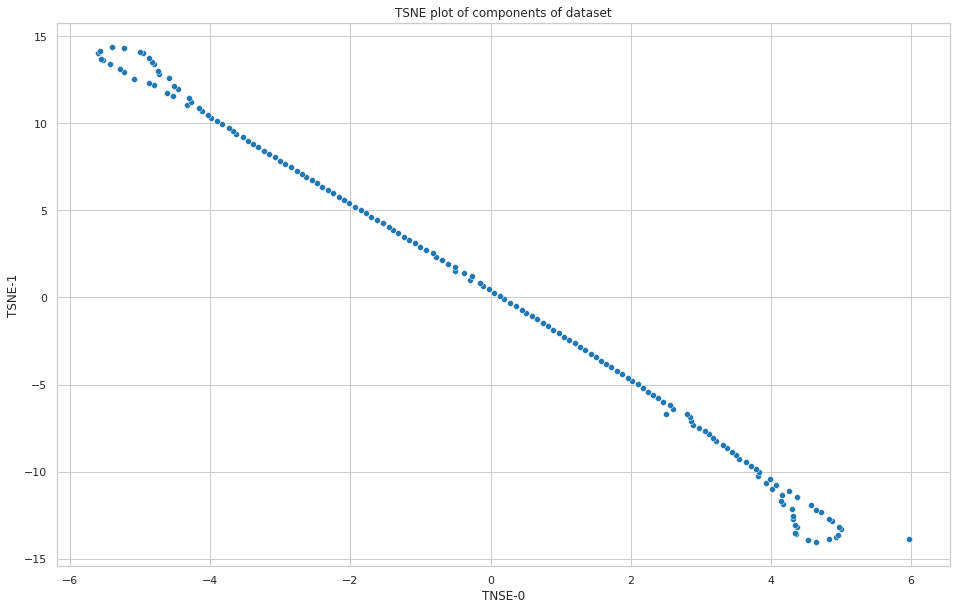

In [ ]:
# TSNE visualization
from sklearn.manifold import TSNE

DF_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(DF.iloc[:, :])

plt.figure(figsize=(16,10))
sns.scatterplot(x=DF_tsne[:,0], y=DF_tsne[:,1])
plt.title('TSNE plot of components of dataset')
plt.xlabel('TNSE-0')
plt.ylabel('TSNE-1')
plt.show()

* We can see that the TSNE transformation converted into a clear linear form.
* Only in the initial and trailing ends, there is a slight deviation indicating inaccurate predictions at these ends

# Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from prettytable import PrettyTable

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(DF,Capacity, test_size=0.59, random_state=25, shuffle=True)

print('X_Train shape = ', X_train.shape)
print('X_Test shape = ', X_test.shape)

X_Train shape =  (68, 17)
X_Test shape =  (99, 17)


### Scaling dataset

In [ ]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

* ## SGD regressor

In [ ]:
model_results = PrettyTable(["Hyperparameter - L2", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

In [ ]:
L2 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for l2 in L2:
  SGD = SGDRegressor(loss='squared_error', penalty='l2', alpha=l2)
  SGD.fit(X_train, y_train)
  train_pred = SGD.predict(X_train)
  test_pred = SGD.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameter - L2", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,l2 in enumerate(L2):
  Results.add_row([l2, 'SGD', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+---------------------+-------+----------------------+---------------------+----------------------+----------------------+
| Hyperparameter - L2 | Model |      Train MAE       |       Test MAE      |      Train MAPE      |      Test MAPE       |
+---------------------+-------+----------------------+---------------------+----------------------+----------------------+
|        0.001        |  SGD  | 0.048352769215932366 | 0.05049670455864072 | 0.03133277237585069  | 0.03159702664316677  |
|         0.01        |  SGD  | 0.04812746535091287  | 0.04800819616868631 | 0.031635300281912665 | 0.03045577731144124  |
|         0.1         |  SGD  | 0.04836907860942265  |  0.0473320437541021 | 0.03184605117758225  | 0.030148537356918567 |
|          1          |  SGD  | 0.04849967948879604  | 0.05086544903692684 | 0.030912574148017943 | 0.031395981672654824 |
|          10         |  SGD  | 0.07161499051151138  | 0.08181500029175949 | 0.043008003907147443 | 0.04798727035575378  |
|         100   

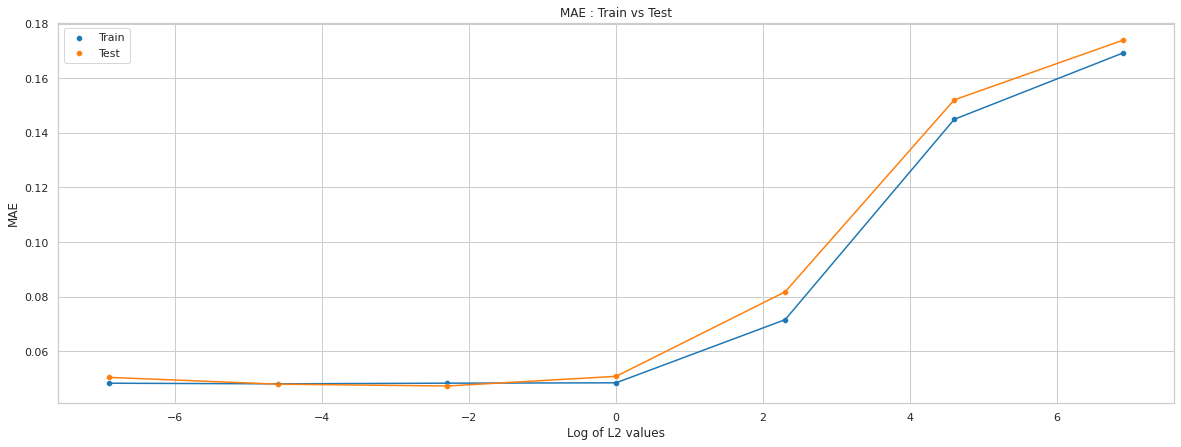

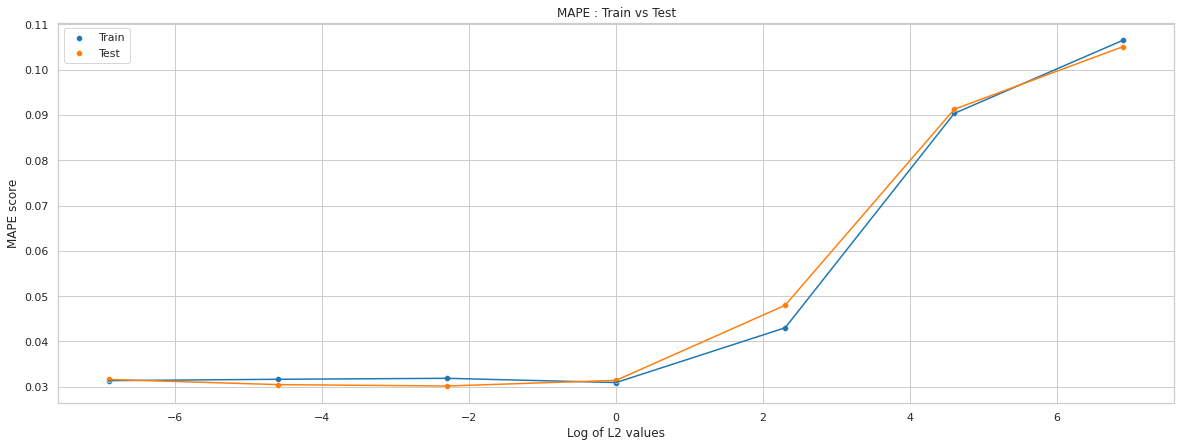

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log(L2), y=train_MAE, label='Train')
plt.plot(np.log(L2), train_MAE)
sns.scatterplot(x=np.log(L2), y=test_MAE, label='Test')
plt.plot(np.log(L2),test_MAE)
plt.xlabel('Log of L2 values')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log(L2), y=train_MAPE, label='Train')
plt.plot(np.log(L2), train_MAPE)
sns.scatterplot(x=np.log(L2), y=test_MAPE, label='Test')
plt.plot(np.log(L2),test_MAPE)
plt.legend()
plt.xlabel('Log of L2 values')
plt.ylabel('MAPE score')
plt.title('MAPE : Train vs Test')
plt.show()

* For lower values of alpha, error is significantly lower.
* Best parameter seems to be for alpha value of 0.1 and test MAE is 0.04846

In [ ]:
model_results.add_row(Results.rows[2])

* ## SVM regressor

In [ ]:
L2 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []


for l2 in L2:
  SGD = SGDRegressor(loss='epsilon_insensitive', penalty='l2', alpha=l2)
  SGD.fit(X_train, y_train)
  train_pred = SGD.predict(X_train)
  test_pred = SGD.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameter - C", "Model", "Train MAE", "Test MAE", "Train R2", "Test R2"])

for i,l2 in enumerate(L2):
  Results.add_row([l2, 'SVM', train_MAE[i], test_MAE[i],  train_MAPE[i], test_MAPE[i]])

print(Results)

+--------------------+-------+----------------------+----------------------+----------------------+----------------------+
| Hyperparameter - C | Model |      Train MAE       |       Test MAE       |       Train R2       |       Test R2        |
+--------------------+-------+----------------------+----------------------+----------------------+----------------------+
|       0.001        |  SVM  | 0.06199698602093826  | 0.057293919295189226 | 0.04199193077829338  | 0.03749481350807561  |
|        0.01        |  SVM  | 0.059080381932019754 | 0.054895564429415504 | 0.040233696531701835 | 0.03621689345319316  |
|        0.1         |  SVM  | 0.06733603149357655  |  0.068759075620145   |  0.0437820906606829  |  0.0433093229100284  |
|         1          |  SVM  | 0.054536611903704645 | 0.05266814596079274  | 0.03633139792568308  | 0.033951740038729195 |
|         10         |  SVM  | 0.07421200248858596  | 0.07379012964916065  |  0.0474589391582579  | 0.04516793748338232  |
|        100    

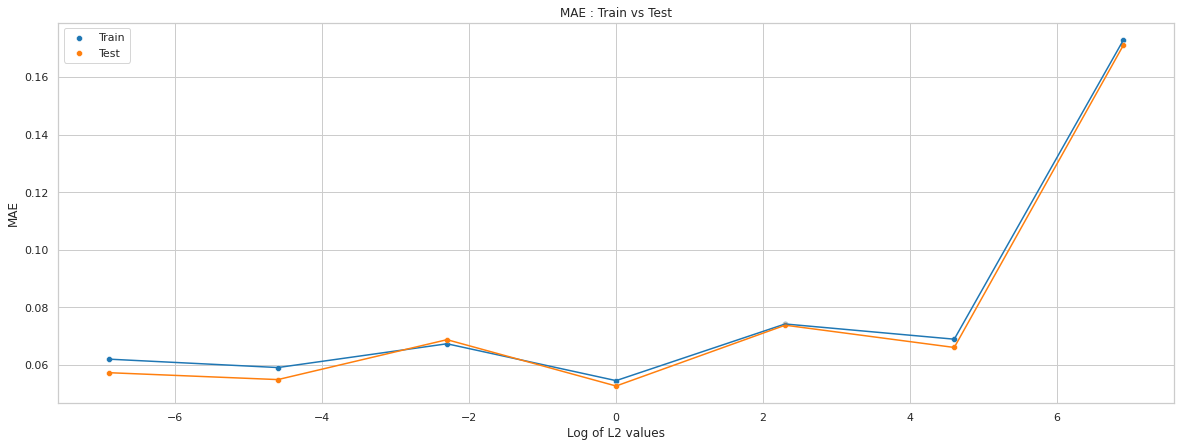

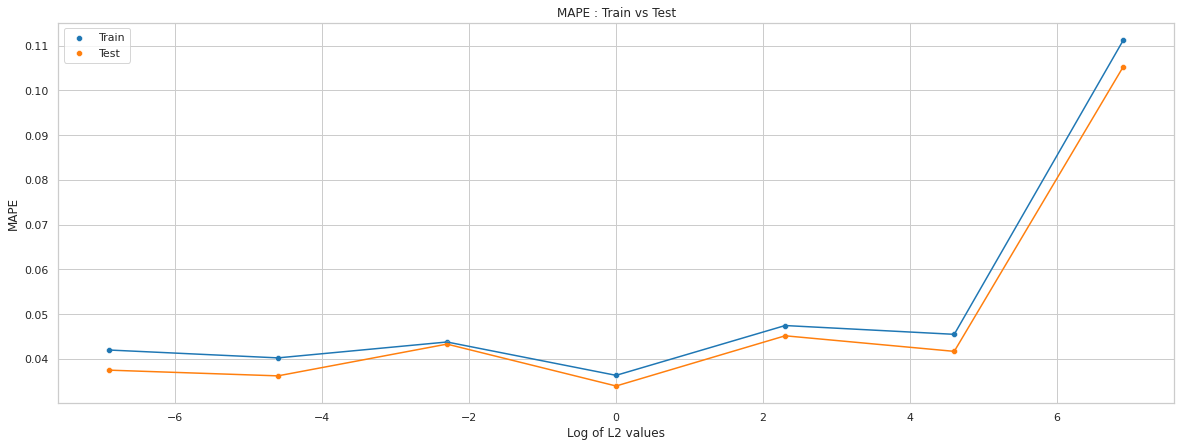

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log(L2), y=train_MAE, label='Train')
plt.plot(np.log(L2), train_MAE)
sns.scatterplot(x=np.log(L2), y=test_MAE, label='Test')
plt.plot(np.log(L2),test_MAE)
plt.xlabel('Log of L2 values')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log(L2), y=train_MAPE, label='Train')
plt.plot(np.log(L2), train_MAPE)
sns.scatterplot(x=np.log(L2), y=test_MAPE, label='Test')
plt.plot(np.log(L2),test_MAPE)
plt.legend()
plt.xlabel('Log of L2 values')
plt.ylabel('MAPE')
plt.title('MAPE : Train vs Test')
plt.show()

* Similar to SGD, for lower values of C, error is significantly lower.
* Best parameter seems to be for C value of 10 and test MAE is 0.04809
* Best MAE is close to SGD best MAE value

In [ ]:
model_results.add_row(Results.rows[4])

* ## RANSAC Regressor

In [ ]:
L2 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for l2 in L2:
  SGD = SGDRegressor(loss='squared_loss', penalty='l2', alpha=l2)
  RGD = RANSACRegressor(base_estimator = SGD)
  RGD.fit(X_train, y_train)
  train_pred = RGD.predict(X_train)
  test_pred = RGD.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameter - L2", "Model", "Train MAE", "Test MAE", "Train R2", "Test R2"])

for i,l2 in enumerate(L2):
  Results.add_row([l2, 'RANSAC', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+---------------------+--------+----------------------+----------------------+----------------------+---------------------+
| Hyperparameter - L2 | Model  |      Train MAE       |       Test MAE       |       Train R2       |       Test R2       |
+---------------------+--------+----------------------+----------------------+----------------------+---------------------+
|        0.001        | RANSAC | 0.052851866093082636 | 0.055846076822908944 | 0.03446818809122296  | 0.03535266709851045 |
|         0.01        | RANSAC | 0.058473788304731544 | 0.06171650194513294  |  0.0386037553122496  | 0.03917563997514528 |
|         0.1         | RANSAC | 0.05344489613774928  | 0.055327877370695965 | 0.03424514797690485  | 0.03459276829662921 |
|          1          | RANSAC | 0.048472388429558456 | 0.05057531008373013  | 0.030972227817302852 | 0.03127673796525376 |
|          10         | RANSAC | 0.07275974835891692  | 0.08454403865077838  | 0.04335204148414004  | 0.04940404438647219 |
|       

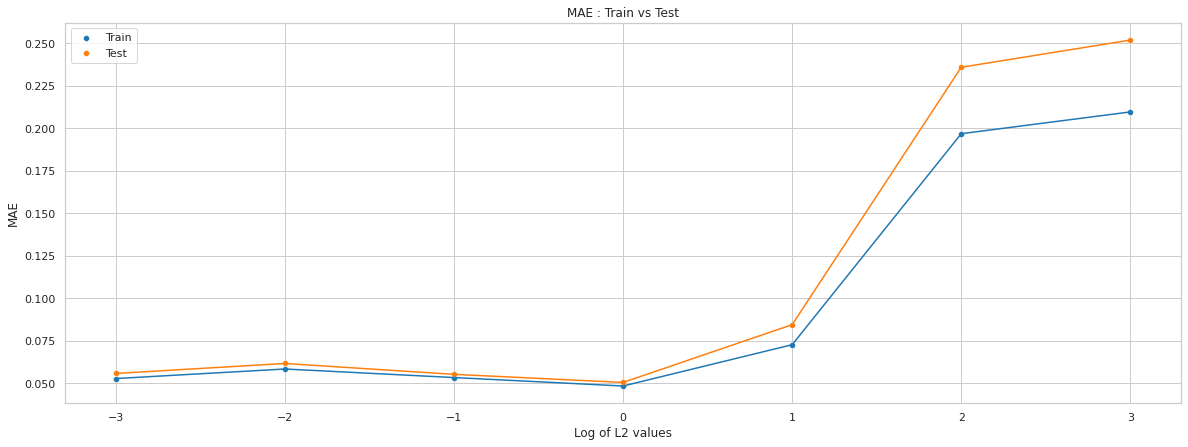

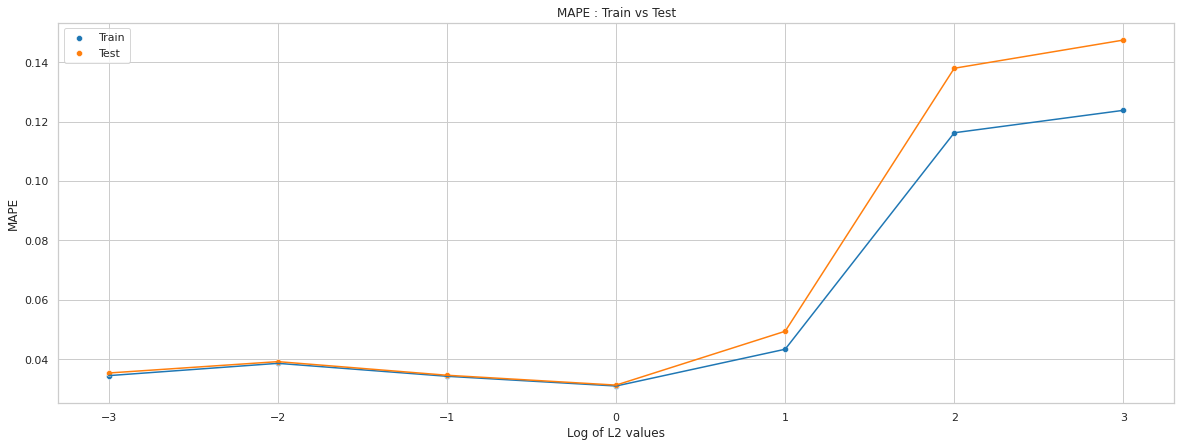

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log10(L2), y=train_MAE, label='Train')
plt.plot(np.log10(L2), train_MAE)
sns.scatterplot(x=np.log10(L2), y=test_MAE, label='Test')
plt.plot(np.log10(L2),test_MAE)
plt.xlabel('Log of L2 values')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log10(L2), y=train_MAPE, label='Train')
plt.plot(np.log10(L2), train_MAPE)
sns.scatterplot(x=np.log10(L2), y=test_MAPE, label='Test')
plt.plot(np.log10(L2),test_MAPE)
plt.legend()
plt.xlabel('Log of L2 values')
plt.ylabel('MAPE')
plt.title('MAPE : Train vs Test')
plt.show()

* Similar to SGD, for lower values of C, error is significantly lower.
* Best parameter seems to be for alpha value of 0.1 and test MAE is 0.013948
* Best MAE is better than SGD and SVM

In [ ]:
model_results.add_row(Results.rows[2])

* ## Decision tree regressor

In [ ]:
depth = [2,3,5,6]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for d in depth:
  DT = DecisionTreeRegressor(max_depth=d)
  DT.fit(X_train, y_train)
  train_pred = DT.predict(X_train)
  test_pred = DT.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameter - Max depth", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,d in enumerate(depth):
  Results.add_row([d, 'DT-Regressor', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+----------------------------+--------------+-----------------------+----------------------+-----------------------+----------------------+
| Hyperparameter - Max depth |    Model     |       Train MAE       |       Test MAE       |       Train MAPE      |      Test MAPE       |
+----------------------------+--------------+-----------------------+----------------------+-----------------------+----------------------+
|             2              | DT-Regressor |  0.034328002194744245 |  0.0386373588764257  |  0.022563114465343214 | 0.02415704149272116  |
|             3              | DT-Regressor |  0.014914022677315413 | 0.022830246509707997 |  0.009742863265634276 | 0.014250867693382886 |
|             5              | DT-Regressor | 0.0028305099082995442 | 0.01419038260151865  | 0.0018789779852910731 | 0.008977931450940316 |
|             6              | DT-Regressor | 0.0006583263141837476 | 0.016600676430336973 | 0.0004776691868056861 | 0.009968633437854094 |
+-------------------

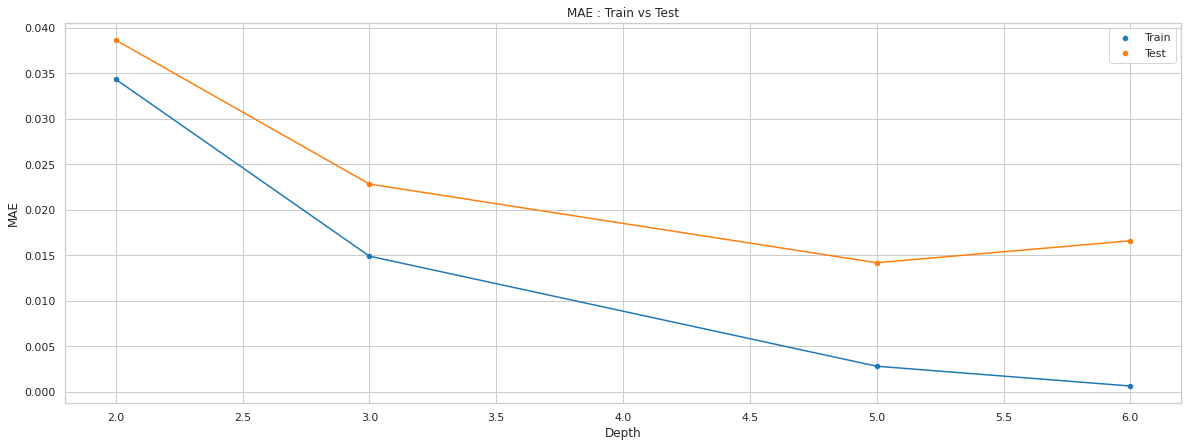

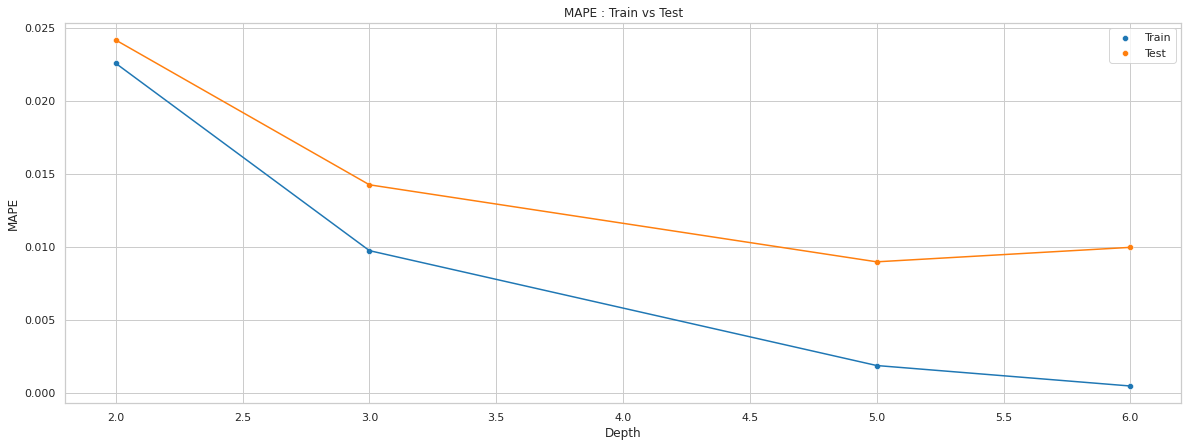

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=depth, y=train_MAE, label='Train')
plt.plot(depth, train_MAE)
sns.scatterplot(x=depth, y=test_MAE, label='Test')
plt.plot(depth,test_MAE)
plt.xlabel('Depth')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(depth, y=train_MAPE, label='Train')
plt.plot(depth, train_MAPE)
sns.scatterplot(x=depth, y=test_MAPE, label='Test')
plt.plot(depth,test_MAPE)
plt.legend()
plt.xlabel('Depth')
plt.ylabel('MAPE')
plt.title('MAPE : Train vs Test')
plt.show()

* For higher values of max_depth, error is low.
* Best parameter seems to be for depth value of 5 and test MAE is 0.01124
* For depth higher than 5, decision tree is overfitting

In [ ]:
model_results.add_row(Results.rows[2])

* ## Adaboost regression

In [ ]:
n_estimators = [20,30,50,60]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for n in n_estimators:
  ABD = AdaBoostRegressor(n_estimators=n)
  ABD.fit(X_train, y_train)
  train_pred = ABD.predict(X_train)
  test_pred = ABD.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameter - n_estimators", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,d in enumerate(n_estimators):
  Results.add_row([d, 'ADB Regressor', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+-------------------------------+---------------+----------------------+----------------------+-----------------------+----------------------+
| Hyperparameter - n_estimators |     Model     |      Train MAE       |       Test MAE       |       Train MAPE      |      Test MAPE       |
+-------------------------------+---------------+----------------------+----------------------+-----------------------+----------------------+
|               20              | ADB Regressor | 0.007719862915548816 | 0.013316838085006244 |  0.005124400870502271 | 0.008333048059554827 |
|               30              | ADB Regressor | 0.008040955000399934 | 0.011422873312547967 |  0.005305553354233494 | 0.007215773203352175 |
|               50              | ADB Regressor | 0.005999905953420585 | 0.011322169282217163 |  0.003876513160017984 | 0.006989621124115673 |
|               60              | ADB Regressor | 0.006943089880998066 | 0.011544709700742267 | 0.0045480874745481336 | 0.007068628878948425 |

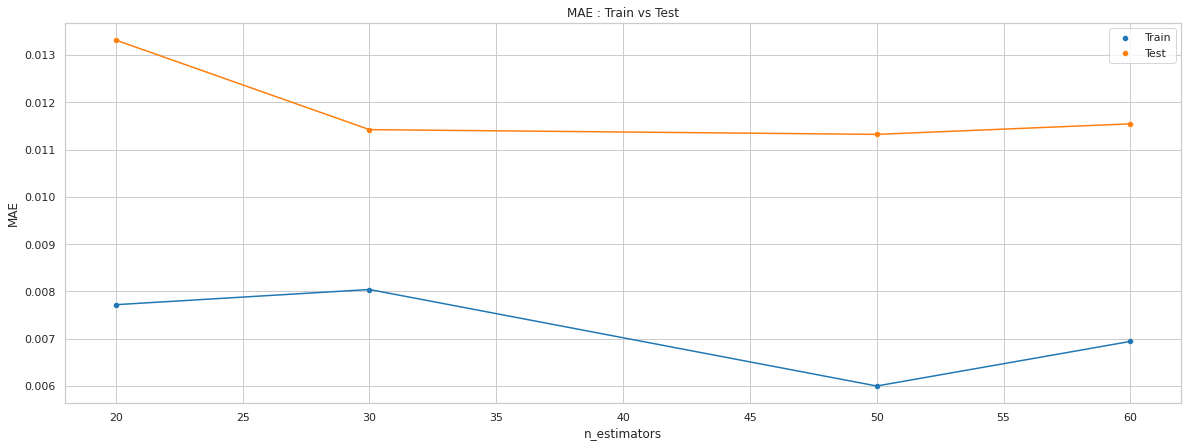

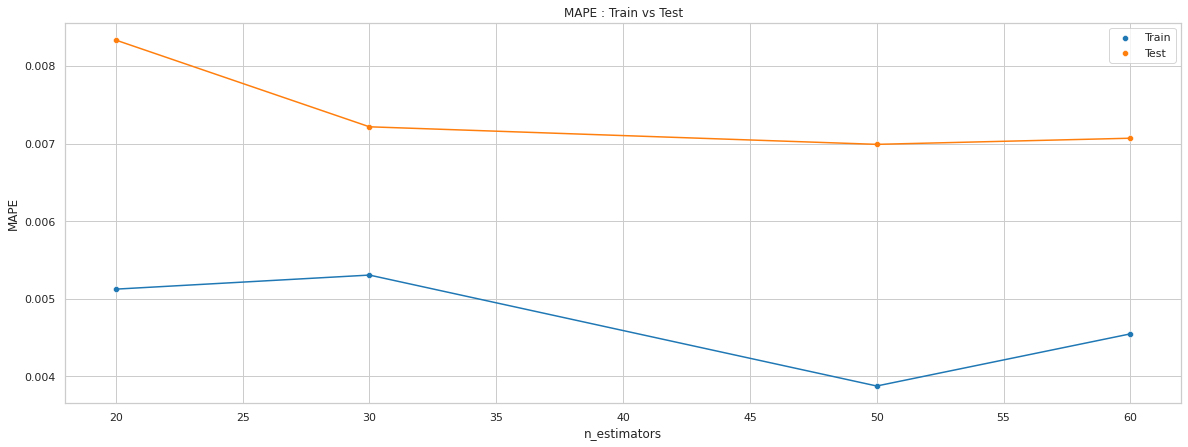

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=n_estimators, y=train_MAE, label='Train')
plt.plot(n_estimators, train_MAE)
sns.scatterplot(x=n_estimators, y=test_MAE, label='Test')
plt.plot(n_estimators,test_MAE)
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(n_estimators, y=train_MAPE, label='Train')
plt.plot(n_estimators, train_MAPE)
sns.scatterplot(x=n_estimators, y=test_MAPE, label='Test')
plt.plot(n_estimators,test_MAPE)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('MAPE')
plt.title('MAPE : Train vs Test')
plt.show()


* Variation of error with n_estimators is slightly less
* Best parameter seems to be for n_estimators of 60 and test MAE is 0.01013
* The MAE of Adaboost is close to decision tree and less than SGD/RANSAC

In [ ]:
model_results.add_row(Results.rows[3])

* ## Random Forest Regression

In [ ]:
n_estimators = [20,40,100]
depth = [2,3,5]
params = [[n,d] for n in n_estimators for d in depth]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for p in params:
  RF = RandomForestRegressor(n_estimators=p[0], max_depth=p[1])
  RF.fit(X_train, y_train)
  train_pred = RF.predict(X_train)
  test_pred = RF.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))

In [ ]:
Results = PrettyTable(["Hyperparameters - n_est, depth", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,d in enumerate(params):
  Results.add_row([d, 'RF Regressor', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+--------------------------------+--------------+-----------------------+----------------------+-----------------------+----------------------+
| Hyperparameters - n_est, depth |    Model     |       Train MAE       |       Test MAE       |       Train MAPE      |      Test MAPE       |
+--------------------------------+--------------+-----------------------+----------------------+-----------------------+----------------------+
|            [20, 2]             | RF Regressor |  0.023903427510904907 | 0.025250034398628857 |   0.015662984626384   | 0.01566506750194767  |
|            [20, 3]             | RF Regressor |  0.008930252639898564 | 0.012045214267058003 | 0.0058765317105511986 | 0.007484972535493493 |
|            [20, 5]             | RF Regressor | 0.0035086704723006706 | 0.008251578769607457 |  0.002298457287072509 | 0.005014914007535018 |
|            [40, 2]             | RF Regressor |  0.024122577114446913 | 0.02488682628744202  |  0.015836904230887287 | 0.0155527630000

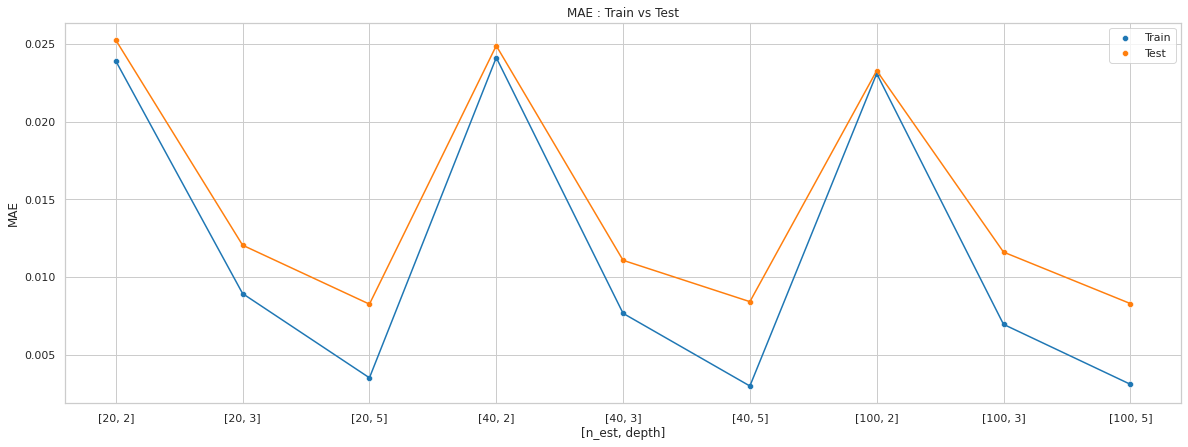

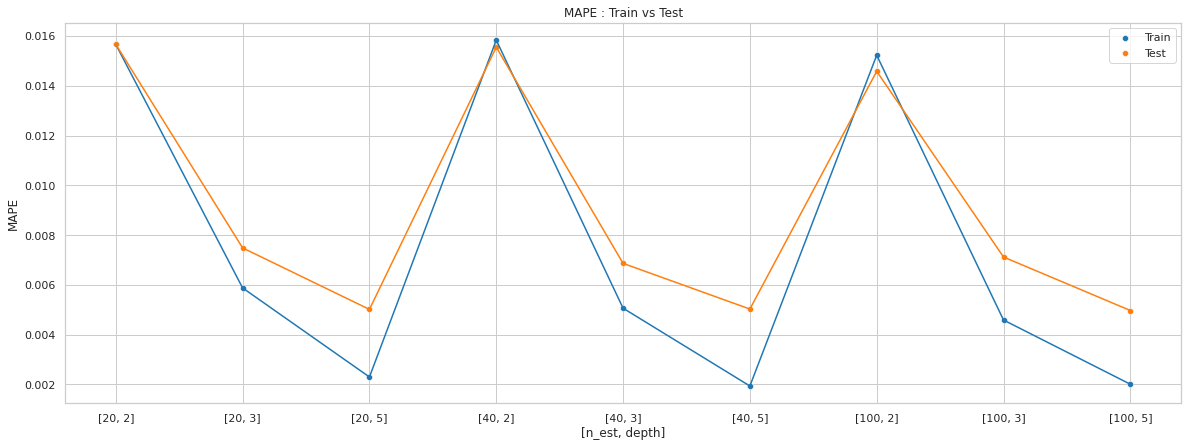

In [ ]:
plt.figure(figsize=(20,7))
param_list = np.arange(len(params))
sns.scatterplot(x=param_list, y=train_MAE, label='Train')
plt.plot(param_list, train_MAE)
sns.scatterplot(x=param_list, y=test_MAE, label='Test')
plt.plot(param_list,test_MAE)
plt.xticks(param_list, [str(p) for p in params])
plt.xlabel('[n_est, depth]')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(param_list, y=train_MAPE, label='Train')
plt.plot(param_list, train_MAPE)
sns.scatterplot(x=param_list, y=test_MAPE, label='Test')
plt.plot(param_list,test_MAPE)
plt.xticks(param_list, [str(p) for p in params])
plt.legend()
plt.xlabel('[n_est, depth]')
plt.ylabel('MAPE')
plt.title('MAPE : Train vs Test')
plt.show()


* Depth parameter has significant effect than estimators.
* Best parameters seems to be for n_estimators of 40, depth of 5 and test MAE is 0.008015
* The MAE of Random forest is significantly lower than DT and SGD/RANSAC

In [ ]:
model_results.add_row(Results.rows[5])

* ## GBDT Regression

In [ ]:
n_estimators = [5,10,20]
depth = [2,3,5]
params = [[n,d] for n in n_estimators for d in depth]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for p in params:
  GBDT = GradientBoostingRegressor(n_estimators=p[0], max_depth=p[1])
  GBDT.fit(X_train, y_train)
  train_pred = GBDT.predict(X_train)
  test_pred = GBDT.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameters - n_est, depth", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,d in enumerate(params):
  Results.add_row([d, 'GBDT Regressor', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+--------------------------------+----------------+----------------------+----------------------+----------------------+----------------------+
| Hyperparameters - n_est, depth |     Model      |      Train MAE       |       Test MAE       |      Train MAPE      |      Test MAPE       |
+--------------------------------+----------------+----------------------+----------------------+----------------------+----------------------+
|             [5, 2]             | GBDT Regressor |  0.1045541232544322  | 0.10128847457347961  | 0.06821420476589539  | 0.06304068821549406  |
|             [5, 3]             | GBDT Regressor | 0.10338292549388045  | 0.10162572822604343  | 0.06737120406858325  | 0.06328570904429139  |
|             [5, 5]             | GBDT Regressor | 0.10280632325560832  | 0.10035077333848151  | 0.06698196318082317  | 0.06243139387643154  |
|            [10, 2]             | GBDT Regressor | 0.06272420075231437  | 0.06254902013681758  | 0.040960856026521386 | 0.0388246727058

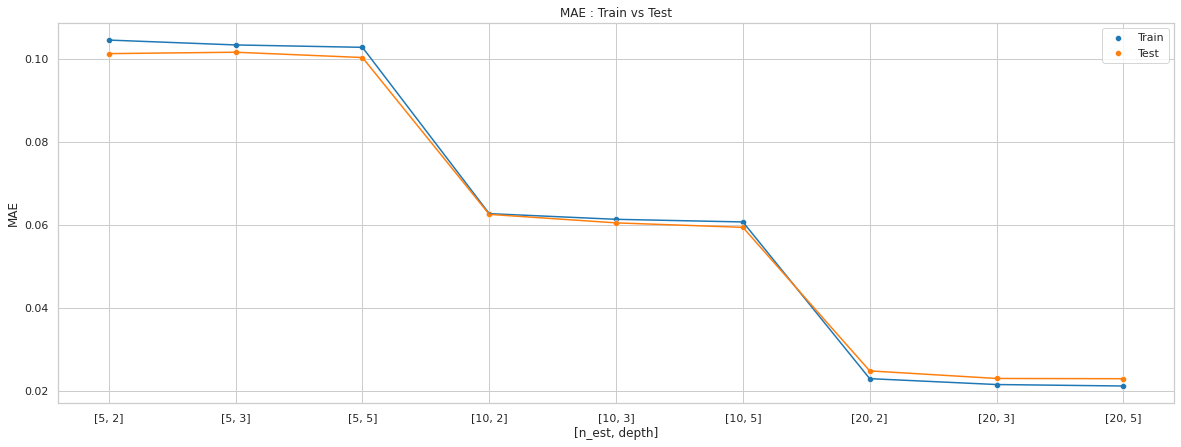

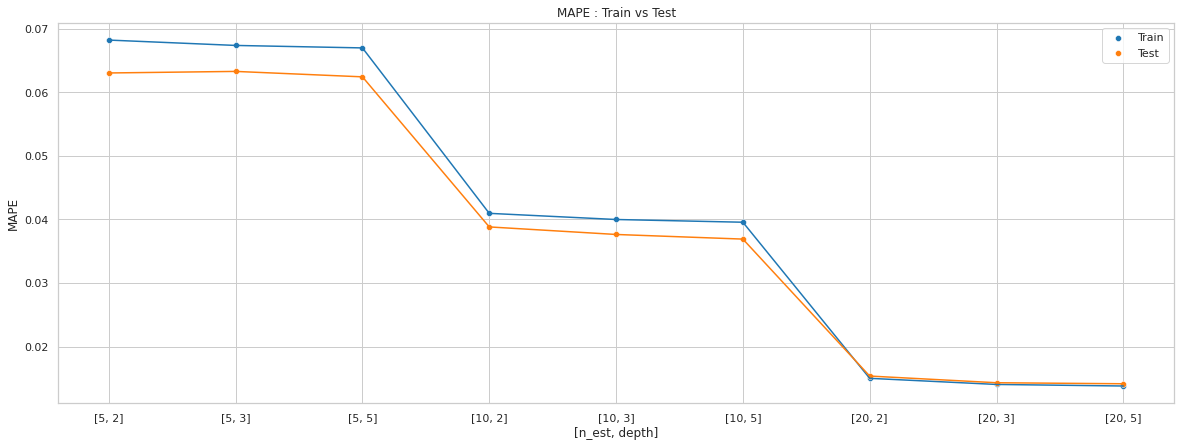

In [ ]:
plt.figure(figsize=(20,7))
param_list = np.arange(len(params))
sns.scatterplot(x=param_list, y=train_MAE, label='Train')
plt.plot(param_list, train_MAE)
sns.scatterplot(x=param_list, y=test_MAE, label='Test')
plt.plot(param_list,test_MAE)
plt.xticks(param_list, [str(p) for p in params])
plt.xlabel('[n_est, depth]')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(param_list, y=train_MAPE, label='Train')
plt.plot(param_list, train_MAPE)
sns.scatterplot(x=param_list, y=test_MAPE, label='Test')
plt.plot(param_list,test_MAPE)
plt.xticks(param_list, [str(p) for p in params])
plt.legend()
plt.xlabel('[n_est, depth]')
plt.ylabel('MAPE')
plt.title('MAPE : Train vs Test')
plt.show()


* estimators parameter has significant effect than Depth.
* Best parameters seems to be for n_estimators of 20, depth of 5 and test MAE is 0.02342
* The MAE of GBDT is significantly higher than DT and SGD/RANSAC

In [ ]:
model_results.add_row(Results.rows[-1])

## Best models with Parameters

In [ ]:
model_no_interp = model_results
print(model_results)

+---------------------+----------------+-----------------------+----------------------+-----------------------+----------------------+
| Hyperparameter - L2 |     Model      |       Train MAE       |       Test MAE       |       Train MAPE      |      Test MAPE       |
+---------------------+----------------+-----------------------+----------------------+-----------------------+----------------------+
|         0.1         |      SGD       |  0.04836907860942265  |  0.0473320437541021  |  0.03184605117758225  | 0.030148537356918567 |
|          10         |      SVM       |  0.07421200248858596  | 0.07379012964916065  |   0.0474589391582579  | 0.04516793748338232  |
|         0.1         |     RANSAC     |  0.05344489613774928  | 0.055327877370695965 |  0.03424514797690485  | 0.03459276829662921  |
|          5          |  DT-Regressor  | 0.0028305099082995442 | 0.01419038260151865  | 0.0018789779852910731 | 0.008977931450940316 |
|          60         | ADB Regressor  |  0.00694308988

In [ ]:
table = np.array(model_results.rows)

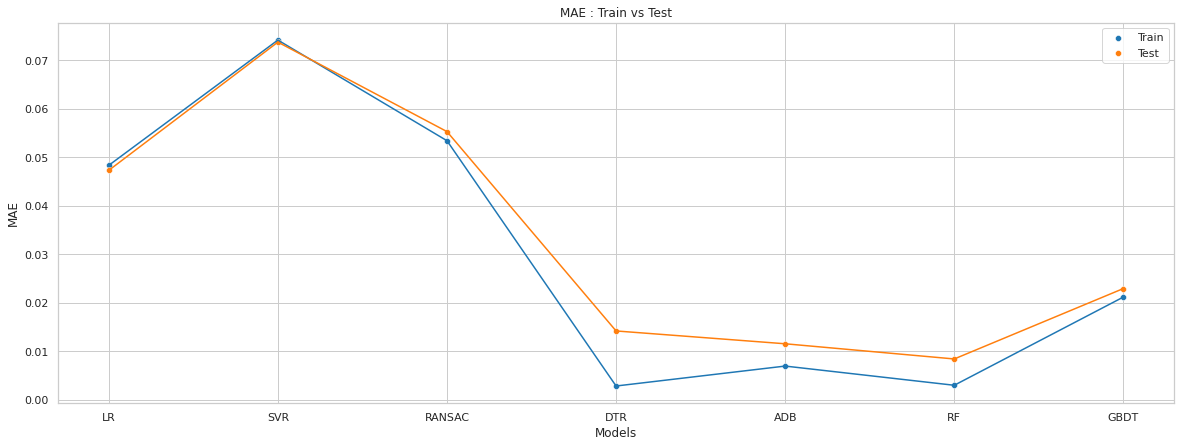

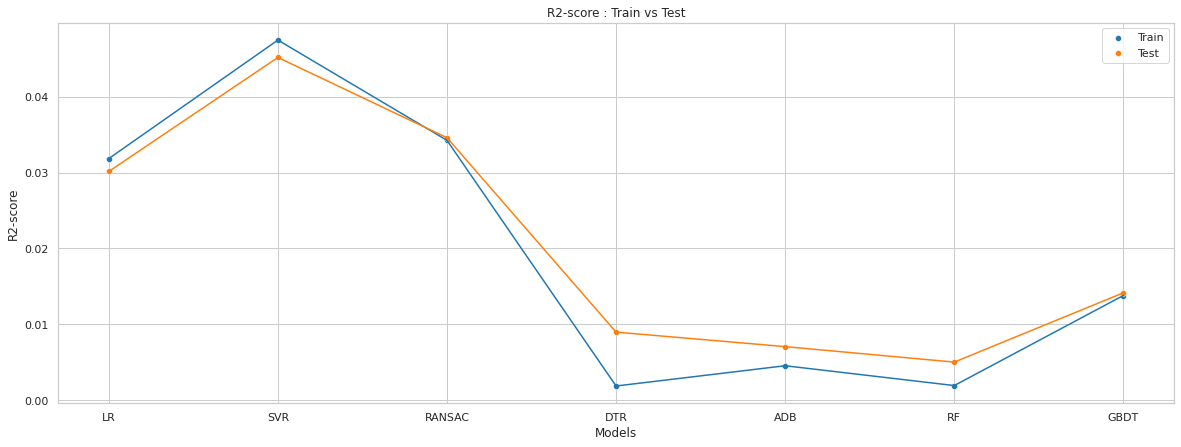

In [ ]:
model_list = ['LR', 'SVR', 'RANSAC', 'DTR', 'ADB', 'RF', 'GBDT']
plt.figure(figsize=(20,7))
param_list = np.arange(len(model_list))
sns.scatterplot(x=param_list, y=table[:,2].astype('float'), label='Train')
plt.plot(param_list, table[:,2].astype('float'))
sns.scatterplot(x=param_list, y=table[:,3].astype('float'), label='Test')
plt.plot(param_list,table[:,3].astype('float'))
plt.xticks(param_list, [str(p) for p in model_list])
plt.xlabel('Models')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
param_list = np.arange(len(model_list))
sns.scatterplot(x=param_list, y=table[:,4].astype('float'), label='Train')
plt.plot(param_list, table[:,4].astype('float'))
sns.scatterplot(x=param_list, y=table[:,5].astype('float'), label='Test')
plt.plot(param_list,table[:,5].astype('float'))
plt.xticks(param_list, [str(p) for p in model_list])
plt.xlabel('Models')
plt.ylabel('R2-score')
plt.legend()
plt.title('R2-score : Train vs Test')
plt.show()

* From the above graph, it can be seen that Random forest seems to be doing well when compared to all other models
* Decision tree seems to be doing better than RF but it is overfitting which resulted in higher difference in train and test metrics when compared to RF model

# Interpolation of data

## Linear Interpolation

Method of interpolation:

* Sort the training data based on cycle column
* expand_len : number of observations to which the existing dataset is to be interpolated
* dummy_row_len = expand_len/existing_dataset_rows, gives how many new points are needed to be generated between two rows of existing dataframe rows
* Create new dataframe with rows equal to expand_len and columns equal to existing dataframe and value of np.nan
* for every dummy_row_len, add a row from existing dataframe into new df
* for each column, use pandas.interpolate function to obtain nan values

In [ ]:
def interpolate_data(data, expand_len):
  l_row = data.shape[0]
  l_col = data.shape[1]
  dummy_rows_len = np.floor(expand_len/l_row).astype('int')
  upsamp = np.array([np.nan]*l_col*expand_len).reshape(-1, l_col)
  DF_upsamp = pd.DataFrame(upsamp, columns=data.columns)

  id_upsamp = 0
  for idx in range(data.shape[0]):
    try:
      DF_upsamp.iloc[id_upsamp] = data.iloc[idx]
      id_upsamp+=dummy_rows_len
    except Exception as e:
      print('Exception : ', e)
      print('at ID = ',idx)
      import pdb
      pdb.set_trace()

  for i in list(DF_upsamp.keys()):
    DF_upsamp[i] = pd.Series(DF_upsamp[i]).interpolate(method='linear').values
  
  return DF_upsamp

Preparing data for interpolation

In [ ]:
DF_train = pd.DataFrame(X_train, columns=DF.columns)
DF_train['Capacity'] = y_train
DF_train = DF_train.sort_values('cycle_no')   # Sorting based on cycle number
DF_train

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4,dis_temp_gro_3,dis_temp_gro_4,SSA_V_ch,SSA_V_dis,SSA_I_ch,SSA_I_dis,fft_V_1,fft_V_2,Capacity
50,-1.795890,1.535161,-1.292575,2.522995,-3.287478,1.517978,-1.524117,1.371090,0.790393,1.371090,0.790393,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017,1.846327
26,-1.775811,1.530136,-1.422208,2.269506,-3.036537,1.470862,-1.303393,1.482464,0.711702,1.482464,0.711702,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017,1.835349
56,-1.755732,1.504575,-1.376378,1.920273,-2.826853,1.471586,-1.411046,1.384861,0.960672,1.384861,0.960672,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017,1.835263
31,-1.715574,1.500313,-1.358401,2.466572,-2.582641,1.470444,-1.507208,1.284151,1.250845,1.284151,1.250845,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017,1.835662
27,-1.595100,1.489164,-1.326066,1.896877,-1.975205,1.376798,-1.556935,1.465419,1.324031,1.465419,1.324031,-1.530015,0.986180,1.290166,0.523362,0.093271,-1.309737,1.814202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1.316356,-1.180800,1.147789,-0.308816,0.987617,-1.275026,1.024083,-1.194361,-1.582099,-1.194361,-1.582099,1.094570,-1.276318,-1.167397,-1.303285,-1.290704,1.171931,1.307796
23,1.456909,-1.272325,1.218829,-0.338311,0.851759,-1.398090,1.079736,-1.268445,-1.759020,-1.268445,-1.759020,1.130394,-1.372549,-1.218130,-1.415716,-1.500124,1.264998,1.288003
36,1.476988,-1.284763,1.284519,-0.613048,0.843385,-1.402162,1.063461,-1.319942,-1.719000,-1.319942,-1.719000,1.154650,-1.361952,-1.286620,-1.478613,-1.527302,1.280017,1.287453
9,1.497067,-1.291458,1.106492,-0.125295,0.561262,-1.268773,0.870207,-1.192240,-1.585659,-1.192240,-1.585659,1.177023,-1.396477,-1.368259,-1.481756,-1.512522,1.278279,1.309015


In [ ]:
DF_upsamp = interpolate_data(DF_train, 1020)  # Interpolation
DF_upsamp

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4,dis_temp_gro_3,dis_temp_gro_4,SSA_V_ch,SSA_V_dis,SSA_I_ch,SSA_I_dis,fft_V_1,fft_V_2,Capacity
0,-1.795890,1.535161,-1.292575,2.522995,-3.287478,1.517978,-1.524117,1.371090,0.790393,1.371090,0.790393,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017,1.846327
1,-1.794552,1.534826,-1.301217,2.506096,-3.270748,1.514837,-1.509402,1.378515,0.785147,1.378515,0.785147,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017,1.845595
2,-1.793213,1.534491,-1.309859,2.489197,-3.254019,1.511696,-1.494687,1.385940,0.779901,1.385940,0.779901,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017,1.844864
3,-1.791874,1.534156,-1.318502,2.472297,-3.237290,1.508555,-1.479972,1.393365,0.774655,1.393365,0.774655,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017,1.844132
4,-1.790536,1.533821,-1.327144,2.455398,-3.220560,1.505414,-1.465258,1.400790,0.769409,1.400790,0.769409,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017,1.843400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1.517146,-1.209849,1.174271,0.239299,-0.171981,-1.172389,0.826173,-1.260604,-0.607127,-1.260604,-0.607127,1.141607,-1.340512,-1.200933,-1.358692,-1.463020,1.274591,1.325079
1016,1.517146,-1.209849,1.174271,0.239299,-0.171981,-1.172389,0.826173,-1.260604,-0.607127,-1.260604,-0.607127,1.141607,-1.340512,-1.200933,-1.358692,-1.463020,1.274591,1.325079
1017,1.517146,-1.209849,1.174271,0.239299,-0.171981,-1.172389,0.826173,-1.260604,-0.607127,-1.260604,-0.607127,1.141607,-1.340512,-1.200933,-1.358692,-1.463020,1.274591,1.325079
1018,1.517146,-1.209849,1.174271,0.239299,-0.171981,-1.172389,0.826173,-1.260604,-0.607127,-1.260604,-0.607127,1.141607,-1.340512,-1.200933,-1.358692,-1.463020,1.274591,1.325079


In [ ]:
DF_upsamp = DF_upsamp.sample(frac = 1).reset_index(drop=True) # Shuffling data for training
y_train = DF_upsamp['Capacity']
X_train = DF_upsamp.drop('Capacity', axis=1)
X_train

,cycle_no,CCC_mode,ch_cur_dec_4,ch_cur_dec_5,peak_temp_med,dis_cc_dur,dis_RVM,dis_volt_dec_3,dis_volt_dec_4,dis_temp_gro_3,dis_temp_gro_4,SSA_V_ch,SSA_V_dis,SSA_I_ch,SSA_I_dis,fft_V_1,fft_V_2
0,-1.778488,1.530806,-1.404924,2.303304,-3.069996,1.477145,-1.332823,1.467614,0.722194,1.467614,0.722194,-1.530015,0.986180,1.290166,0.523362,-0.020483,-1.256017
1,1.083440,-1.110073,1.070074,-0.291067,0.951968,-1.186734,0.997884,-1.117874,-1.475193,-1.117874,-1.475193,0.983503,-1.169103,-1.002162,-1.233043,-1.229203,1.093912
2,0.833121,-0.899012,1.017609,-0.152849,0.955277,-0.812547,0.750619,-0.800897,-0.488155,-0.800897,-0.488155,0.906706,-0.907081,-0.989506,-0.871517,-0.842292,0.917789
3,0.543984,-0.697938,0.662586,-0.262796,0.215190,-0.610088,0.644466,-0.613465,-0.489345,-0.613465,-0.489345,0.691979,-0.637833,-0.613709,-0.593852,-0.457168,0.674992
4,1.460925,-1.274812,1.231967,-0.393258,0.850084,-1.398904,1.076481,-1.278744,-1.751016,-1.278744,-1.751016,1.135245,-1.370430,-1.231828,-1.428295,-1.505560,1.268002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,0.882650,-0.934949,0.972415,-0.396853,0.919163,-0.918972,0.829805,-0.900855,-0.772950,-0.900855,-0.772950,0.925648,-0.935127,-1.024837,-0.955501,-0.872478,0.937935
1016,0.534613,-0.690883,0.655856,-0.329529,0.242509,-0.678192,0.738974,-0.669393,-0.457174,-0.669393,-0.457174,0.702028,-0.660073,-0.645124,-0.554033,-0.449518,0.669887
1017,0.941548,-0.954510,0.917702,-0.458103,0.768995,-1.002688,0.854061,-1.058370,-0.907872,-1.058370,-0.907872,0.943643,-0.988943,-1.022540,-1.020114,-0.917423,0.969518
1018,-0.138703,-0.036704,0.125512,-0.277282,0.074851,0.050909,0.343868,-0.061282,0.306474,-0.061282,0.306474,0.174076,0.088558,0.009626,0.300329,0.435532,0.047784


In [ ]:
model_results = PrettyTable(["Hyperparameter - L2", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

## SGD Regressor

In [ ]:
L2 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for l2 in L2:
  SGD = SGDRegressor(loss='squared_error', penalty='l2', alpha=l2)
  SGD.fit(X_train, y_train)
  train_pred = SGD.predict(X_train)
  test_pred = SGD.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))



In [ ]:
Results = PrettyTable(["Hyperparameter - L2", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,l2 in enumerate(L2):
  Results.add_row([l2, 'SGD', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+---------------------+-------+----------------------+-----------------------+----------------------+----------------------+
| Hyperparameter - L2 | Model |      Train MAE       |        Test MAE       |      Train MAPE      |      Test MAPE       |
+---------------------+-------+----------------------+-----------------------+----------------------+----------------------+
|        0.001        |  SGD  | 0.006435204631735122 |  0.007948747322673621 | 0.004212414530571389 | 0.004812956233089783 |
|         0.01        |  SGD  | 0.006388196187740755 |  0.007630511475526216 |  0.0041076485464798  | 0.004578347759386464 |
|         0.1         |  SGD  | 0.006796399019397986 | 0.0078028797645868075 |  0.0043082546581683  | 0.004687987539947247 |
|          1          |  SGD  | 0.012771031463317433 |  0.013818051927116885 | 0.00814146061585222  | 0.008416609748652699 |
|          10         |  SGD  | 0.07098319171974363  |  0.07020128961978514  | 0.046150857781491764 | 0.043479392713431854 |


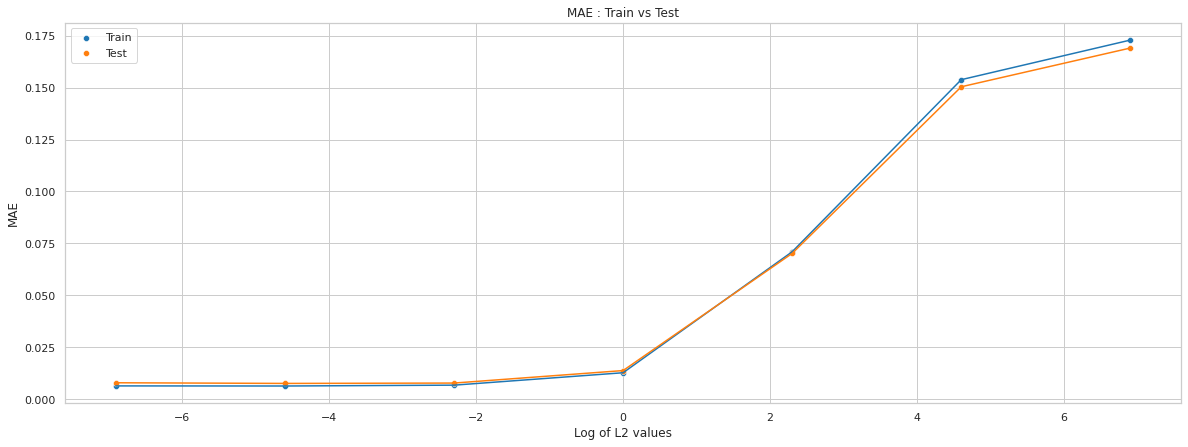

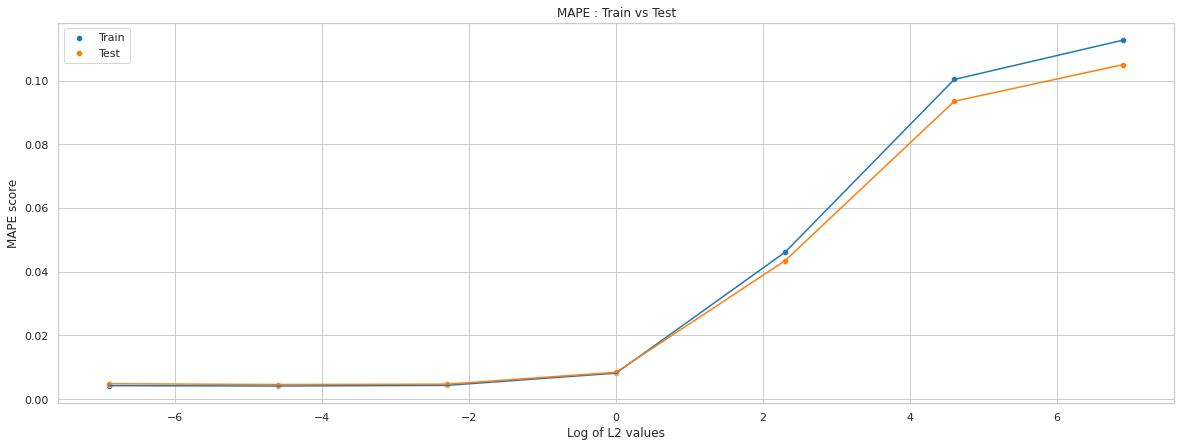

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log(L2), y=train_MAE, label='Train')
plt.plot(np.log(L2), train_MAE)
sns.scatterplot(x=np.log(L2), y=test_MAE, label='Test')
plt.plot(np.log(L2),test_MAE)
plt.xlabel('Log of L2 values')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log(L2), y=train_MAPE, label='Train')
plt.plot(np.log(L2), train_MAPE)
sns.scatterplot(x=np.log(L2), y=test_MAPE, label='Test')
plt.plot(np.log(L2),test_MAPE)
plt.legend()
plt.xlabel('Log of L2 values')
plt.ylabel('MAPE score')
plt.title('MAPE : Train vs Test')
plt.show()

* For lower values of alpha, error is significantly lower.
* Best parameter seems to be for alpha value of 0.01 and test MAE is 0.0064
* This is an improvement over original train data which has an MAE of 0.0486 for SGD with squared loss

In [ ]:
model_results.add_row(Results.rows[1])
print('Best parameter for SGD (Squared loss) : L2 - 0.01')

Best parameter for SGD (Squared loss) : L2 - 0.01


## SVM regressor

In [ ]:
L2 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for l2 in L2:
  SGD = SGDRegressor(loss='epsilon_insensitive', penalty='l2', alpha=l2)
  SGD.fit(X_train, y_train)
  train_pred = SGD.predict(X_train)
  test_pred = SGD.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameter - C", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,l2 in enumerate(L2):
  Results.add_row([l2, 'SVM', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+--------------------+-------+----------------------+---------------------+----------------------+----------------------+
| Hyperparameter - C | Model |      Train MAE       |       Test MAE      |      Train MAPE      |      Test MAPE       |
+--------------------+-------+----------------------+---------------------+----------------------+----------------------+
|       0.001        |  SVM  | 0.059279651255233504 | 0.05748195080233007 | 0.03959233263287556  | 0.03696664510531317  |
|        0.01        |  SVM  | 0.05118019498957256  | 0.04891485718934087 | 0.033952572504679444 | 0.03134946202511733  |
|        0.1         |  SVM  | 0.058232992293595194 | 0.05885359631405526 | 0.03825591103958365  | 0.03741103318029573  |
|         1          |  SVM  |  0.0644774628607577  | 0.06126071828042421 | 0.04268739380316949  | 0.038614298988151996 |
|         10         |  SVM  | 0.055514132115767174 |  0.0521285406127453 | 0.036849659643264414 | 0.032956013321929586 |
|        100         |  

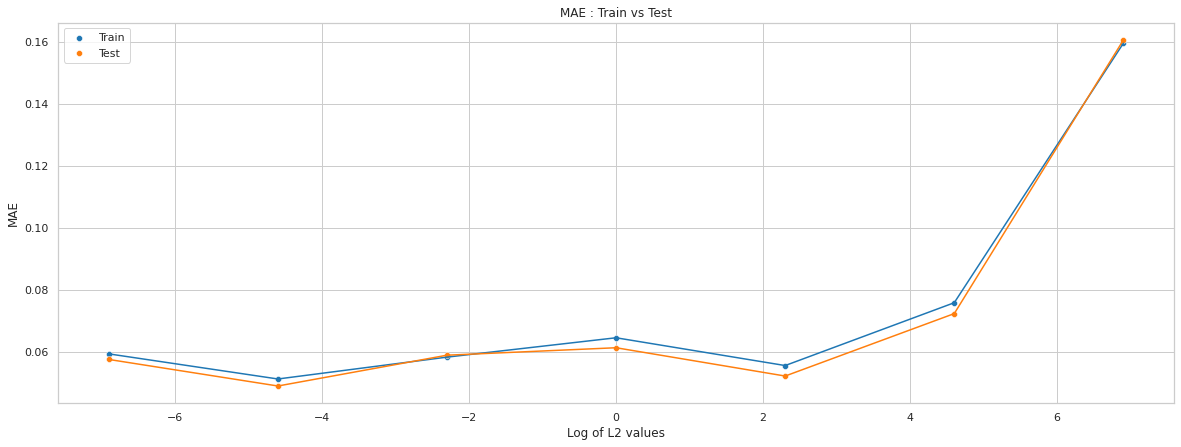

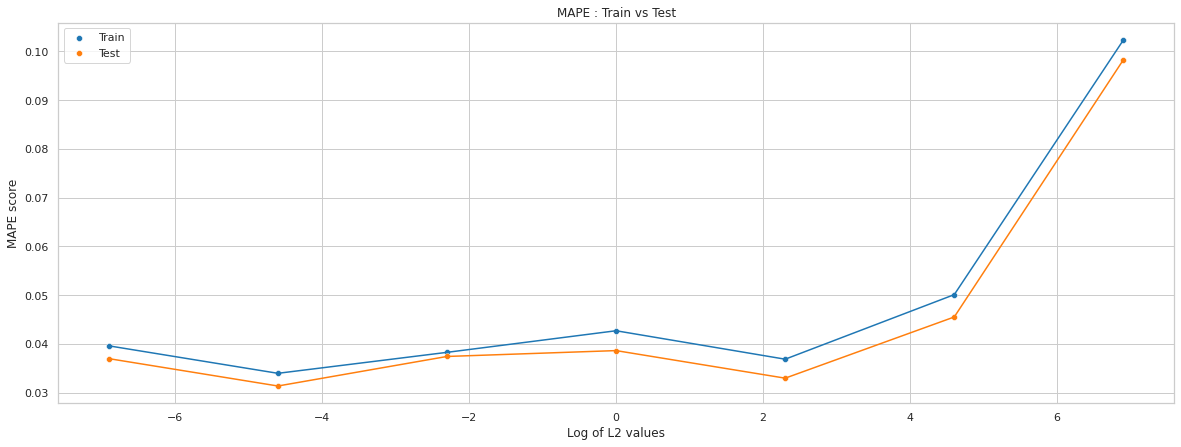

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log(L2), y=train_MAE, label='Train')
plt.plot(np.log(L2), train_MAE)
sns.scatterplot(x=np.log(L2), y=test_MAE, label='Test')
plt.plot(np.log(L2),test_MAE)
plt.xlabel('Log of L2 values')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log(L2), y=train_MAPE, label='Train')
plt.plot(np.log(L2), train_MAPE)
sns.scatterplot(x=np.log(L2), y=test_MAPE, label='Test')
plt.plot(np.log(L2),test_MAPE)
plt.legend()
plt.xlabel('Log of L2 values')
plt.ylabel('MAPE score')
plt.title('MAPE : Train vs Test')
plt.show()

* Similar to SGD, for lower values of C, error is significantly lower.
* Best parameter seems to be for C value of 1 and test MAE is 0.0401
* SVM with original dataset is 0.0480

In [ ]:
model_results.add_row(Results.rows[3])

## RANSAC regressor

In [ ]:
L2 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for l2 in L2:
  SGD = SGDRegressor(loss='squared_loss', penalty='l2', alpha=l2)
  RGD = RANSACRegressor(base_estimator = SGD)
  RGD.fit(X_train, y_train)
  train_pred = RGD.predict(X_train)
  test_pred = RGD.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))



In [ ]:
Results = PrettyTable(["Hyperparameter - L2", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,l2 in enumerate(L2):
  Results.add_row([l2, 'RANSAC', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+---------------------+--------+----------------------+----------------------+----------------------+----------------------+
| Hyperparameter - L2 | Model  |      Train MAE       |       Test MAE       |      Train MAPE      |      Test MAPE       |
+---------------------+--------+----------------------+----------------------+----------------------+----------------------+
|        0.001        | RANSAC | 0.017567087922574207 | 0.02193263325836002  | 0.010641391980309745 | 0.013140159328774575 |
|         0.01        | RANSAC | 0.00994892648152728  | 0.01169798450478941  | 0.006134849051964664 | 0.007005094031968891 |
|         0.1         | RANSAC | 0.013776105383898736 | 0.016860051432055788 | 0.008262568074490786 | 0.009938078178279172 |
|          1          | RANSAC | 0.01540851848787138  | 0.017578957594551484 | 0.00957972767471124  | 0.01049643466726034  |
|          10         | RANSAC | 0.07242716616588171  | 0.07325059245492495  |  0.0465068955832975  | 0.04485550899506884  |


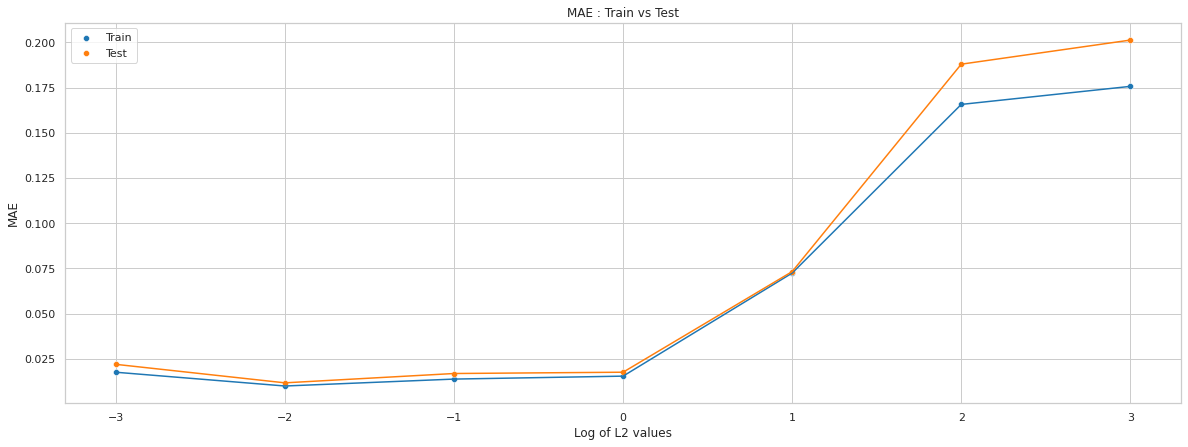

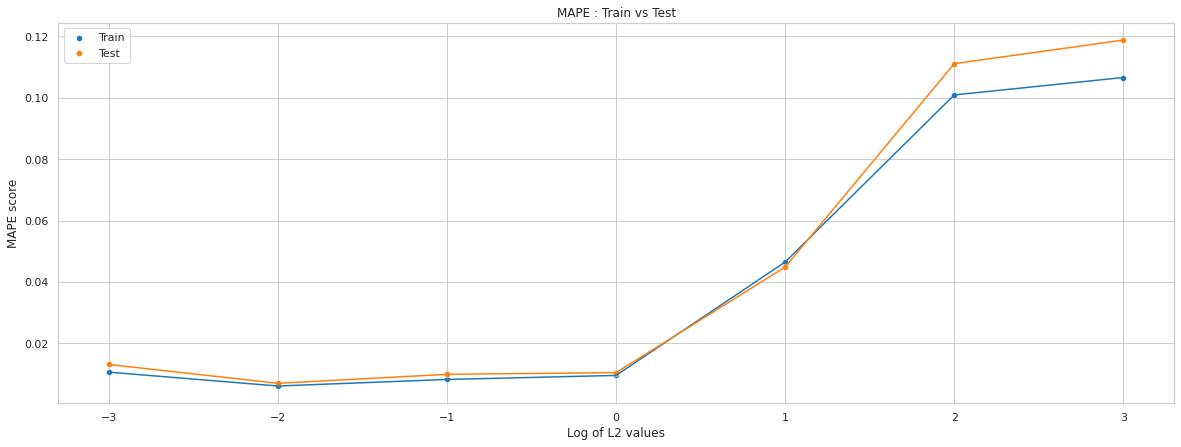

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log10(L2), y=train_MAE, label='Train')
plt.plot(np.log10(L2), train_MAE)
sns.scatterplot(x=np.log10(L2), y=test_MAE, label='Test')
plt.plot(np.log10(L2),test_MAE)
plt.xlabel('Log of L2 values')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log10(L2), y=train_MAPE, label='Train')
plt.plot(np.log10(L2), train_MAPE)
sns.scatterplot(x=np.log10(L2), y=test_MAPE, label='Test')
plt.plot(np.log10(L2),test_MAPE)
plt.legend()
plt.xlabel('Log of L2 values')
plt.ylabel('MAPE score')
plt.title('MAPE : Train vs Test')
plt.show()

* Similar to SGD, for lower values of C, error is significantly lower.
* Best parameter seems to be for alpha value of 0.1 and test MAE is  0.05093
* This MAE is worse than original dataset MAE of 0.013948

In [ ]:
model_results.add_row(Results.rows[2])

## Decision tree regressor

In [ ]:
depth = [2,3,5,6]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for d in depth:
  DT = DecisionTreeRegressor(max_depth=d)
  DT.fit(X_train, y_train)
  train_pred = DT.predict(X_train)
  test_pred = DT.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameter - Max depth", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,d in enumerate(depth):
  Results.add_row([d, 'DT-Regressor', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+----------------------------+--------------+-----------------------+----------------------+-----------------------+-----------------------+
| Hyperparameter - Max depth |    Model     |       Train MAE       |       Test MAE       |       Train MAPE      |       Test MAPE       |
+----------------------------+--------------+-----------------------+----------------------+-----------------------+-----------------------+
|             2              | DT-Regressor |  0.03376504192390205  | 0.03612827376834209  |  0.022238025797121558 |  0.022816534813018114 |
|             3              | DT-Regressor |  0.014641448694341907 | 0.01785599937008649  |  0.009602252181193361 |  0.011427192317350574 |
|             5              | DT-Regressor |  0.003873262441700211 | 0.009543529486327994 | 0.0025682476421725587 |  0.005790118137668789 |
|             6              | DT-Regressor | 0.0018784459359904315 | 0.011223387977266535 | 0.0012493452878919633 | 0.0064623980875703705 |
+------------

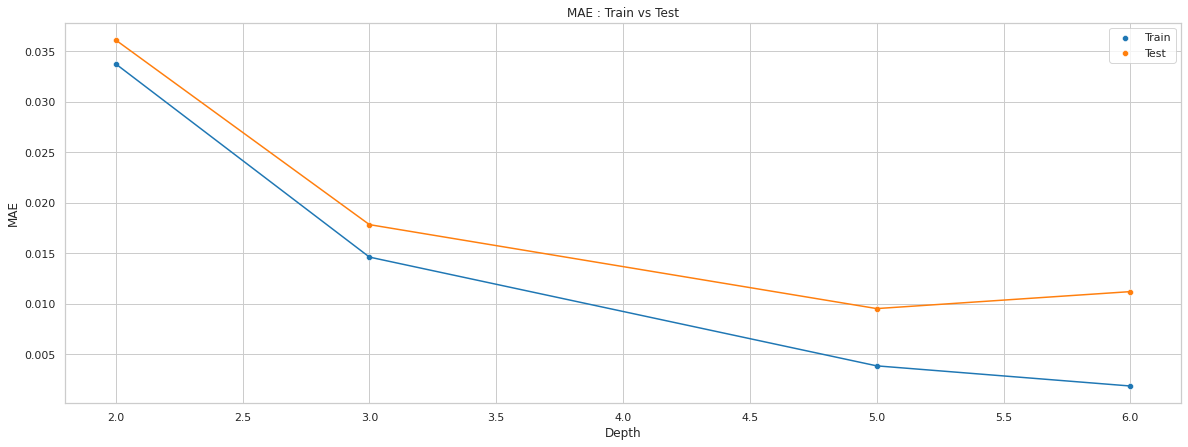

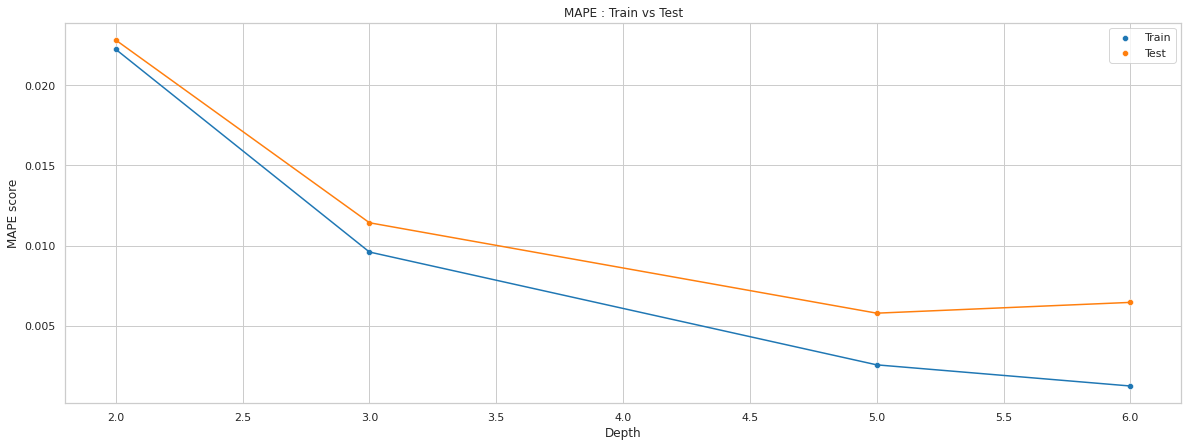

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=depth, y=train_MAE, label='Train')
plt.plot(depth, train_MAE)
sns.scatterplot(x=depth, y=test_MAE, label='Test')
plt.plot(depth,test_MAE)
plt.xlabel('Depth')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(depth, y=train_MAPE, label='Train')
plt.plot(depth, train_MAPE)
sns.scatterplot(x=depth, y=test_MAPE, label='Test')
plt.plot(depth,test_MAPE)
plt.legend()
plt.xlabel('Depth')
plt.ylabel('MAPE score')
plt.title('MAPE : Train vs Test')
plt.show()

* For higher values of max_depth, error is low.
* Best parameter seems to be for depth value of 5 and test MAE is 0.00641
* MAE is significantly lesser than MAE from original dataset with MAE 0.01124

In [ ]:
model_results.add_row(Results.rows[2])

## Adaboost Regression

In [ ]:
n_estimators = [20,30,50,60]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for n in n_estimators:
  ABD = AdaBoostRegressor(n_estimators=n)
  ABD.fit(X_train, y_train)
  train_pred = ABD.predict(X_train)
  test_pred = ABD.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameter - n_estimators", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,d in enumerate(n_estimators):
  Results.add_row([d, 'ADB Regressor', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+-------------------------------+---------------+----------------------+----------------------+----------------------+----------------------+
| Hyperparameter - n_estimators |     Model     |      Train MAE       |       Test MAE       |      Train MAPE      |      Test MAPE       |
+-------------------------------+---------------+----------------------+----------------------+----------------------+----------------------+
|               20              | ADB Regressor | 0.008059395925066697 | 0.010332354638777541 | 0.005339097734209229 | 0.006483971533946237 |
|               30              | ADB Regressor | 0.007536446699483283 | 0.009649501399924987 | 0.004925997708396535 | 0.006059408264551663 |
|               50              | ADB Regressor | 0.010660955590014455 | 0.013109672561155571 | 0.007040207711524264 |  0.0083595539148139  |
|               60              | ADB Regressor | 0.008892342413043857 |  0.0109790596814748  | 0.005846828059916918 | 0.006961898687161312 |
+-----

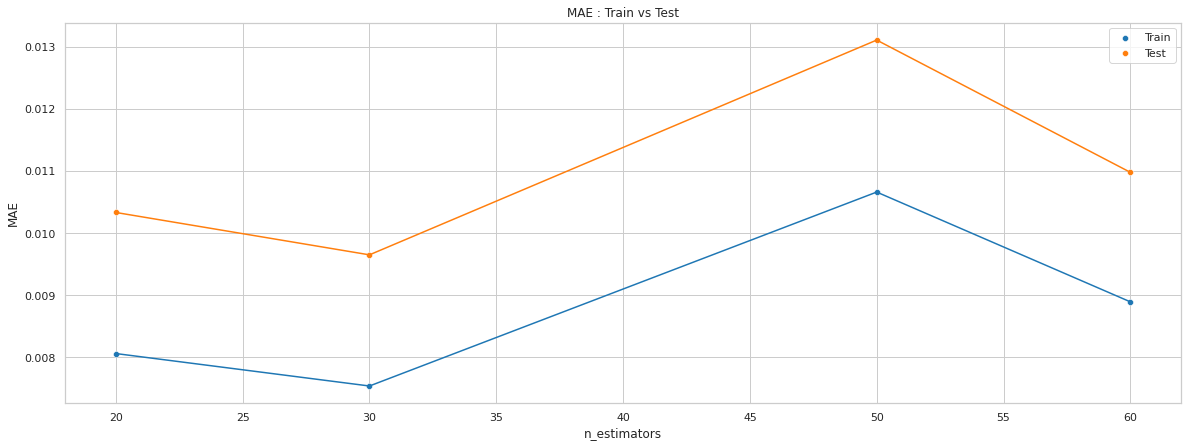

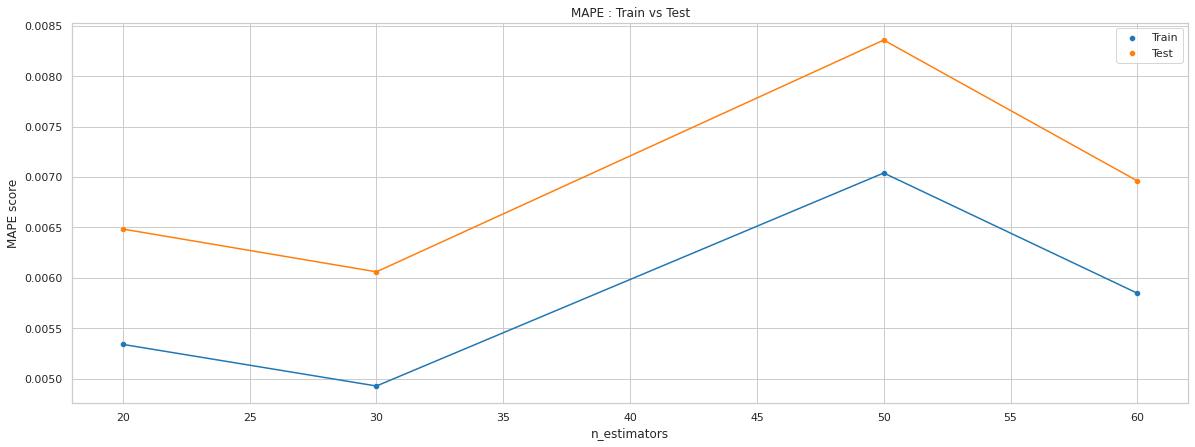

In [ ]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=n_estimators, y=train_MAE, label='Train')
plt.plot(n_estimators, train_MAE)
sns.scatterplot(x=n_estimators, y=test_MAE, label='Test')
plt.plot(n_estimators,test_MAE)
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(n_estimators, y=train_MAPE, label='Train')
plt.plot(n_estimators, train_MAPE)
sns.scatterplot(x=n_estimators, y=test_MAPE, label='Test')
plt.plot(n_estimators,test_MAPE)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('MAPE score')
plt.title('MAPE : Train vs Test')
plt.show()


* Variation of error with n_estimators is slightly less
* Best parameter seems to be for n_estimators of 50  and test MAE is 0.0096 
* The MAE is lesser than MAE of original dataset with MAE of 0.01013

In [ ]:
model_results.add_row(Results.rows[2])

## Random Forest Regressor

In [ ]:
n_estimators = [20,40,100]
depth = [2,3,5]
params = [[n,d] for n in n_estimators for d in depth]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for p in params:
  RF = RandomForestRegressor(n_estimators=p[0], max_depth=p[1])
  RF.fit(X_train, y_train)
  train_pred = RF.predict(X_train)
  test_pred = RF.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))

In [ ]:
Results = PrettyTable(["Hyperparameters - n_est, depth", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,d in enumerate(params):
  Results.add_row([d, 'RF Regressor', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+--------------------------------+--------------+-----------------------+----------------------+-----------------------+-----------------------+
| Hyperparameters - n_est, depth |    Model     |       Train MAE       |       Test MAE       |       Train MAPE      |       Test MAPE       |
+--------------------------------+--------------+-----------------------+----------------------+-----------------------+-----------------------+
|            [20, 2]             | RF Regressor |   0.0302753661483189  | 0.03043989417272459  |  0.019808540808012125 |  0.01912661346367254  |
|            [20, 3]             | RF Regressor |   0.0115943831640254  | 0.014955930810632064 |  0.007536019349036661 |  0.009418696393257488 |
|            [20, 5]             | RF Regressor |  0.00207691116080666  | 0.006747611622445007 | 0.0013734282201448283 |  0.004048220298312296 |
|            [40, 2]             | RF Regressor |  0.031188246252995065 | 0.032064464899572896 |   0.0204557858746605  |  0.020139

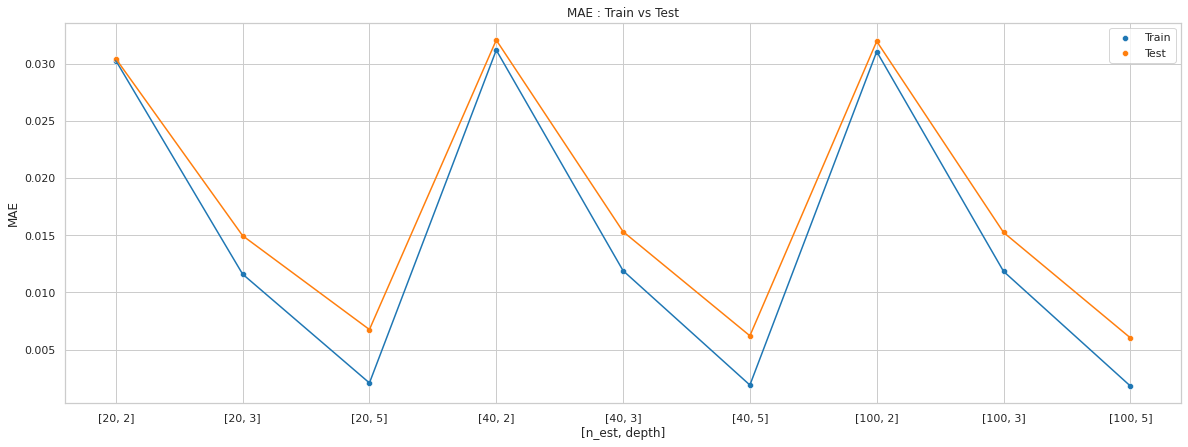

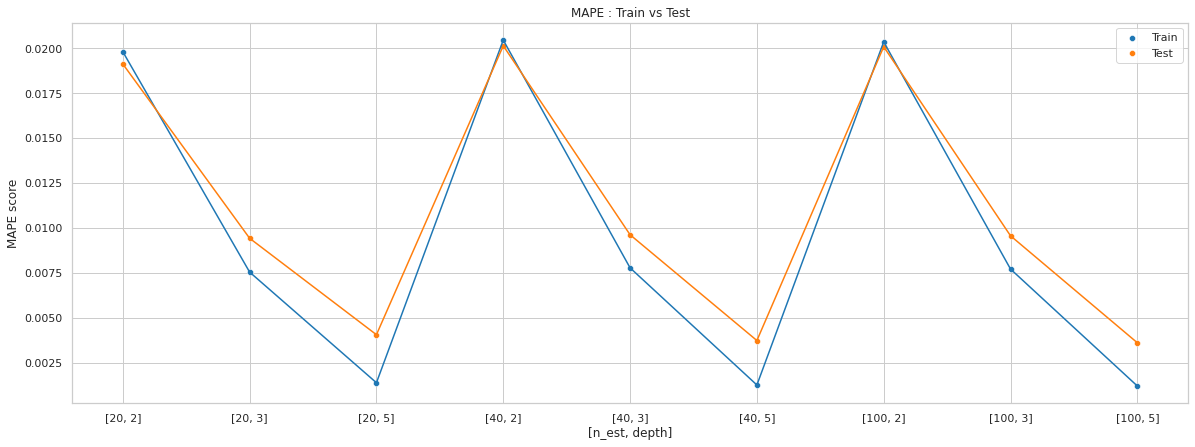

In [ ]:
plt.figure(figsize=(20,7))
param_list = np.arange(len(params))
sns.scatterplot(x=param_list, y=train_MAE, label='Train')
plt.plot(param_list, train_MAE)
sns.scatterplot(x=param_list, y=test_MAE, label='Test')
plt.plot(param_list,test_MAE)
plt.xticks(param_list, [str(p) for p in params])
plt.xlabel('[n_est, depth]')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(param_list, y=train_MAPE, label='Train')
plt.plot(param_list, train_MAPE)
sns.scatterplot(x=param_list, y=test_MAPE, label='Test')
plt.plot(param_list,test_MAPE)
plt.xticks(param_list, [str(p) for p in params])
plt.legend()
plt.xlabel('[n_est, depth]')
plt.ylabel('MAPE score')
plt.title('MAPE : Train vs Test')
plt.show()


* Depth parameter has significant effect than estimators.
* Best parameters seems to be for n_estimators of 40, depth of 5 and test MAE is 0.00584 
* The MAE is better than (but close to) that of original dataset with MAE 0.008015

In [ ]:
model_results.add_row(Results.rows[5])

## GBDT Regression


In [ ]:
n_estimators = [5,10,20]
depth = [2,3,5]
params = [[n,d] for n in n_estimators for d in depth]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for p in params:
  GBDT = GradientBoostingRegressor(n_estimators=p[0], max_depth=p[1])
  GBDT.fit(X_train, y_train)
  train_pred = GBDT.predict(X_train)
  test_pred = GBDT.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameters - n_est, depth", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,d in enumerate(params):
  Results.add_row([d, 'GBDT Regressor', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+--------------------------------+----------------+----------------------+----------------------+----------------------+----------------------+
| Hyperparameters - n_est, depth |     Model      |      Train MAE       |       Test MAE       |      Train MAPE      |      Test MAPE       |
+--------------------------------+----------------+----------------------+----------------------+----------------------+----------------------+
|             [5, 2]             | GBDT Regressor | 0.10443426049512207  | 0.10254651329761645  |  0.068189388103179   | 0.06365258025514484  |
|             [5, 3]             | GBDT Regressor |  0.1027961591630255  | 0.10138288300131125  | 0.06705741428783417  | 0.06297310225240527  |
|             [5, 5]             | GBDT Regressor | 0.10212009396669323  | 0.10067124913390796  | 0.06660465006371451  | 0.062484225997672165 |
|            [10, 2]             | GBDT Regressor | 0.06267041837405365  | 0.06315357905239012  | 0.04096005477554023  | 0.0391545800710

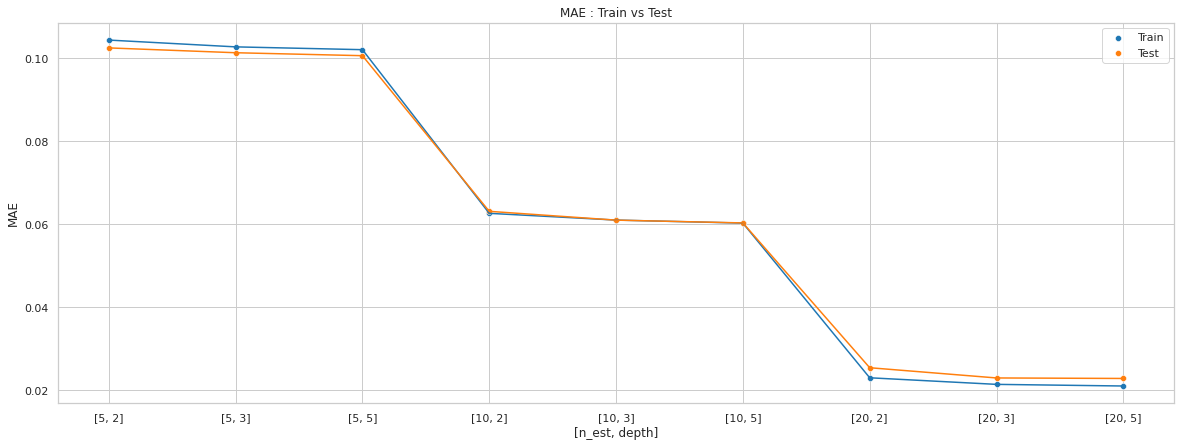

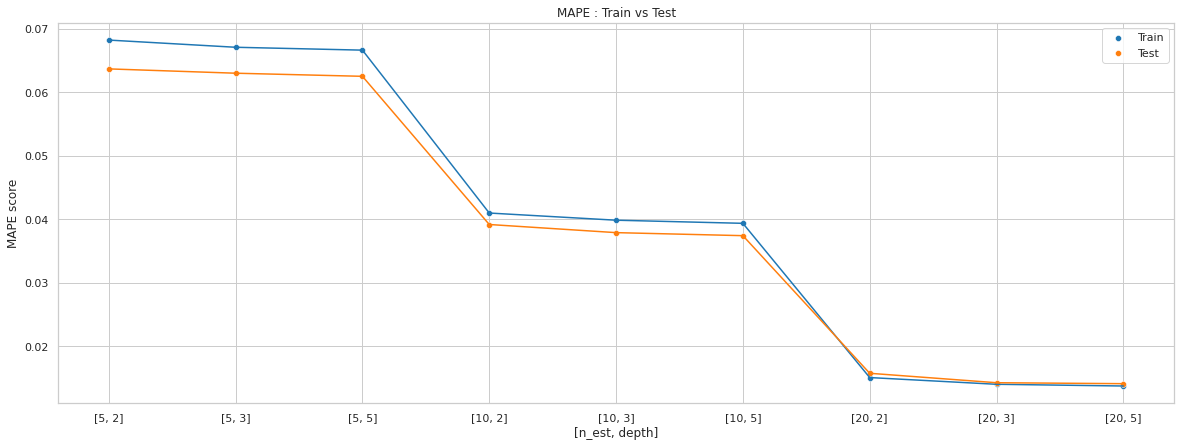

In [ ]:
plt.figure(figsize=(20,7))
param_list = np.arange(len(params))
sns.scatterplot(x=param_list, y=train_MAE, label='Train')
plt.plot(param_list, train_MAE)
sns.scatterplot(x=param_list, y=test_MAE, label='Test')
plt.plot(param_list,test_MAE)
plt.xticks(param_list, [str(p) for p in params])
plt.xlabel('[n_est, depth]')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(param_list, y=train_MAPE, label='Train')
plt.plot(param_list, train_MAPE)
sns.scatterplot(x=param_list, y=test_MAPE, label='Test')
plt.plot(param_list,test_MAPE)
plt.xticks(param_list, [str(p) for p in params])
plt.legend()
plt.xlabel('[n_est, depth]')
plt.ylabel('MAPE score')
plt.title('MAPE : Train vs Test')
plt.show()


* estimators parameter has significant effect than Depth.
* Best parameters seems to be for n_estimators of 20, depth of 5 and test MAE is 0.02227
* The MAE of GBDT is significantly higher than DT and Random Forests
* MAE of original dataset and current dataset are also close 

In [ ]:
model_results.add_row(Results.rows[-1])

## LGBM

In [ ]:
fraction = [0.6, 1]
depth = [2,3,5,-1]
params = [[f,d] for f in fraction for d in depth]
train_MAE = []
test_MAE = []
train_MAPE = []
test_MAPE = []

for p in params:
  GBDT = lgb.LGBMRegressor(feature_fraction = p[0],max_depth=p[1],random_state=42)
  GBDT.fit(X_train, y_train)
  train_pred = GBDT.predict(X_train)
  test_pred = GBDT.predict(X_test)
  train_MAE.append(mean_absolute_error(y_train,train_pred))
  test_MAE.append(mean_absolute_error(y_test, test_pred))
  train_MAPE.append(mean_absolute_percentage_error(y_train,train_pred))
  test_MAPE.append(mean_absolute_percentage_error(y_test,test_pred))


In [ ]:
Results = PrettyTable(["Hyperparameters - n_est, depth", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

for i,d in enumerate(params):
  Results.add_row([d, 'LGBM', train_MAE[i], test_MAE[i], train_MAPE[i], test_MAPE[i]])

print(Results)

+--------------------------------+-------+-----------------------+-----------------------+------------------------+-----------------------+
| Hyperparameters - n_est, depth | Model |       Train MAE       |        Test MAE       |       Train MAPE       |       Test MAPE       |
+--------------------------------+-------+-----------------------+-----------------------+------------------------+-----------------------+
|            [0.6, 2]            |  LGBM | 0.0015024737097457557 |  0.006013667235631699 | 0.0009818066062492173  | 0.0036638286750742067 |
|            [0.6, 3]            |  LGBM | 0.0008169610940201539 |  0.005977872771860904 | 0.0005336035637581034  |  0.003637523806748682 |
|            [0.6, 5]            |  LGBM | 0.0003879218563163858 |  0.006027489572230464 | 0.0002513027315713661  | 0.0035822201782056725 |
|           [0.6, -1]            |  LGBM | 0.0003138587419501906 | 0.0058872226416004135 |  0.000202715537542846  |  0.003482245361253201 |
|             [1, 2]

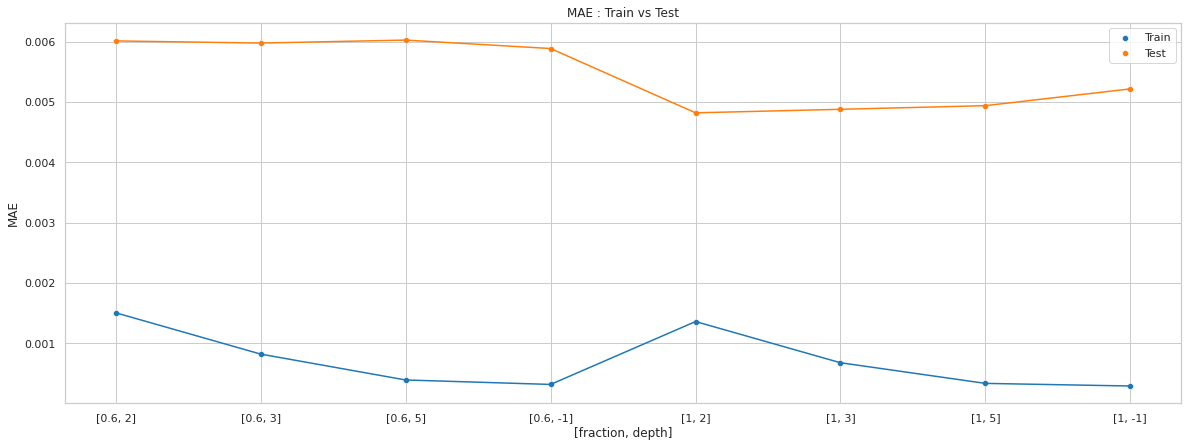

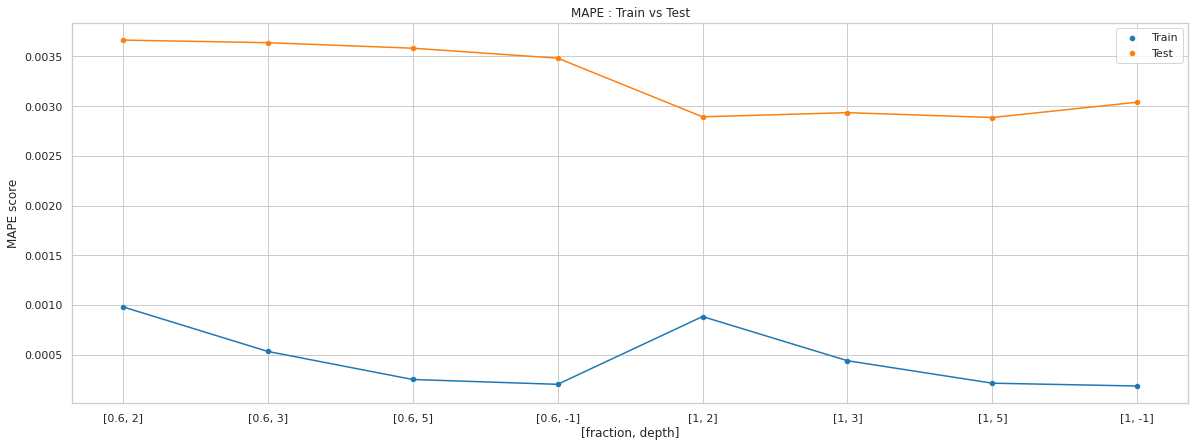

In [ ]:
plt.figure(figsize=(20,7))
param_list = np.arange(len(params))
sns.scatterplot(x=param_list, y=train_MAE, label='Train')
plt.plot(param_list, train_MAE)
sns.scatterplot(x=param_list, y=test_MAE, label='Test')
plt.plot(param_list,test_MAE)
plt.xticks(param_list, [str(p) for p in params])
plt.xlabel('[fraction, depth]')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
sns.scatterplot(param_list, y=train_MAPE, label='Train')
plt.plot(param_list, train_MAPE)
sns.scatterplot(x=param_list, y=test_MAPE, label='Test')
plt.plot(param_list,test_MAPE)
plt.xticks(param_list, [str(p) for p in params])
plt.legend()
plt.xlabel('[fraction, depth]')
plt.ylabel('MAPE score')
plt.title('MAPE : Train vs Test')
plt.show()


* estimators parameter has significant effect than Depth.
* Best parameters seems to be for fraction of 1, depth of 2 and test MAE is 0.00482
* The MAE of LGBM is significantly better than Sklearn GBDT

In [ ]:
model_results.add_row(Results.rows[4])

## Results

In [ ]:
model_interp = model_results
print(model_results)

+---------------------+----------------+-----------------------+----------------------+-----------------------+-----------------------+
| Hyperparameter - L2 |     Model      |       Train MAE       |       Test MAE       |       Train MAPE      |       Test MAPE       |
+---------------------+----------------+-----------------------+----------------------+-----------------------+-----------------------+
|         0.01        |      SGD       |  0.006388196187740755 | 0.007630511475526216 |   0.0041076485464798  |  0.004578347759386464 |
|          1          |      SVM       |   0.0644774628607577  | 0.06126071828042421  |  0.04268739380316949  |  0.038614298988151996 |
|         0.1         |     RANSAC     |  0.013776105383898736 | 0.016860051432055788 |  0.008262568074490786 |  0.009938078178279172 |
|          5          |  DT-Regressor  |  0.003873262441700211 | 0.009543529486327994 | 0.0025682476421725587 |  0.005790118137668789 |
|          50         | ADB Regressor  |  0.0106

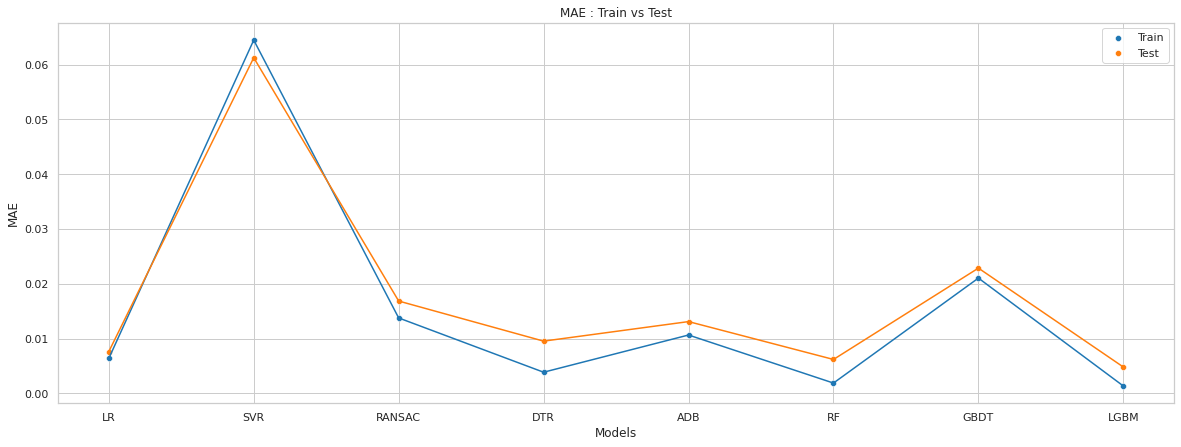

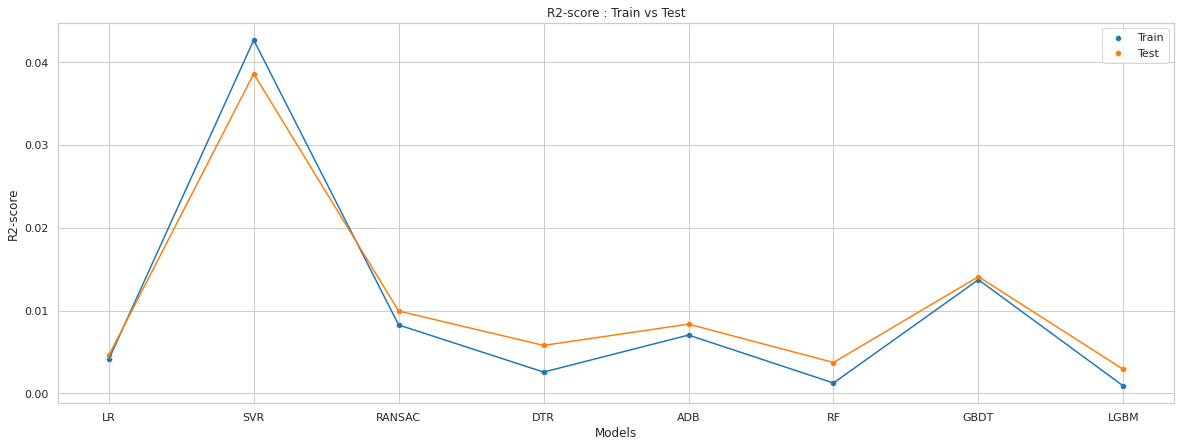

In [ ]:
table = np.array(model_results.rows)

model_list = ['LR', 'SVR', 'RANSAC', 'DTR', 'ADB', 'RF', 'GBDT', 'LGBM']
plt.figure(figsize=(20,7))
param_list = np.arange(len(model_list))
sns.scatterplot(x=param_list, y=table[:,2].astype('float'), label='Train')
plt.plot(param_list, table[:,2].astype('float'))
sns.scatterplot(x=param_list, y=table[:,3].astype('float'), label='Test')
plt.plot(param_list,table[:,3].astype('float'))
plt.xticks(param_list, [str(p) for p in model_list])
plt.xlabel('Models')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE : Train vs Test')
plt.show()

plt.figure(figsize=(20,7))
param_list = np.arange(len(model_list))
sns.scatterplot(x=param_list, y=table[:,4].astype('float'), label='Train')
plt.plot(param_list, table[:,4].astype('float'))
sns.scatterplot(x=param_list, y=table[:,5].astype('float'), label='Test')
plt.plot(param_list,table[:,5].astype('float'))
plt.xticks(param_list, [str(p) for p in model_list])
plt.xlabel('Models')
plt.ylabel('R2-score')
plt.legend()
plt.title('R2-score : Train vs Test')
plt.show()

* From the above data, it can be understood that LGBM has least MAE in comparision to other models. 
* Closest to LGBM is Random forest model and Decision tree model. 
* Linear regression is also close to the best value of MAE from LGBM

# Custom stacking model

```
Custom Stacking classifier:

a) Split your whole data into train and test(80-20)

b) Now, in the 80% train set, split the train set into D1 and D2.(50-50).

From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).

Now create 'k' models and train each of these models with the samples. Each model will be trained on only one sample. These models are called base models. We can select the best models and its hyperparameters based on the previous findings. Make sure that ‘k’ can be passed as an argument. 

c) Now pass the D2 set to each of these k models; now, you will get k predictions for D2 from each of these models.

d) Now, using these k predictions, create a new dataset, for D2, you already know it's corresponding target values, so now you train a metamodel with these k predictions.

e) Now, for model evaluation, you can use the 20% data that you have kept as the test set. Pass that test set to each of the base models, and you will get 'k' predictions. Now you create a new dataset with these k predictions and pass it to your metamodel, and you will get the final prediction. Using this final prediction and the targets for the test set, you can calculate the model's performance score.



* MAE gives us the average difference of of predictions from actual values. Since the difference is absolute without any transformations as in RMSE, the output prediction which is cell capacity, is more intuitive to grasp.
* Irrespective of scale of the predictor variable, Regression model performance should be understandable when evaluation metrics are analysed. a MAE value of 0.0034 does not make any sense unless the scale of predictor variable is a prior knowledge. MAPE helps overcome this problem by providing a percentage error in prediction instead of error directly. 
* The statement "Model predicts with 2% error" is intuitive and comparable than the statement "Model  predicts with 0.0034 MAE". The former statement inherently combines scale of the predictior inorder to produce the metric.

## Data split

In [ ]:
# Split-1 
# X_train, X_test

# Split-2
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.5, random_state=13, shuffle=True)

print('X_Train_1 shape = ', X_train_1.shape)
print('X_Test shape = ', X_train_2.shape)

X_Train_1 shape =  (510, 17)
X_Test shape =  (510, 17)


In [ ]:
model_results = PrettyTable(["Hyperparameter - L2", "Model", "Train MAE", "Test MAE", "Train MAPE", "Test MAPE"])

## Custom model

### Fixed Base model Hyperparameters

In [ ]:
class Custom_model:
  def __init__(self, sample_k, sample_size):
    """
    Parameters:
      sample_k- No of base models 
      sample_size- No of data samples per base model
    """
    self.k = sample_k
    self.sample_size = sample_size

  def sample(self, X, sample_size):
    """
    Parameters:
      X- data
      sample_size- size of samples from X
    Returns:
      data after sampling from X
    """
    return np.random.choice(X, size=sample_size, replace=True)

  def get_model(self):
    """
    Returns:
      Initializes and returns a sklearn model object
    """
    m_id = np.random.randint(0,5)
    if m_id == 0:
      return lgb.LGBMRegressor(feature_fraction = 1,max_depth=2,random_state=np.random.randint(0,1000))
    elif m_id == 1:
      return RandomForestRegressor(n_estimators=40, max_depth=5,random_state=np.random.randint(0,1000))
    elif m_id == 2: 
      return AdaBoostRegressor(n_estimators=50,random_state=np.random.randint(0,1000))
    elif m_id == 3:
      return DecisionTreeRegressor(max_depth=5,random_state=np.random.randint(0,1000))
    else:
      return SGDRegressor(loss='squared_error', penalty='l2', alpha=0.01,random_state=np.random.randint(0,1000))

  def fit(self, D1_x,D2_x, D1_y, D2_y):
    """
    Parameters:
      D1_x, D1_y : D1 part of the data to train base models
      D2_x, D2_y : D2 part of the data to train meta model
    """
    # Sampling base models and data indices
    self.K_IDs = [self.sample(D1_x.index.tolist(), self.sample_size) for _ in  range(self.k)]
    self.base_models = [self.get_model() for _ in range(self.k)]
    print('Training Base models')
    for i in (range(self.k)):
      D1_x_i = D1_x.loc[self.K_IDs[i]]
      D1_y_i = D1_y.loc[self.K_IDs[i]]
      self.base_models[i].fit(D1_x_i, D1_y_i)

    # Input for meta model
    self.meta_data_x = pd.DataFrame()
    for i in range(self.k):
      preds = pd.DataFrame(self.base_models[i].predict(D2_x),columns=['input_'+str(i)])
      self.meta_data_x = pd.concat([self.meta_data_x,preds], axis=1, ignore_index = True)
    self.meta_data_y = D2_y

    print('Training Meta model')
    self.meta_model = RandomForestRegressor(n_estimators=40, max_depth=None)
    self.meta_model.fit(self.meta_data_x, self.meta_data_y)
    print('Done')

  def predict(self, data):
    """
    Parameters:
      data: Test data to predit
    Returns:
      predicted data
    """
    meta_data_input = pd.DataFrame()
    for i in range(self.k):
      preds = pd.DataFrame(self.base_models[i].predict(data),columns=['input'])
      meta_data_input = pd.concat([meta_data_input,preds], axis=1, ignore_index = True)
    meta_pred = self.meta_model.predict(meta_data_input)
    return meta_pred

model = Custom_model(512, 64)
model.fit(X_train_1, X_train_2, y_train_1, y_train_2)
y_test_pred = model.predict(X_test)
mean_absolute_error(y_test,y_test_pred)

Training Base models
Training Meta model
Done


0.0073052965629738734

* Since random sampling of datapoints are performed in the custom model, there is a slight difference in metrics everytime a model is trained. 
* So inorder to understand the variation of metrics of the model, model is trained multiple times to obtain distribution of performance metrics so that the range of MAE and MAPE can be observed

In [ ]:
mae = []
mape = []
for _ in tqdm(range(500)):
  model = Custom_model(64, 64)
  model.fit(X_train_1, X_train_2, y_train_1, y_train_2)
  y_test_pred = model.predict(X_test)
  mae.append(mean_absolute_error(y_test,y_test_pred))
  mape.append(mean_absolute_percentage_error(y_test,y_test_pred))

  0%|          | 0/500 [00:00<?, ?it/s]

Training Base models
Training Meta model


  0%|          | 1/500 [00:02<24:31,  2.95s/it]

Done
Training Base models
Training Meta model


  0%|          | 2/500 [00:05<21:55,  2.64s/it]

Done
Training Base models
Training Meta model
Done


  1%|          | 3/500 [00:08<22:40,  2.74s/it]

Training Base models
Training Meta model


  1%|          | 4/500 [00:10<22:20,  2.70s/it]

Done
Training Base models
Training Meta model


  1%|          | 5/500 [00:13<22:09,  2.69s/it]

Done
Training Base models
Training Meta model


  1%|          | 6/500 [00:16<22:51,  2.78s/it]

Done
Training Base models
Training Meta model


  1%|▏         | 7/500 [00:19<22:44,  2.77s/it]

Done
Training Base models
Training Meta model


  2%|▏         | 8/500 [00:21<22:37,  2.76s/it]

Done
Training Base models
Training Meta model
Done


  2%|▏         | 9/500 [00:25<24:19,  2.97s/it]

Training Base models
Training Meta model


  2%|▏         | 10/500 [00:28<24:13,  2.97s/it]

Done
Training Base models
Training Meta model


  2%|▏         | 11/500 [00:30<23:02,  2.83s/it]

Done
Training Base models
Training Meta model


  2%|▏         | 12/500 [00:33<23:29,  2.89s/it]

Done
Training Base models
Training Meta model


  3%|▎         | 13/500 [00:36<22:54,  2.82s/it]

Done
Training Base models
Training Meta model
Done


  3%|▎         | 14/500 [00:39<23:16,  2.87s/it]

Training Base models
Training Meta model
Done


  3%|▎         | 15/500 [00:42<23:14,  2.87s/it]

Training Base models
Training Meta model


  3%|▎         | 16/500 [00:44<22:13,  2.76s/it]

Done
Training Base models
Training Meta model


  3%|▎         | 17/500 [00:47<22:43,  2.82s/it]

Done
Training Base models
Training Meta model
Done


  4%|▎         | 18/500 [00:50<22:27,  2.80s/it]

Training Base models
Training Meta model
Done


  4%|▍         | 19/500 [00:53<22:42,  2.83s/it]

Training Base models
Training Meta model
Done


  4%|▍         | 20/500 [00:56<23:49,  2.98s/it]

Training Base models
Training Meta model


  4%|▍         | 21/500 [00:59<23:15,  2.91s/it]

Done
Training Base models
Training Meta model
Done


  4%|▍         | 22/500 [01:03<24:21,  3.06s/it]

Training Base models
Training Meta model
Done


  5%|▍         | 23/500 [01:05<24:03,  3.03s/it]

Training Base models
Training Meta model


  5%|▍         | 24/500 [01:08<23:16,  2.93s/it]

Done
Training Base models
Training Meta model


  5%|▌         | 25/500 [01:11<21:56,  2.77s/it]

Done
Training Base models
Training Meta model


  5%|▌         | 26/500 [01:13<20:51,  2.64s/it]

Done
Training Base models
Training Meta model


  5%|▌         | 27/500 [01:15<20:34,  2.61s/it]

Done
Training Base models
Training Meta model


  6%|▌         | 28/500 [01:18<20:25,  2.60s/it]

Done
Training Base models
Training Meta model


  6%|▌         | 29/500 [01:20<19:46,  2.52s/it]

Done
Training Base models
Training Meta model


  6%|▌         | 30/500 [01:23<20:12,  2.58s/it]

Done
Training Base models
Training Meta model
Done


  6%|▌         | 31/500 [01:26<21:36,  2.77s/it]

Training Base models
Training Meta model


  6%|▋         | 32/500 [01:29<21:22,  2.74s/it]

Done
Training Base models
Training Meta model
Done


  7%|▋         | 33/500 [01:32<21:44,  2.79s/it]

Training Base models
Training Meta model


  7%|▋         | 34/500 [01:35<21:16,  2.74s/it]

Done
Training Base models
Training Meta model


  7%|▋         | 35/500 [01:38<21:51,  2.82s/it]

Done
Training Base models
Training Meta model


  7%|▋         | 36/500 [01:40<22:03,  2.85s/it]

Done
Training Base models
Training Meta model


  7%|▋         | 37/500 [01:43<22:28,  2.91s/it]

Done
Training Base models
Training Meta model


  8%|▊         | 38/500 [01:46<21:01,  2.73s/it]

Done
Training Base models
Training Meta model


  8%|▊         | 39/500 [01:49<21:18,  2.77s/it]

Done
Training Base models
Training Meta model


  8%|▊         | 40/500 [01:52<21:26,  2.80s/it]

Done
Training Base models
Training Meta model
Done


  8%|▊         | 41/500 [01:54<21:22,  2.80s/it]

Training Base models
Training Meta model


  8%|▊         | 42/500 [01:57<21:39,  2.84s/it]

Done
Training Base models
Training Meta model
Done


  9%|▊         | 43/500 [02:00<22:16,  2.92s/it]

Training Base models
Training Meta model
Done


  9%|▉         | 44/500 [02:03<22:38,  2.98s/it]

Training Base models
Training Meta model


  9%|▉         | 45/500 [02:06<21:58,  2.90s/it]

Done
Training Base models
Training Meta model


  9%|▉         | 46/500 [02:09<21:51,  2.89s/it]

Done
Training Base models
Training Meta model


  9%|▉         | 47/500 [02:12<21:10,  2.81s/it]

Done
Training Base models
Training Meta model
Done


 10%|▉         | 48/500 [02:15<22:04,  2.93s/it]

Training Base models
Training Meta model


 10%|▉         | 49/500 [02:18<21:35,  2.87s/it]

Done
Training Base models
Training Meta model


 10%|█         | 50/500 [02:20<21:29,  2.86s/it]

Done
Training Base models
Training Meta model


 10%|█         | 51/500 [02:23<20:11,  2.70s/it]

Done
Training Base models
Training Meta model


 10%|█         | 52/500 [02:25<20:05,  2.69s/it]

Done
Training Base models
Training Meta model


 11%|█         | 53/500 [02:28<19:59,  2.68s/it]

Done
Training Base models
Training Meta model


 11%|█         | 54/500 [02:31<20:19,  2.74s/it]

Done
Training Base models
Training Meta model


 11%|█         | 55/500 [02:34<20:29,  2.76s/it]

Done
Training Base models
Training Meta model


 11%|█         | 56/500 [02:37<20:18,  2.74s/it]

Done
Training Base models
Training Meta model


 11%|█▏        | 57/500 [02:39<20:12,  2.74s/it]

Done
Training Base models
Training Meta model


 12%|█▏        | 58/500 [02:42<20:36,  2.80s/it]

Done
Training Base models
Training Meta model


 12%|█▏        | 59/500 [02:45<20:44,  2.82s/it]

Done
Training Base models
Training Meta model
Done


 12%|█▏        | 60/500 [02:48<21:18,  2.91s/it]

Training Base models
Training Meta model


 12%|█▏        | 61/500 [02:51<21:28,  2.93s/it]

Done
Training Base models
Training Meta model


 12%|█▏        | 62/500 [02:54<21:45,  2.98s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 63/500 [02:57<20:27,  2.81s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 64/500 [02:59<20:06,  2.77s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 65/500 [03:02<19:57,  2.75s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 66/500 [03:05<19:47,  2.74s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 67/500 [03:07<18:53,  2.62s/it]

Done
Training Base models
Training Meta model


 14%|█▎        | 68/500 [03:10<19:02,  2.65s/it]

Done
Training Base models
Training Meta model


 14%|█▍        | 69/500 [03:12<18:28,  2.57s/it]

Done
Training Base models
Training Meta model
Done


 14%|█▍        | 70/500 [03:15<19:19,  2.70s/it]

Training Base models
Training Meta model
Done


 14%|█▍        | 71/500 [03:18<20:06,  2.81s/it]

Training Base models
Training Meta model


 14%|█▍        | 72/500 [03:21<20:08,  2.82s/it]

Done
Training Base models
Training Meta model
Done


 15%|█▍        | 73/500 [03:24<20:27,  2.87s/it]

Training Base models
Training Meta model


 15%|█▍        | 74/500 [03:27<20:18,  2.86s/it]

Done
Training Base models
Training Meta model


 15%|█▌        | 75/500 [03:30<20:03,  2.83s/it]

Done
Training Base models
Training Meta model


 15%|█▌        | 76/500 [03:32<19:36,  2.77s/it]

Done
Training Base models
Training Meta model


 15%|█▌        | 77/500 [03:35<19:46,  2.80s/it]

Done
Training Base models
Training Meta model


 16%|█▌        | 78/500 [03:38<19:04,  2.71s/it]

Done
Training Base models
Training Meta model


 16%|█▌        | 79/500 [03:41<19:27,  2.77s/it]

Done
Training Base models
Training Meta model


 16%|█▌        | 80/500 [03:44<19:50,  2.84s/it]

Done
Training Base models
Training Meta model


 16%|█▌        | 81/500 [03:46<19:10,  2.74s/it]

Done
Training Base models
Training Meta model


 16%|█▋        | 82/500 [03:49<18:50,  2.70s/it]

Done
Training Base models
Training Meta model


 17%|█▋        | 83/500 [03:51<18:16,  2.63s/it]

Done
Training Base models
Training Meta model
Done


 17%|█▋        | 84/500 [03:54<18:41,  2.70s/it]

Training Base models
Training Meta model


 17%|█▋        | 85/500 [03:57<18:18,  2.65s/it]

Done
Training Base models
Training Meta model
Done


 17%|█▋        | 86/500 [04:00<19:43,  2.86s/it]

Training Base models
Training Meta model


 17%|█▋        | 87/500 [04:03<19:08,  2.78s/it]

Done
Training Base models
Training Meta model


 18%|█▊        | 88/500 [04:05<19:12,  2.80s/it]

Done
Training Base models
Training Meta model


 18%|█▊        | 89/500 [04:08<19:11,  2.80s/it]

Done
Training Base models
Training Meta model
Done


 18%|█▊        | 90/500 [04:11<19:44,  2.89s/it]

Training Base models
Training Meta model


 18%|█▊        | 91/500 [04:14<19:20,  2.84s/it]

Done
Training Base models
Training Meta model


 18%|█▊        | 92/500 [04:17<19:24,  2.85s/it]

Done
Training Base models
Training Meta model


 19%|█▊        | 93/500 [04:19<18:49,  2.78s/it]

Done
Training Base models
Training Meta model


 19%|█▉        | 94/500 [04:22<19:06,  2.82s/it]

Done
Training Base models
Training Meta model


 19%|█▉        | 95/500 [04:25<18:22,  2.72s/it]

Done
Training Base models
Training Meta model


 19%|█▉        | 96/500 [04:28<18:44,  2.78s/it]

Done
Training Base models
Training Meta model


 19%|█▉        | 97/500 [04:31<18:39,  2.78s/it]

Done
Training Base models
Training Meta model


 20%|█▉        | 98/500 [04:33<17:57,  2.68s/it]

Done
Training Base models
Training Meta model


 20%|█▉        | 99/500 [04:36<18:12,  2.73s/it]

Done
Training Base models
Training Meta model


 20%|██        | 100/500 [04:39<18:29,  2.77s/it]

Done
Training Base models
Training Meta model


 20%|██        | 101/500 [04:42<18:42,  2.81s/it]

Done
Training Base models
Training Meta model
Done


 20%|██        | 102/500 [04:45<19:19,  2.91s/it]

Training Base models
Training Meta model


 21%|██        | 103/500 [04:47<18:30,  2.80s/it]

Done
Training Base models
Training Meta model
Done


 21%|██        | 104/500 [04:50<19:06,  2.90s/it]

Training Base models
Training Meta model
Done


 21%|██        | 105/500 [04:54<19:50,  3.02s/it]

Training Base models
Training Meta model


 21%|██        | 106/500 [04:57<19:25,  2.96s/it]

Done
Training Base models
Training Meta model


 21%|██▏       | 107/500 [04:59<18:42,  2.86s/it]

Done
Training Base models
Training Meta model


 22%|██▏       | 108/500 [05:02<17:46,  2.72s/it]

Done
Training Base models
Training Meta model
Done


 22%|██▏       | 109/500 [05:05<18:15,  2.80s/it]

Training Base models
Training Meta model
Done


 22%|██▏       | 110/500 [05:07<18:14,  2.81s/it]

Training Base models
Training Meta model
Done


 22%|██▏       | 111/500 [05:11<18:57,  2.92s/it]

Training Base models
Training Meta model


 22%|██▏       | 112/500 [05:13<18:47,  2.91s/it]

Done
Training Base models
Training Meta model
Done


 23%|██▎       | 113/500 [05:16<18:48,  2.91s/it]

Training Base models
Training Meta model


 23%|██▎       | 114/500 [05:19<17:40,  2.75s/it]

Done
Training Base models
Training Meta model


 23%|██▎       | 115/500 [05:21<17:26,  2.72s/it]

Done
Training Base models
Training Meta model
Done


 23%|██▎       | 116/500 [05:24<17:24,  2.72s/it]

Training Base models
Training Meta model
Done


 23%|██▎       | 117/500 [05:27<18:15,  2.86s/it]

Training Base models
Training Meta model
Done


 24%|██▎       | 118/500 [05:30<18:23,  2.89s/it]

Training Base models
Training Meta model
Done


 24%|██▍       | 119/500 [05:33<18:49,  2.97s/it]

Training Base models
Training Meta model


 24%|██▍       | 120/500 [05:36<18:12,  2.87s/it]

Done
Training Base models
Training Meta model
Done


 24%|██▍       | 121/500 [05:39<18:22,  2.91s/it]

Training Base models
Training Meta model


 24%|██▍       | 122/500 [05:42<18:36,  2.95s/it]

Done
Training Base models
Training Meta model


 25%|██▍       | 123/500 [05:45<18:36,  2.96s/it]

Done
Training Base models
Training Meta model


 25%|██▍       | 124/500 [05:48<18:06,  2.89s/it]

Done
Training Base models
Training Meta model
Done


 25%|██▌       | 125/500 [05:51<18:26,  2.95s/it]

Training Base models
Training Meta model


 25%|██▌       | 126/500 [05:54<17:52,  2.87s/it]

Done
Training Base models
Training Meta model


 25%|██▌       | 127/500 [05:56<16:59,  2.73s/it]

Done
Training Base models
Training Meta model
Done


 26%|██▌       | 128/500 [05:59<17:14,  2.78s/it]

Training Base models
Training Meta model
Done


 26%|██▌       | 129/500 [06:02<18:10,  2.94s/it]

Training Base models
Training Meta model


 26%|██▌       | 130/500 [06:05<16:53,  2.74s/it]

Done
Training Base models
Training Meta model


 26%|██▌       | 131/500 [06:07<16:46,  2.73s/it]

Done
Training Base models
Training Meta model


 26%|██▋       | 132/500 [06:10<17:02,  2.78s/it]

Done
Training Base models
Training Meta model


 27%|██▋       | 133/500 [06:13<16:41,  2.73s/it]

Done
Training Base models
Training Meta model


 27%|██▋       | 134/500 [06:16<16:49,  2.76s/it]

Done
Training Base models
Training Meta model


 27%|██▋       | 135/500 [06:18<17:01,  2.80s/it]

Done
Training Base models
Training Meta model


 27%|██▋       | 136/500 [06:21<16:33,  2.73s/it]

Done
Training Base models
Training Meta model


 27%|██▋       | 137/500 [06:23<16:00,  2.65s/it]

Done
Training Base models
Training Meta model


 28%|██▊       | 138/500 [06:26<16:19,  2.71s/it]

Done
Training Base models
Training Meta model
Done


 28%|██▊       | 139/500 [06:30<17:23,  2.89s/it]

Training Base models
Training Meta model
Done


 28%|██▊       | 140/500 [06:33<18:00,  3.00s/it]

Training Base models
Training Meta model


 28%|██▊       | 141/500 [06:35<17:08,  2.87s/it]

Done
Training Base models
Training Meta model


 28%|██▊       | 142/500 [06:38<17:05,  2.86s/it]

Done
Training Base models
Training Meta model


 29%|██▊       | 143/500 [06:41<16:44,  2.81s/it]

Done
Training Base models
Training Meta model


 29%|██▉       | 144/500 [06:44<16:38,  2.81s/it]

Done
Training Base models
Training Meta model


 29%|██▉       | 145/500 [06:47<16:51,  2.85s/it]

Done
Training Base models
Training Meta model
Done


 29%|██▉       | 146/500 [06:50<17:05,  2.90s/it]

Training Base models
Training Meta model


 29%|██▉       | 147/500 [06:52<16:25,  2.79s/it]

Done
Training Base models
Training Meta model


 30%|██▉       | 148/500 [06:55<16:18,  2.78s/it]

Done
Training Base models
Training Meta model


 30%|██▉       | 149/500 [06:58<16:28,  2.81s/it]

Done
Training Base models
Training Meta model


 30%|███       | 150/500 [07:01<16:06,  2.76s/it]

Done
Training Base models
Training Meta model
Done


 30%|███       | 151/500 [07:04<17:10,  2.95s/it]

Training Base models
Training Meta model


 30%|███       | 152/500 [07:07<16:55,  2.92s/it]

Done
Training Base models
Training Meta model
Done


 31%|███       | 153/500 [07:10<17:11,  2.97s/it]

Training Base models
Training Meta model
Done


 31%|███       | 154/500 [07:13<17:06,  2.97s/it]

Training Base models
Training Meta model


 31%|███       | 155/500 [07:16<17:19,  3.01s/it]

Done
Training Base models
Training Meta model


 31%|███       | 156/500 [07:19<16:32,  2.88s/it]

Done
Training Base models
Training Meta model


 31%|███▏      | 157/500 [07:21<15:46,  2.76s/it]

Done
Training Base models
Training Meta model


 32%|███▏      | 158/500 [07:23<15:14,  2.67s/it]

Done
Training Base models
Training Meta model


 32%|███▏      | 159/500 [07:26<15:31,  2.73s/it]

Done
Training Base models
Training Meta model


 32%|███▏      | 160/500 [07:29<15:39,  2.76s/it]

Done
Training Base models
Training Meta model
Done


 32%|███▏      | 161/500 [07:33<16:43,  2.96s/it]

Training Base models
Training Meta model


 32%|███▏      | 162/500 [07:35<15:18,  2.72s/it]

Done
Training Base models
Training Meta model
Done


 33%|███▎      | 163/500 [07:38<15:58,  2.85s/it]

Training Base models
Training Meta model
Done


 33%|███▎      | 164/500 [07:41<16:34,  2.96s/it]

Training Base models
Training Meta model


 33%|███▎      | 165/500 [07:44<16:24,  2.94s/it]

Done
Training Base models
Training Meta model
Done


 33%|███▎      | 166/500 [07:47<17:04,  3.07s/it]

Training Base models
Training Meta model
Done


 33%|███▎      | 167/500 [07:50<16:54,  3.05s/it]

Training Base models
Training Meta model
Done


 34%|███▎      | 168/500 [07:54<17:18,  3.13s/it]

Training Base models
Training Meta model


 34%|███▍      | 169/500 [07:57<16:57,  3.07s/it]

Done
Training Base models
Training Meta model
Done


 34%|███▍      | 170/500 [08:00<16:56,  3.08s/it]

Training Base models
Training Meta model


 34%|███▍      | 171/500 [08:02<15:42,  2.87s/it]

Done
Training Base models
Training Meta model


 34%|███▍      | 172/500 [08:05<15:05,  2.76s/it]

Done
Training Base models
Training Meta model


 35%|███▍      | 173/500 [08:07<15:00,  2.75s/it]

Done
Training Base models
Training Meta model


 35%|███▍      | 174/500 [08:10<15:12,  2.80s/it]

Done
Training Base models
Training Meta model
Done


 35%|███▌      | 175/500 [08:13<15:40,  2.89s/it]

Training Base models
Training Meta model


 35%|███▌      | 176/500 [08:16<15:17,  2.83s/it]

Done
Training Base models
Training Meta model
Done


 35%|███▌      | 177/500 [08:19<15:44,  2.92s/it]

Training Base models
Training Meta model
Done


 36%|███▌      | 178/500 [08:22<15:57,  2.97s/it]

Training Base models
Training Meta model


 36%|███▌      | 179/500 [08:25<15:16,  2.86s/it]

Done
Training Base models
Training Meta model


 36%|███▌      | 180/500 [08:28<15:01,  2.82s/it]

Done
Training Base models
Training Meta model


 36%|███▌      | 181/500 [08:31<15:27,  2.91s/it]

Done
Training Base models
Training Meta model


 36%|███▋      | 182/500 [08:33<15:10,  2.86s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 183/500 [08:36<14:32,  2.75s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 184/500 [08:39<14:20,  2.72s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 185/500 [08:41<13:32,  2.58s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 186/500 [08:44<14:15,  2.72s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 187/500 [08:47<14:14,  2.73s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 188/500 [08:49<13:54,  2.67s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 189/500 [08:52<14:05,  2.72s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 190/500 [08:55<14:29,  2.81s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 191/500 [08:58<13:56,  2.71s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 192/500 [09:00<13:59,  2.73s/it]

Done
Training Base models
Training Meta model


 39%|███▊      | 193/500 [09:03<14:24,  2.81s/it]

Done
Training Base models
Training Meta model


 39%|███▉      | 194/500 [09:06<14:30,  2.84s/it]

Done
Training Base models
Training Meta model
Done


 39%|███▉      | 195/500 [09:09<14:26,  2.84s/it]

Training Base models
Training Meta model
Done


 39%|███▉      | 196/500 [09:12<15:08,  2.99s/it]

Training Base models
Training Meta model


 39%|███▉      | 197/500 [09:15<14:19,  2.84s/it]

Done
Training Base models
Training Meta model


 40%|███▉      | 198/500 [09:17<13:54,  2.76s/it]

Done
Training Base models
Training Meta model


 40%|███▉      | 199/500 [09:20<13:22,  2.67s/it]

Done
Training Base models
Training Meta model


 40%|████      | 200/500 [09:23<13:37,  2.72s/it]

Done
Training Base models
Training Meta model
Done


 40%|████      | 201/500 [09:26<14:18,  2.87s/it]

Training Base models
Training Meta model


 40%|████      | 202/500 [09:29<13:51,  2.79s/it]

Done
Training Base models
Training Meta model


 41%|████      | 203/500 [09:31<13:25,  2.71s/it]

Done
Training Base models
Training Meta model


 41%|████      | 204/500 [09:33<12:50,  2.60s/it]

Done
Training Base models
Training Meta model


 41%|████      | 205/500 [09:36<12:41,  2.58s/it]

Done
Training Base models
Training Meta model


 41%|████      | 206/500 [09:39<13:02,  2.66s/it]

Done
Training Base models
Training Meta model


 41%|████▏     | 207/500 [09:41<12:40,  2.59s/it]

Done
Training Base models
Training Meta model


 42%|████▏     | 208/500 [09:44<12:43,  2.61s/it]

Done
Training Base models
Training Meta model


 42%|████▏     | 209/500 [09:46<12:34,  2.59s/it]

Done
Training Base models
Training Meta model


 42%|████▏     | 210/500 [09:49<12:12,  2.52s/it]

Done
Training Base models
Training Meta model


 42%|████▏     | 211/500 [09:51<11:31,  2.39s/it]

Done
Training Base models
Training Meta model
Done


 42%|████▏     | 212/500 [09:54<12:58,  2.70s/it]

Training Base models
Training Meta model


 43%|████▎     | 213/500 [09:57<13:16,  2.77s/it]

Done
Training Base models
Training Meta model
Done


 43%|████▎     | 214/500 [10:00<13:38,  2.86s/it]

Training Base models
Training Meta model
Done


 43%|████▎     | 215/500 [10:03<13:38,  2.87s/it]

Training Base models
Training Meta model


 43%|████▎     | 216/500 [10:06<13:11,  2.79s/it]

Done
Training Base models
Training Meta model


 43%|████▎     | 217/500 [10:08<12:52,  2.73s/it]

Done
Training Base models
Training Meta model
Done


 44%|████▎     | 218/500 [10:12<13:28,  2.87s/it]

Training Base models
Training Meta model


 44%|████▍     | 219/500 [10:15<13:27,  2.88s/it]

Done
Training Base models
Training Meta model
Done


 44%|████▍     | 220/500 [10:18<13:42,  2.94s/it]

Training Base models
Training Meta model


 44%|████▍     | 221/500 [10:20<13:01,  2.80s/it]

Done
Training Base models
Training Meta model


 44%|████▍     | 222/500 [10:23<12:55,  2.79s/it]

Done
Training Base models
Training Meta model


 45%|████▍     | 223/500 [10:25<12:31,  2.71s/it]

Done
Training Base models
Training Meta model
Done


 45%|████▍     | 224/500 [10:29<13:17,  2.89s/it]

Training Base models
Training Meta model
Done


 45%|████▌     | 225/500 [10:32<13:50,  3.02s/it]

Training Base models
Training Meta model


 45%|████▌     | 226/500 [10:34<12:56,  2.84s/it]

Done
Training Base models
Training Meta model


 45%|████▌     | 227/500 [10:37<12:29,  2.75s/it]

Done
Training Base models
Training Meta model
Done


 46%|████▌     | 228/500 [10:40<12:55,  2.85s/it]

Training Base models
Training Meta model
Done


 46%|████▌     | 229/500 [10:43<13:06,  2.90s/it]

Training Base models
Training Meta model


 46%|████▌     | 230/500 [10:46<12:57,  2.88s/it]

Done
Training Base models
Training Meta model
Done


 46%|████▌     | 231/500 [10:49<12:47,  2.85s/it]

Training Base models
Training Meta model
Done


 46%|████▋     | 232/500 [10:52<13:03,  2.92s/it]

Training Base models
Training Meta model


 47%|████▋     | 233/500 [10:55<13:08,  2.95s/it]

Done
Training Base models
Training Meta model


 47%|████▋     | 234/500 [10:58<12:58,  2.93s/it]

Done
Training Base models
Training Meta model
Done


 47%|████▋     | 235/500 [11:01<13:12,  2.99s/it]

Training Base models
Training Meta model
Done


 47%|████▋     | 236/500 [11:04<13:01,  2.96s/it]

Training Base models
Training Meta model
Done


 47%|████▋     | 237/500 [11:07<12:56,  2.95s/it]

Training Base models
Training Meta model
Done


 48%|████▊     | 238/500 [11:10<13:01,  2.98s/it]

Training Base models
Training Meta model


 48%|████▊     | 239/500 [11:12<12:37,  2.90s/it]

Done
Training Base models
Training Meta model


 48%|████▊     | 240/500 [11:15<12:36,  2.91s/it]

Done
Training Base models
Training Meta model
Done


 48%|████▊     | 241/500 [11:19<12:57,  3.00s/it]

Training Base models
Training Meta model


 48%|████▊     | 242/500 [11:21<12:17,  2.86s/it]

Done
Training Base models
Training Meta model


 49%|████▊     | 243/500 [11:24<12:04,  2.82s/it]

Done
Training Base models
Training Meta model


 49%|████▉     | 244/500 [11:26<11:50,  2.77s/it]

Done
Training Base models
Training Meta model


 49%|████▉     | 245/500 [11:29<11:58,  2.82s/it]

Done
Training Base models
Training Meta model


 49%|████▉     | 246/500 [11:32<11:42,  2.76s/it]

Done
Training Base models
Training Meta model


 49%|████▉     | 247/500 [11:35<11:48,  2.80s/it]

Done
Training Base models
Training Meta model


 50%|████▉     | 248/500 [11:38<11:50,  2.82s/it]

Done
Training Base models
Training Meta model


 50%|████▉     | 249/500 [11:40<11:35,  2.77s/it]

Done
Training Base models
Training Meta model
Done


 50%|█████     | 250/500 [11:44<12:09,  2.92s/it]

Training Base models
Training Meta model


 50%|█████     | 251/500 [11:47<12:17,  2.96s/it]

Done
Training Base models
Training Meta model
Done


 50%|█████     | 252/500 [11:50<12:00,  2.91s/it]

Training Base models
Training Meta model


 51%|█████     | 253/500 [11:52<10:51,  2.64s/it]

Done
Training Base models
Training Meta model


 51%|█████     | 254/500 [11:54<10:32,  2.57s/it]

Done
Training Base models
Training Meta model


 51%|█████     | 255/500 [11:57<10:42,  2.62s/it]

Done
Training Base models
Training Meta model


 51%|█████     | 256/500 [12:00<10:58,  2.70s/it]

Done
Training Base models
Training Meta model


 51%|█████▏    | 257/500 [12:03<11:17,  2.79s/it]

Done
Training Base models
Training Meta model
Done


 52%|█████▏    | 258/500 [12:06<11:48,  2.93s/it]

Training Base models
Training Meta model
Done


 52%|█████▏    | 259/500 [12:09<12:26,  3.10s/it]

Training Base models
Training Meta model


 52%|█████▏    | 260/500 [12:12<11:43,  2.93s/it]

Done
Training Base models
Training Meta model


 52%|█████▏    | 261/500 [12:15<11:41,  2.93s/it]

Done
Training Base models
Training Meta model


 52%|█████▏    | 262/500 [12:17<11:07,  2.80s/it]

Done
Training Base models
Training Meta model


 53%|█████▎    | 263/500 [12:20<11:05,  2.81s/it]

Done
Training Base models
Training Meta model


 53%|█████▎    | 264/500 [12:23<11:00,  2.80s/it]

Done
Training Base models
Training Meta model


 53%|█████▎    | 265/500 [12:25<10:38,  2.72s/it]

Done
Training Base models
Training Meta model


 53%|█████▎    | 266/500 [12:28<10:28,  2.69s/it]

Done
Training Base models
Training Meta model
Done


 53%|█████▎    | 267/500 [12:31<10:51,  2.80s/it]

Training Base models
Training Meta model


 54%|█████▎    | 268/500 [12:34<10:40,  2.76s/it]

Done
Training Base models
Training Meta model
Done


 54%|█████▍    | 269/500 [12:37<11:18,  2.94s/it]

Training Base models
Training Meta model


 54%|█████▍    | 270/500 [12:40<11:17,  2.94s/it]

Done
Training Base models
Training Meta model


 54%|█████▍    | 271/500 [12:43<10:41,  2.80s/it]

Done
Training Base models
Training Meta model


 54%|█████▍    | 272/500 [12:46<10:49,  2.85s/it]

Done
Training Base models
Training Meta model


 55%|█████▍    | 273/500 [12:48<10:28,  2.77s/it]

Done
Training Base models
Training Meta model
Done


 55%|█████▍    | 274/500 [12:51<10:32,  2.80s/it]

Training Base models
Training Meta model
Done


 55%|█████▌    | 275/500 [12:54<10:47,  2.88s/it]

Training Base models
Training Meta model


 55%|█████▌    | 276/500 [12:57<10:35,  2.84s/it]

Done
Training Base models
Training Meta model
Done


 55%|█████▌    | 277/500 [13:00<11:18,  3.04s/it]

Training Base models
Training Meta model


 56%|█████▌    | 278/500 [13:03<11:11,  3.03s/it]

Done
Training Base models
Training Meta model
Done


 56%|█████▌    | 279/500 [13:06<11:15,  3.06s/it]

Training Base models
Training Meta model


 56%|█████▌    | 280/500 [13:09<10:50,  2.96s/it]

Done
Training Base models
Training Meta model


 56%|█████▌    | 281/500 [13:12<10:14,  2.80s/it]

Done
Training Base models
Training Meta model
Done


 56%|█████▋    | 282/500 [13:15<10:44,  2.95s/it]

Training Base models
Training Meta model


 57%|█████▋    | 283/500 [13:18<10:23,  2.87s/it]

Done
Training Base models
Training Meta model
Done


 57%|█████▋    | 284/500 [13:21<10:31,  2.92s/it]

Training Base models
Training Meta model


 57%|█████▋    | 285/500 [13:23<10:19,  2.88s/it]

Done
Training Base models
Training Meta model
Done


 57%|█████▋    | 286/500 [13:26<10:11,  2.86s/it]

Training Base models
Training Meta model
Done


 57%|█████▋    | 287/500 [13:29<10:13,  2.88s/it]

Training Base models
Training Meta model
Done


 58%|█████▊    | 288/500 [13:33<11:04,  3.14s/it]

Training Base models
Training Meta model


 58%|█████▊    | 289/500 [13:36<10:37,  3.02s/it]

Done
Training Base models
Training Meta model


 58%|█████▊    | 290/500 [13:38<09:38,  2.75s/it]

Done
Training Base models
Training Meta model


 58%|█████▊    | 291/500 [13:40<09:18,  2.67s/it]

Done
Training Base models
Training Meta model


 58%|█████▊    | 292/500 [13:43<09:21,  2.70s/it]

Done
Training Base models
Training Meta model


 59%|█████▊    | 293/500 [13:46<09:28,  2.75s/it]

Done
Training Base models
Training Meta model


 59%|█████▉    | 294/500 [13:48<09:02,  2.64s/it]

Done
Training Base models
Training Meta model


 59%|█████▉    | 295/500 [13:51<09:13,  2.70s/it]

Done
Training Base models
Training Meta model


 59%|█████▉    | 296/500 [13:54<09:24,  2.77s/it]

Done
Training Base models
Training Meta model


 59%|█████▉    | 297/500 [13:57<09:06,  2.69s/it]

Done
Training Base models
Training Meta model


 60%|█████▉    | 298/500 [13:59<09:02,  2.69s/it]

Done
Training Base models
Training Meta model


 60%|█████▉    | 299/500 [14:02<09:00,  2.69s/it]

Done
Training Base models
Training Meta model


 60%|██████    | 300/500 [14:05<09:09,  2.75s/it]

Done
Training Base models
Training Meta model


 60%|██████    | 301/500 [14:08<09:14,  2.79s/it]

Done
Training Base models
Training Meta model
Done


 60%|██████    | 302/500 [14:11<09:21,  2.84s/it]

Training Base models
Training Meta model


 61%|██████    | 303/500 [14:14<09:27,  2.88s/it]

Done
Training Base models
Training Meta model


 61%|██████    | 304/500 [14:16<08:57,  2.74s/it]

Done
Training Base models
Training Meta model


 61%|██████    | 305/500 [14:19<08:56,  2.75s/it]

Done
Training Base models
Training Meta model
Done


 61%|██████    | 306/500 [14:22<09:17,  2.88s/it]

Training Base models
Training Meta model


 61%|██████▏   | 307/500 [14:25<09:17,  2.89s/it]

Done
Training Base models
Training Meta model
Done


 62%|██████▏   | 308/500 [14:28<09:33,  2.99s/it]

Training Base models
Training Meta model
Done


 62%|██████▏   | 309/500 [14:31<09:38,  3.03s/it]

Training Base models
Training Meta model


 62%|██████▏   | 310/500 [14:34<09:16,  2.93s/it]

Done
Training Base models
Training Meta model


 62%|██████▏   | 311/500 [14:37<09:00,  2.86s/it]

Done
Training Base models
Training Meta model


 62%|██████▏   | 312/500 [14:39<08:40,  2.77s/it]

Done
Training Base models
Training Meta model


 63%|██████▎   | 313/500 [14:42<08:24,  2.70s/it]

Done
Training Base models
Training Meta model
Done


 63%|██████▎   | 314/500 [14:45<08:58,  2.90s/it]

Training Base models
Training Meta model


 63%|██████▎   | 315/500 [14:48<08:47,  2.85s/it]

Done
Training Base models
Training Meta model


 63%|██████▎   | 316/500 [14:51<08:47,  2.87s/it]

Done
Training Base models
Training Meta model
Done


 63%|██████▎   | 317/500 [14:54<09:03,  2.97s/it]

Training Base models
Training Meta model


 64%|██████▎   | 318/500 [14:57<08:53,  2.93s/it]

Done
Training Base models
Training Meta model


 64%|██████▍   | 319/500 [15:00<08:48,  2.92s/it]

Done
Training Base models
Training Meta model


 64%|██████▍   | 320/500 [15:02<08:26,  2.82s/it]

Done
Training Base models
Training Meta model


 64%|██████▍   | 321/500 [15:05<08:25,  2.82s/it]

Done
Training Base models
Training Meta model
Done


 64%|██████▍   | 322/500 [15:08<08:32,  2.88s/it]

Training Base models
Training Meta model


 65%|██████▍   | 323/500 [15:11<08:15,  2.80s/it]

Done
Training Base models
Training Meta model


 65%|██████▍   | 324/500 [15:14<08:22,  2.86s/it]

Done
Training Base models
Training Meta model


 65%|██████▌   | 325/500 [15:16<08:11,  2.81s/it]

Done
Training Base models
Training Meta model
Done


 65%|██████▌   | 326/500 [15:20<08:28,  2.92s/it]

Training Base models
Training Meta model


 65%|██████▌   | 327/500 [15:22<07:54,  2.74s/it]

Done
Training Base models
Training Meta model


 66%|██████▌   | 328/500 [15:25<07:51,  2.74s/it]

Done
Training Base models
Training Meta model


 66%|██████▌   | 329/500 [15:27<07:46,  2.73s/it]

Done
Training Base models
Training Meta model


 66%|██████▌   | 330/500 [15:30<07:55,  2.80s/it]

Done
Training Base models
Training Meta model


 66%|██████▌   | 331/500 [15:33<07:42,  2.74s/it]

Done
Training Base models
Training Meta model


 66%|██████▋   | 332/500 [15:35<07:33,  2.70s/it]

Done
Training Base models
Training Meta model
Done


 67%|██████▋   | 333/500 [15:39<07:58,  2.87s/it]

Training Base models
Training Meta model


 67%|██████▋   | 334/500 [15:42<07:52,  2.84s/it]

Done
Training Base models
Training Meta model
Done


 67%|██████▋   | 335/500 [15:45<08:06,  2.95s/it]

Training Base models
Training Meta model


 67%|██████▋   | 336/500 [15:47<07:35,  2.78s/it]

Done
Training Base models
Training Meta model
Done


 67%|██████▋   | 337/500 [15:50<07:53,  2.90s/it]

Training Base models
Training Meta model


 68%|██████▊   | 338/500 [15:53<07:43,  2.86s/it]

Done
Training Base models
Training Meta model
Done


 68%|██████▊   | 339/500 [15:57<08:12,  3.06s/it]

Training Base models
Training Meta model


 68%|██████▊   | 340/500 [15:59<07:46,  2.92s/it]

Done
Training Base models
Training Meta model


 68%|██████▊   | 341/500 [16:01<07:09,  2.70s/it]

Done
Training Base models
Training Meta model


 68%|██████▊   | 342/500 [16:04<07:03,  2.68s/it]

Done
Training Base models
Training Meta model


 69%|██████▊   | 343/500 [16:06<06:37,  2.53s/it]

Done
Training Base models
Training Meta model


 69%|██████▉   | 344/500 [16:09<06:48,  2.62s/it]

Done
Training Base models
Training Meta model


 69%|██████▉   | 345/500 [16:12<06:45,  2.62s/it]

Done
Training Base models
Training Meta model


 69%|██████▉   | 346/500 [16:14<06:52,  2.68s/it]

Done
Training Base models
Training Meta model
Done


 69%|██████▉   | 347/500 [16:17<06:58,  2.74s/it]

Training Base models
Training Meta model


 70%|██████▉   | 348/500 [16:20<06:37,  2.61s/it]

Done
Training Base models
Training Meta model


 70%|██████▉   | 349/500 [16:23<06:54,  2.74s/it]

Done
Training Base models
Training Meta model
Done


 70%|███████   | 350/500 [16:26<07:07,  2.85s/it]

Training Base models
Training Meta model
Done


 70%|███████   | 351/500 [16:29<07:23,  2.97s/it]

Training Base models
Training Meta model
Done


 70%|███████   | 352/500 [16:32<07:21,  2.98s/it]

Training Base models
Training Meta model
Done


 71%|███████   | 353/500 [16:35<07:26,  3.04s/it]

Training Base models
Training Meta model


 71%|███████   | 354/500 [16:38<06:55,  2.85s/it]

Done
Training Base models
Training Meta model


 71%|███████   | 355/500 [16:40<06:39,  2.76s/it]

Done
Training Base models
Training Meta model


 71%|███████   | 356/500 [16:43<06:29,  2.70s/it]

Done
Training Base models
Training Meta model
Done


 71%|███████▏  | 357/500 [16:46<06:55,  2.90s/it]

Training Base models
Training Meta model


 72%|███████▏  | 358/500 [16:49<06:50,  2.89s/it]

Done
Training Base models
Training Meta model


 72%|███████▏  | 359/500 [16:52<06:33,  2.79s/it]

Done
Training Base models
Training Meta model


 72%|███████▏  | 360/500 [16:54<06:27,  2.77s/it]

Done
Training Base models
Training Meta model
Done


 72%|███████▏  | 361/500 [16:57<06:32,  2.82s/it]

Training Base models
Training Meta model


 72%|███████▏  | 362/500 [17:00<06:15,  2.72s/it]

Done
Training Base models
Training Meta model


 73%|███████▎  | 363/500 [17:02<05:58,  2.62s/it]

Done
Training Base models
Training Meta model


 73%|███████▎  | 364/500 [17:05<06:01,  2.66s/it]

Done
Training Base models
Training Meta model


 73%|███████▎  | 365/500 [17:08<06:03,  2.70s/it]

Done
Training Base models
Training Meta model


 73%|███████▎  | 366/500 [17:10<05:58,  2.68s/it]

Done
Training Base models
Training Meta model
Done


 73%|███████▎  | 367/500 [17:13<06:10,  2.78s/it]

Training Base models
Training Meta model


 74%|███████▎  | 368/500 [17:16<06:03,  2.75s/it]

Done
Training Base models
Training Meta model
Done


 74%|███████▍  | 369/500 [17:19<06:22,  2.92s/it]

Training Base models
Training Meta model


 74%|███████▍  | 370/500 [17:22<05:59,  2.76s/it]

Done
Training Base models
Training Meta model
Done


 74%|███████▍  | 371/500 [17:25<06:26,  2.99s/it]

Training Base models
Training Meta model
Done


 74%|███████▍  | 372/500 [17:28<06:33,  3.07s/it]

Training Base models
Training Meta model


 75%|███████▍  | 373/500 [17:31<06:18,  2.98s/it]

Done
Training Base models
Training Meta model
Done


 75%|███████▍  | 374/500 [17:34<06:14,  2.97s/it]

Training Base models
Training Meta model


 75%|███████▌  | 375/500 [17:37<05:52,  2.82s/it]

Done
Training Base models
Training Meta model


 75%|███████▌  | 376/500 [17:39<05:29,  2.66s/it]

Done
Training Base models
Training Meta model
Done


 75%|███████▌  | 377/500 [17:42<05:45,  2.81s/it]

Training Base models
Training Meta model


 76%|███████▌  | 378/500 [17:44<05:27,  2.68s/it]

Done
Training Base models
Training Meta model
Done


 76%|███████▌  | 379/500 [17:47<05:33,  2.76s/it]

Training Base models
Training Meta model
Done


 76%|███████▌  | 380/500 [17:50<05:43,  2.86s/it]

Training Base models
Training Meta model
Done


 76%|███████▌  | 381/500 [17:53<05:43,  2.89s/it]

Training Base models
Training Meta model


 76%|███████▋  | 382/500 [17:56<05:34,  2.83s/it]

Done
Training Base models
Training Meta model
Done


 77%|███████▋  | 383/500 [17:59<05:43,  2.93s/it]

Training Base models
Training Meta model


 77%|███████▋  | 384/500 [18:02<05:28,  2.83s/it]

Done
Training Base models
Training Meta model
Done


 77%|███████▋  | 385/500 [18:05<05:47,  3.02s/it]

Training Base models
Training Meta model


 77%|███████▋  | 386/500 [18:07<05:11,  2.73s/it]

Done
Training Base models
Training Meta model


 77%|███████▋  | 387/500 [18:10<05:16,  2.80s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 388/500 [18:13<05:06,  2.74s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 389/500 [18:15<04:53,  2.64s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 390/500 [18:18<04:43,  2.58s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 391/500 [18:20<04:40,  2.58s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 392/500 [18:23<04:28,  2.49s/it]

Done
Training Base models
Training Meta model


 79%|███████▊  | 393/500 [18:25<04:32,  2.55s/it]

Done
Training Base models
Training Meta model
Done


 79%|███████▉  | 394/500 [18:28<04:47,  2.71s/it]

Training Base models
Training Meta model
Done


 79%|███████▉  | 395/500 [18:31<04:47,  2.74s/it]

Training Base models
Training Meta model


 79%|███████▉  | 396/500 [18:34<04:40,  2.70s/it]

Done
Training Base models
Training Meta model
Done


 79%|███████▉  | 397/500 [18:37<04:54,  2.86s/it]

Training Base models
Training Meta model


 80%|███████▉  | 398/500 [18:40<04:41,  2.76s/it]

Done
Training Base models
Training Meta model


 80%|███████▉  | 399/500 [18:42<04:29,  2.67s/it]

Done
Training Base models
Training Meta model


 80%|████████  | 400/500 [18:45<04:32,  2.72s/it]

Done
Training Base models
Training Meta model


 80%|████████  | 401/500 [18:48<04:27,  2.70s/it]

Done
Training Base models
Training Meta model


 80%|████████  | 402/500 [18:50<04:24,  2.70s/it]

Done
Training Base models
Training Meta model


 81%|████████  | 403/500 [18:53<04:24,  2.73s/it]

Done
Training Base models
Training Meta model
Done


 81%|████████  | 404/500 [18:56<04:34,  2.86s/it]

Training Base models
Training Meta model


 81%|████████  | 405/500 [18:59<04:29,  2.84s/it]

Done
Training Base models
Training Meta model


 81%|████████  | 406/500 [19:02<04:22,  2.79s/it]

Done
Training Base models
Training Meta model


 81%|████████▏ | 407/500 [19:04<04:18,  2.78s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 408/500 [19:07<04:20,  2.83s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 409/500 [19:10<04:11,  2.77s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 410/500 [19:13<04:06,  2.74s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 411/500 [19:15<04:02,  2.72s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 412/500 [19:18<03:58,  2.71s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 413/500 [19:21<03:52,  2.67s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 414/500 [19:23<03:46,  2.63s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 415/500 [19:26<03:47,  2.68s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 416/500 [19:29<03:46,  2.69s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 417/500 [19:32<03:52,  2.80s/it]

Done
Training Base models
Training Meta model


 84%|████████▎ | 418/500 [19:34<03:44,  2.74s/it]

Done
Training Base models
Training Meta model
Done


 84%|████████▍ | 419/500 [19:37<03:51,  2.85s/it]

Training Base models
Training Meta model


 84%|████████▍ | 420/500 [19:40<03:42,  2.78s/it]

Done
Training Base models
Training Meta model


 84%|████████▍ | 421/500 [19:43<03:43,  2.83s/it]

Done
Training Base models
Training Meta model
Done


 84%|████████▍ | 422/500 [19:46<03:48,  2.93s/it]

Training Base models
Training Meta model
Done


 85%|████████▍ | 423/500 [19:50<03:56,  3.08s/it]

Training Base models
Training Meta model
Done


 85%|████████▍ | 424/500 [19:53<03:56,  3.11s/it]

Training Base models
Training Meta model
Done


 85%|████████▌ | 425/500 [19:57<04:11,  3.35s/it]

Training Base models
Training Meta model
Done


 85%|████████▌ | 426/500 [20:00<04:02,  3.28s/it]

Training Base models
Training Meta model
Done


 85%|████████▌ | 427/500 [20:03<03:55,  3.23s/it]

Training Base models
Training Meta model
Done


 86%|████████▌ | 428/500 [20:06<03:48,  3.18s/it]

Training Base models
Training Meta model
Done


 86%|████████▌ | 429/500 [20:09<03:41,  3.12s/it]

Training Base models
Training Meta model
Done


 86%|████████▌ | 430/500 [20:12<03:44,  3.21s/it]

Training Base models
Training Meta model


 86%|████████▌ | 431/500 [20:15<03:35,  3.13s/it]

Done
Training Base models
Training Meta model
Done


 86%|████████▋ | 432/500 [20:19<03:39,  3.23s/it]

Training Base models
Training Meta model


 87%|████████▋ | 433/500 [20:22<03:28,  3.11s/it]

Done
Training Base models
Training Meta model
Done


 87%|████████▋ | 434/500 [20:25<03:22,  3.06s/it]

Training Base models
Training Meta model
Done


 87%|████████▋ | 435/500 [20:28<03:29,  3.23s/it]

Training Base models
Training Meta model
Done


 87%|████████▋ | 436/500 [20:31<03:23,  3.18s/it]

Training Base models
Training Meta model


 87%|████████▋ | 437/500 [20:34<03:11,  3.04s/it]

Done
Training Base models
Training Meta model


 88%|████████▊ | 438/500 [20:37<03:03,  2.96s/it]

Done
Training Base models
Training Meta model
Done


 88%|████████▊ | 439/500 [20:39<02:56,  2.90s/it]

Training Base models
Training Meta model
Done


 88%|████████▊ | 440/500 [20:43<02:58,  2.98s/it]

Training Base models
Training Meta model


 88%|████████▊ | 441/500 [20:45<02:50,  2.88s/it]

Done
Training Base models
Training Meta model
Done


 88%|████████▊ | 442/500 [20:48<02:46,  2.87s/it]

Training Base models
Training Meta model


 89%|████████▊ | 443/500 [20:51<02:41,  2.84s/it]

Done
Training Base models
Training Meta model
Done


 89%|████████▉ | 444/500 [20:54<02:43,  2.92s/it]

Training Base models
Training Meta model


 89%|████████▉ | 445/500 [20:57<02:37,  2.87s/it]

Done
Training Base models
Training Meta model


 89%|████████▉ | 446/500 [21:00<02:35,  2.89s/it]

Done
Training Base models
Training Meta model
Done


 89%|████████▉ | 447/500 [21:03<02:41,  3.05s/it]

Training Base models
Training Meta model


 90%|████████▉ | 448/500 [21:05<02:26,  2.82s/it]

Done
Training Base models
Training Meta model
Done


 90%|████████▉ | 449/500 [21:09<02:28,  2.91s/it]

Training Base models
Training Meta model


 90%|█████████ | 450/500 [21:11<02:25,  2.90s/it]

Done
Training Base models
Training Meta model


 90%|█████████ | 451/500 [21:14<02:21,  2.88s/it]

Done
Training Base models
Training Meta model


 90%|█████████ | 452/500 [21:17<02:13,  2.79s/it]

Done
Training Base models
Training Meta model


 91%|█████████ | 453/500 [21:20<02:10,  2.77s/it]

Done
Training Base models
Training Meta model


 91%|█████████ | 454/500 [21:22<02:06,  2.75s/it]

Done
Training Base models
Training Meta model


 91%|█████████ | 455/500 [21:25<02:06,  2.81s/it]

Done
Training Base models
Training Meta model


 91%|█████████ | 456/500 [21:28<02:06,  2.87s/it]

Done
Training Base models
Training Meta model
Done


 91%|█████████▏| 457/500 [21:32<02:09,  3.00s/it]

Training Base models
Training Meta model
Done


 92%|█████████▏| 458/500 [21:35<02:05,  2.99s/it]

Training Base models
Training Meta model
Done


 92%|█████████▏| 459/500 [21:38<02:07,  3.11s/it]

Training Base models
Training Meta model


 92%|█████████▏| 460/500 [21:41<01:59,  2.99s/it]

Done
Training Base models
Training Meta model


 92%|█████████▏| 461/500 [21:43<01:52,  2.87s/it]

Done
Training Base models
Training Meta model
Done


 92%|█████████▏| 462/500 [21:47<01:54,  3.01s/it]

Training Base models
Training Meta model


 93%|█████████▎| 463/500 [21:50<01:52,  3.04s/it]

Done
Training Base models
Training Meta model


 93%|█████████▎| 464/500 [21:53<01:48,  3.01s/it]

Done
Training Base models
Training Meta model


 93%|█████████▎| 465/500 [21:56<01:45,  3.01s/it]

Done
Training Base models
Training Meta model


 93%|█████████▎| 466/500 [21:59<01:41,  2.98s/it]

Done
Training Base models
Training Meta model
Done


 93%|█████████▎| 467/500 [22:01<01:36,  2.92s/it]

Training Base models
Training Meta model
Done


 94%|█████████▎| 468/500 [22:04<01:34,  2.96s/it]

Training Base models
Training Meta model


 94%|█████████▍| 469/500 [22:07<01:30,  2.92s/it]

Done
Training Base models
Training Meta model


 94%|█████████▍| 470/500 [22:10<01:23,  2.80s/it]

Done
Training Base models
Training Meta model


 94%|█████████▍| 471/500 [22:13<01:22,  2.83s/it]

Done
Training Base models
Training Meta model


 94%|█████████▍| 472/500 [22:15<01:13,  2.63s/it]

Done
Training Base models
Training Meta model


 95%|█████████▍| 473/500 [22:18<01:11,  2.66s/it]

Done
Training Base models
Training Meta model


 95%|█████████▍| 474/500 [22:20<01:09,  2.69s/it]

Done
Training Base models
Training Meta model


 95%|█████████▌| 475/500 [22:23<01:05,  2.64s/it]

Done
Training Base models
Training Meta model
Done


 95%|█████████▌| 476/500 [22:26<01:05,  2.75s/it]

Training Base models
Training Meta model


 95%|█████████▌| 477/500 [22:29<01:03,  2.76s/it]

Done
Training Base models
Training Meta model


 96%|█████████▌| 478/500 [22:32<01:02,  2.83s/it]

Done
Training Base models
Training Meta model


 96%|█████████▌| 479/500 [22:34<00:54,  2.58s/it]

Done
Training Base models
Training Meta model


 96%|█████████▌| 480/500 [22:36<00:53,  2.66s/it]

Done
Training Base models
Training Meta model
Done


 96%|█████████▌| 481/500 [22:40<00:53,  2.83s/it]

Training Base models
Training Meta model


 96%|█████████▋| 482/500 [22:42<00:48,  2.68s/it]

Done
Training Base models
Training Meta model


 97%|█████████▋| 483/500 [22:45<00:45,  2.69s/it]

Done
Training Base models
Training Meta model


 97%|█████████▋| 484/500 [22:47<00:43,  2.70s/it]

Done
Training Base models
Training Meta model


 97%|█████████▋| 485/500 [22:50<00:40,  2.73s/it]

Done
Training Base models
Training Meta model


 97%|█████████▋| 486/500 [22:53<00:38,  2.74s/it]

Done
Training Base models
Training Meta model


 97%|█████████▋| 487/500 [22:56<00:36,  2.78s/it]

Done
Training Base models
Training Meta model


 98%|█████████▊| 488/500 [22:59<00:33,  2.80s/it]

Done
Training Base models
Training Meta model


 98%|█████████▊| 489/500 [23:01<00:30,  2.79s/it]

Done
Training Base models
Training Meta model


 98%|█████████▊| 490/500 [23:04<00:27,  2.73s/it]

Done
Training Base models
Training Meta model
Done


 98%|█████████▊| 491/500 [23:07<00:25,  2.83s/it]

Training Base models
Training Meta model


 98%|█████████▊| 492/500 [23:10<00:22,  2.83s/it]

Done
Training Base models
Training Meta model


 99%|█████████▊| 493/500 [23:13<00:19,  2.77s/it]

Done
Training Base models
Training Meta model


 99%|█████████▉| 494/500 [23:15<00:16,  2.71s/it]

Done
Training Base models
Training Meta model
Done


 99%|█████████▉| 495/500 [23:18<00:14,  2.88s/it]

Training Base models
Training Meta model


 99%|█████████▉| 496/500 [23:20<00:10,  2.59s/it]

Done
Training Base models
Training Meta model
Done


 99%|█████████▉| 497/500 [23:23<00:07,  2.66s/it]

Training Base models
Training Meta model
Done


100%|█████████▉| 498/500 [23:26<00:05,  2.86s/it]

Training Base models
Training Meta model


100%|█████████▉| 499/500 [23:29<00:02,  2.84s/it]

Done
Training Base models
Training Meta model


100%|██████████| 500/500 [23:32<00:00,  2.83s/it]

Done


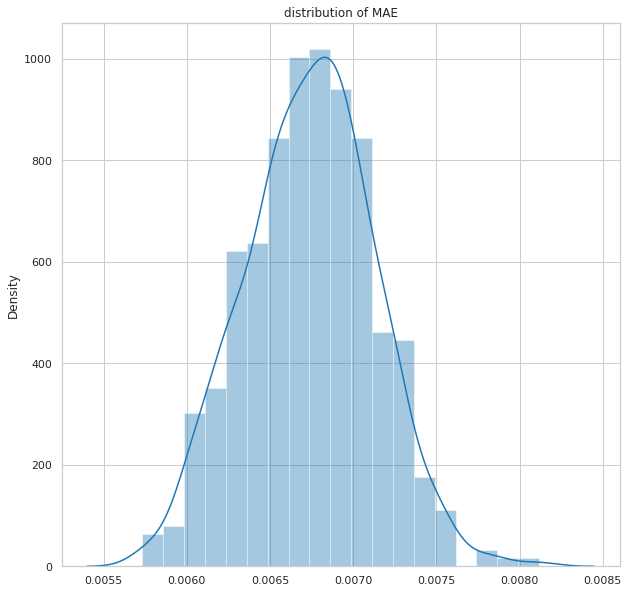

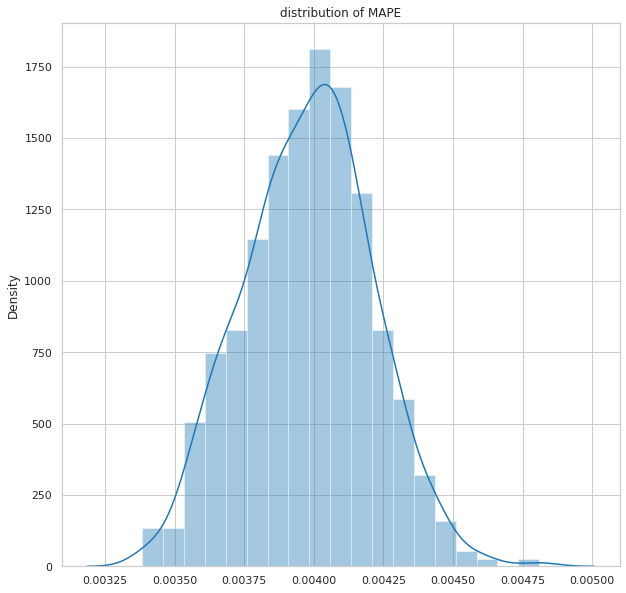

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(mae)
plt.title('distribution of MAE')
plt.show()

plt.figure(figsize=(10,10))
sns.distplot(mape)
plt.title('distribution of MAPE')
plt.show()

In [ ]:
print('Mean of MAE : ', np.mean(mae),'Ahr', '\nMean of MAPE : ', np.mean(mape)*100,'%')
mae_1 = np.mean(mae)
mape_1 = np.mean(mape)

Mean of MAE :  0.006739106218961135 Ahr 
Mean of MAPE :  0.3979258266257585 %


### Randomized base model hyperparameters

In [ ]:
class Custom_model:
  def __init__(self, sample_k, sample_size):
    """
    Parameters:
      sample_k- No of base models 
      sample_size- No of data samples per base model
    """
    self.k = sample_k
    self.sample_size = sample_size

  def sample(self, X, sample_size):
    """
    Parameters:
      X- data
      sample_size- size of samples from X
    Returns:
      data after sampling from X
    """
    return np.random.choice(X, size=sample_size, replace=True)

  def get_model(self):
    """
    Returns:
      Initializes and returns a sklearn model object
    """
    m_id = np.random.randint(0,5)
    if m_id == 0:
      fraction = np.random.rand(1)
      depth = np.random.choice([1,2,3])
      return lgb.LGBMRegressor(feature_fraction = fraction,max_depth=depth,random_state=np.random.randint(0,1000))
    elif m_id == 1:
      n_est = np.random.choice([20,40,60])
      depth = np.random.choice([3,5,7])
      return RandomForestRegressor(n_estimators=n_est, max_depth=depth,random_state=np.random.randint(0,1000))
    elif m_id == 2: 
      n_est = np.random.choice([20,40,60])
      return AdaBoostRegressor(n_estimators=n_est,random_state=np.random.randint(0,1000))
    elif m_id == 3:
      depth = np.random.choice([3,5,7])
      return DecisionTreeRegressor(max_depth=depth,random_state=np.random.randint(0,1000))
    else:
      alpha = np.random.choice([0.1, 0.01, 0.001])
      return SGDRegressor(loss='squared_error', penalty='l2', alpha=alpha,random_state=np.random.randint(0,1000))

  def fit(self, D1_x,D2_x, D1_y, D2_y):
    """
    Parameters:
      D1_x, D1_y : D1 part of the data to train base models
      D2_x, D2_y : D2 part of the data to train meta model
    """
    # Sampling base models and data indices
    self.K_IDs = [self.sample(D1_x.index.tolist(), self.sample_size) for _ in  range(self.k)]
    self.base_models = [self.get_model() for _ in range(self.k)]
    print('Training Base models')
    for i in (range(self.k)):
      D1_x_i = D1_x.loc[self.K_IDs[i]]
      D1_y_i = D1_y.loc[self.K_IDs[i]]
      self.base_models[i].fit(D1_x_i, D1_y_i)

    # Input for meta model
    self.meta_data_x = pd.DataFrame()
    for i in range(self.k):
      preds = pd.DataFrame(self.base_models[i].predict(D2_x),columns=['input_'+str(i)])
      self.meta_data_x = pd.concat([self.meta_data_x,preds], axis=1, ignore_index = True)
    self.meta_data_y = D2_y

    print('Training Meta model')
    self.meta_model = RandomForestRegressor(n_estimators=40, max_depth=None)
    self.meta_model.fit(self.meta_data_x, self.meta_data_y)
    print('Done')

  def predict(self, data):
    """
    Parameters:
      data: Test data to predit
    Returns:
      predicted data
    """
    meta_data_input = pd.DataFrame()
    for i in range(self.k):
      preds = pd.DataFrame(self.base_models[i].predict(data),columns=['input'])
      meta_data_input = pd.concat([meta_data_input,preds], axis=1, ignore_index = True)
    meta_pred = self.meta_model.predict(meta_data_input)
    return meta_pred

model = Custom_model(512, 64)
model.fit(X_train_1, X_train_2, y_train_1, y_train_2)
y_test_pred = model.predict(X_test)
mean_absolute_error(y_test,y_test_pred)

Training Base models
Training Meta model
Done


0.006602441698540741

In [ ]:
mae = []
mape = []
for _ in tqdm(range(500)):
  model = Custom_model(64, 128)
  model.fit(X_train_1, X_train_2, y_train_1, y_train_2)
  y_test_pred = model.predict(X_test)
  mae.append(mean_absolute_error(y_test,y_test_pred))
  mape.append(mean_absolute_percentage_error(y_test,y_test_pred))

  0%|          | 0/500 [00:00<?, ?it/s]

Training Base models
Training Meta model


  0%|          | 1/500 [00:02<24:12,  2.91s/it]

Done
Training Base models
Training Meta model


  0%|          | 2/500 [00:05<22:01,  2.65s/it]

Done
Training Base models
Training Meta model


  1%|          | 3/500 [00:08<22:13,  2.68s/it]

Done
Training Base models
Training Meta model


  1%|          | 4/500 [00:10<22:02,  2.67s/it]

Done
Training Base models
Training Meta model


  1%|          | 5/500 [00:13<21:33,  2.61s/it]

Done
Training Base models
Training Meta model


  1%|          | 6/500 [00:16<21:54,  2.66s/it]

Done
Training Base models
Training Meta model


  1%|▏         | 7/500 [00:18<21:35,  2.63s/it]

Done
Training Base models
Training Meta model


  2%|▏         | 8/500 [00:21<21:17,  2.60s/it]

Done
Training Base models
Training Meta model


  2%|▏         | 9/500 [00:23<21:22,  2.61s/it]

Done
Training Base models
Training Meta model


  2%|▏         | 10/500 [00:26<21:45,  2.67s/it]

Done
Training Base models
Training Meta model


  2%|▏         | 11/500 [00:29<22:08,  2.72s/it]

Done
Training Base models
Training Meta model


  2%|▏         | 12/500 [00:32<22:23,  2.75s/it]

Done
Training Base models
Training Meta model


  3%|▎         | 13/500 [00:35<22:51,  2.82s/it]

Done
Training Base models
Training Meta model


  3%|▎         | 14/500 [00:38<23:43,  2.93s/it]

Done
Training Base models
Training Meta model


  3%|▎         | 15/500 [00:41<23:57,  2.96s/it]

Done
Training Base models
Training Meta model


  3%|▎         | 16/500 [00:43<22:53,  2.84s/it]

Done
Training Base models
Training Meta model


  3%|▎         | 17/500 [00:46<21:29,  2.67s/it]

Done
Training Base models
Training Meta model


  4%|▎         | 18/500 [00:48<20:32,  2.56s/it]

Done
Training Base models
Training Meta model


  4%|▍         | 19/500 [00:51<20:25,  2.55s/it]

Done
Training Base models
Training Meta model


  4%|▍         | 20/500 [00:53<19:50,  2.48s/it]

Done
Training Base models
Training Meta model


  4%|▍         | 21/500 [00:56<21:27,  2.69s/it]

Done
Training Base models
Training Meta model


  4%|▍         | 22/500 [00:59<21:46,  2.73s/it]

Done
Training Base models
Training Meta model


  5%|▍         | 23/500 [01:01<21:26,  2.70s/it]

Done
Training Base models
Training Meta model


  5%|▍         | 24/500 [01:05<22:23,  2.82s/it]

Done
Training Base models
Training Meta model


  5%|▌         | 25/500 [01:07<20:59,  2.65s/it]

Done
Training Base models
Training Meta model


  5%|▌         | 26/500 [01:09<20:20,  2.57s/it]

Done
Training Base models
Training Meta model


  5%|▌         | 27/500 [01:12<20:09,  2.56s/it]

Done
Training Base models
Training Meta model


  6%|▌         | 28/500 [01:15<20:55,  2.66s/it]

Done
Training Base models
Training Meta model


  6%|▌         | 29/500 [01:17<19:45,  2.52s/it]

Done
Training Base models
Training Meta model


  6%|▌         | 30/500 [01:20<20:33,  2.62s/it]

Done
Training Base models
Training Meta model


  6%|▌         | 31/500 [01:22<20:33,  2.63s/it]

Done
Training Base models
Training Meta model


  6%|▋         | 32/500 [01:25<20:44,  2.66s/it]

Done
Training Base models
Training Meta model


  7%|▋         | 33/500 [01:27<19:30,  2.51s/it]

Done
Training Base models
Training Meta model


  7%|▋         | 34/500 [01:30<19:49,  2.55s/it]

Done
Training Base models
Training Meta model


  7%|▋         | 35/500 [01:32<18:55,  2.44s/it]

Done
Training Base models
Training Meta model


  7%|▋         | 36/500 [01:35<19:33,  2.53s/it]

Done
Training Base models
Training Meta model


  7%|▋         | 37/500 [01:38<20:41,  2.68s/it]

Done
Training Base models
Training Meta model


  8%|▊         | 38/500 [01:41<21:46,  2.83s/it]

Done
Training Base models
Training Meta model


  8%|▊         | 39/500 [01:44<21:21,  2.78s/it]

Done
Training Base models
Training Meta model


  8%|▊         | 40/500 [01:46<21:17,  2.78s/it]

Done
Training Base models
Training Meta model


  8%|▊         | 41/500 [01:49<21:26,  2.80s/it]

Done
Training Base models
Training Meta model


  8%|▊         | 42/500 [01:52<20:19,  2.66s/it]

Done
Training Base models
Training Meta model


  9%|▊         | 43/500 [01:54<19:40,  2.58s/it]

Done
Training Base models
Training Meta model


  9%|▉         | 44/500 [01:57<20:06,  2.65s/it]

Done
Training Base models
Training Meta model


  9%|▉         | 45/500 [01:59<20:01,  2.64s/it]

Done
Training Base models
Training Meta model


  9%|▉         | 46/500 [02:02<20:02,  2.65s/it]

Done
Training Base models
Training Meta model


  9%|▉         | 47/500 [02:05<20:53,  2.77s/it]

Done
Training Base models
Training Meta model


 10%|▉         | 48/500 [02:08<19:48,  2.63s/it]

Done
Training Base models
Training Meta model


 10%|▉         | 49/500 [02:10<20:08,  2.68s/it]

Done
Training Base models
Training Meta model


 10%|█         | 50/500 [02:13<20:36,  2.75s/it]

Done
Training Base models
Training Meta model


 10%|█         | 51/500 [02:16<20:39,  2.76s/it]

Done
Training Base models
Training Meta model


 10%|█         | 52/500 [02:18<19:23,  2.60s/it]

Done
Training Base models
Training Meta model


 11%|█         | 53/500 [02:21<18:59,  2.55s/it]

Done
Training Base models
Training Meta model


 11%|█         | 54/500 [02:23<18:21,  2.47s/it]

Done
Training Base models
Training Meta model


 11%|█         | 55/500 [02:26<19:13,  2.59s/it]

Done
Training Base models
Training Meta model


 11%|█         | 56/500 [02:28<18:07,  2.45s/it]

Done
Training Base models
Training Meta model


 11%|█▏        | 57/500 [02:31<18:34,  2.52s/it]

Done
Training Base models
Training Meta model


 12%|█▏        | 58/500 [02:33<19:15,  2.61s/it]

Done
Training Base models
Training Meta model
Done


 12%|█▏        | 59/500 [02:37<20:30,  2.79s/it]

Training Base models
Training Meta model


 12%|█▏        | 60/500 [02:40<20:39,  2.82s/it]

Done
Training Base models
Training Meta model


 12%|█▏        | 61/500 [02:42<20:50,  2.85s/it]

Done
Training Base models
Training Meta model


 12%|█▏        | 62/500 [02:45<20:59,  2.88s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 63/500 [02:48<21:24,  2.94s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 64/500 [02:51<21:15,  2.93s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 65/500 [02:54<21:12,  2.93s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 66/500 [02:57<21:29,  2.97s/it]

Done
Training Base models
Training Meta model


 13%|█▎        | 67/500 [03:00<20:19,  2.82s/it]

Done
Training Base models
Training Meta model


 14%|█▎        | 68/500 [03:02<19:28,  2.71s/it]

Done
Training Base models
Training Meta model


 14%|█▍        | 69/500 [03:04<18:19,  2.55s/it]

Done
Training Base models
Training Meta model


 14%|█▍        | 70/500 [03:07<17:51,  2.49s/it]

Done
Training Base models
Training Meta model


 14%|█▍        | 71/500 [03:10<18:23,  2.57s/it]

Done
Training Base models
Training Meta model


 14%|█▍        | 72/500 [03:12<17:51,  2.50s/it]

Done
Training Base models
Training Meta model


 15%|█▍        | 73/500 [03:14<17:35,  2.47s/it]

Done
Training Base models
Training Meta model


 15%|█▍        | 74/500 [03:17<17:44,  2.50s/it]

Done
Training Base models
Training Meta model


 15%|█▌        | 75/500 [03:19<17:43,  2.50s/it]

Done
Training Base models
Training Meta model


 15%|█▌        | 76/500 [03:22<18:08,  2.57s/it]

Done
Training Base models
Training Meta model


 15%|█▌        | 77/500 [03:25<17:44,  2.52s/it]

Done
Training Base models
Training Meta model


 16%|█▌        | 78/500 [03:27<17:56,  2.55s/it]

Done
Training Base models
Training Meta model


 16%|█▌        | 79/500 [03:30<18:14,  2.60s/it]

Done
Training Base models
Training Meta model


 16%|█▌        | 80/500 [03:32<18:04,  2.58s/it]

Done
Training Base models
Training Meta model


 16%|█▌        | 81/500 [03:35<17:46,  2.54s/it]

Done
Training Base models
Training Meta model


 16%|█▋        | 82/500 [03:37<17:55,  2.57s/it]

Done
Training Base models
Training Meta model


 17%|█▋        | 83/500 [03:40<18:38,  2.68s/it]

Done
Training Base models
Training Meta model


 17%|█▋        | 84/500 [03:43<18:46,  2.71s/it]

Done
Training Base models
Training Meta model


 17%|█▋        | 85/500 [03:46<18:49,  2.72s/it]

Done
Training Base models
Training Meta model


 17%|█▋        | 86/500 [03:49<19:11,  2.78s/it]

Done
Training Base models
Training Meta model


 17%|█▋        | 87/500 [03:51<18:47,  2.73s/it]

Done
Training Base models
Training Meta model


 18%|█▊        | 88/500 [03:55<19:23,  2.82s/it]

Done
Training Base models
Training Meta model


 18%|█▊        | 89/500 [03:57<19:25,  2.83s/it]

Done
Training Base models
Training Meta model


 18%|█▊        | 90/500 [04:00<18:51,  2.76s/it]

Done
Training Base models
Training Meta model


 18%|█▊        | 91/500 [04:03<19:11,  2.82s/it]

Done
Training Base models
Training Meta model


 18%|█▊        | 92/500 [04:05<18:26,  2.71s/it]

Done
Training Base models
Training Meta model


 19%|█▊        | 93/500 [04:08<18:08,  2.67s/it]

Done
Training Base models
Training Meta model
Done


 19%|█▉        | 94/500 [04:11<19:10,  2.83s/it]

Training Base models
Training Meta model


 19%|█▉        | 95/500 [04:13<17:50,  2.64s/it]

Done
Training Base models
Training Meta model


 19%|█▉        | 96/500 [04:16<18:33,  2.75s/it]

Done
Training Base models
Training Meta model


 19%|█▉        | 97/500 [04:19<18:34,  2.77s/it]

Done
Training Base models
Training Meta model


 20%|█▉        | 98/500 [04:22<18:03,  2.70s/it]

Done
Training Base models
Training Meta model


 20%|█▉        | 99/500 [04:24<17:13,  2.58s/it]

Done
Training Base models
Training Meta model


 20%|██        | 100/500 [04:26<15:47,  2.37s/it]

Done
Training Base models
Training Meta model


 20%|██        | 101/500 [04:29<17:00,  2.56s/it]

Done
Training Base models
Training Meta model


 20%|██        | 102/500 [04:32<17:21,  2.62s/it]

Done
Training Base models
Training Meta model


 21%|██        | 103/500 [04:34<17:05,  2.58s/it]

Done
Training Base models
Training Meta model


 21%|██        | 104/500 [04:37<17:16,  2.62s/it]

Done
Training Base models
Training Meta model


 21%|██        | 105/500 [04:39<16:30,  2.51s/it]

Done
Training Base models
Training Meta model


 21%|██        | 106/500 [04:42<16:42,  2.54s/it]

Done
Training Base models
Training Meta model
Done


 21%|██▏       | 107/500 [04:45<18:10,  2.77s/it]

Training Base models
Training Meta model
Done


 22%|██▏       | 108/500 [04:48<19:16,  2.95s/it]

Training Base models
Training Meta model


 22%|██▏       | 109/500 [04:51<17:58,  2.76s/it]

Done
Training Base models
Training Meta model


 22%|██▏       | 110/500 [04:54<17:58,  2.77s/it]

Done
Training Base models
Training Meta model


 22%|██▏       | 111/500 [04:56<18:11,  2.81s/it]

Done
Training Base models
Training Meta model


 22%|██▏       | 112/500 [04:59<18:13,  2.82s/it]

Done
Training Base models
Training Meta model


 23%|██▎       | 113/500 [05:02<18:40,  2.89s/it]

Done
Training Base models
Training Meta model


 23%|██▎       | 114/500 [05:05<18:06,  2.82s/it]

Done
Training Base models
Training Meta model


 23%|██▎       | 115/500 [05:08<18:33,  2.89s/it]

Done
Training Base models
Training Meta model
Done


 23%|██▎       | 116/500 [05:11<19:15,  3.01s/it]

Training Base models
Training Meta model


 23%|██▎       | 117/500 [05:14<18:59,  2.98s/it]

Done
Training Base models
Training Meta model
Done


 24%|██▎       | 118/500 [05:18<20:15,  3.18s/it]

Training Base models
Training Meta model
Done


 24%|██▍       | 119/500 [05:21<20:02,  3.16s/it]

Training Base models
Training Meta model


 24%|██▍       | 120/500 [05:23<18:26,  2.91s/it]

Done
Training Base models
Training Meta model


 24%|██▍       | 121/500 [05:26<18:20,  2.90s/it]

Done
Training Base models
Training Meta model


 24%|██▍       | 122/500 [05:29<18:12,  2.89s/it]

Done
Training Base models
Training Meta model


 25%|██▍       | 123/500 [05:32<17:34,  2.80s/it]

Done
Training Base models
Training Meta model


 25%|██▍       | 124/500 [05:34<16:55,  2.70s/it]

Done
Training Base models
Training Meta model


 25%|██▌       | 125/500 [05:37<16:21,  2.62s/it]

Done
Training Base models
Training Meta model


 25%|██▌       | 126/500 [05:39<15:34,  2.50s/it]

Done
Training Base models
Training Meta model


 25%|██▌       | 127/500 [05:42<16:00,  2.57s/it]

Done
Training Base models
Training Meta model


 26%|██▌       | 128/500 [05:44<14:55,  2.41s/it]

Done
Training Base models
Training Meta model


 26%|██▌       | 129/500 [05:46<15:20,  2.48s/it]

Done
Training Base models
Training Meta model


 26%|██▌       | 130/500 [05:48<14:58,  2.43s/it]

Done
Training Base models
Training Meta model


 26%|██▌       | 131/500 [05:52<16:07,  2.62s/it]

Done
Training Base models
Training Meta model


 26%|██▋       | 132/500 [05:54<16:21,  2.67s/it]

Done
Training Base models
Training Meta model


 27%|██▋       | 133/500 [05:57<16:15,  2.66s/it]

Done
Training Base models
Training Meta model


 27%|██▋       | 134/500 [05:59<15:50,  2.60s/it]

Done
Training Base models
Training Meta model


 27%|██▋       | 135/500 [06:02<15:59,  2.63s/it]

Done
Training Base models
Training Meta model


 27%|██▋       | 136/500 [06:05<16:28,  2.72s/it]

Done
Training Base models
Training Meta model
Done


 27%|██▋       | 137/500 [06:08<17:17,  2.86s/it]

Training Base models
Training Meta model


 28%|██▊       | 138/500 [06:11<16:53,  2.80s/it]

Done
Training Base models
Training Meta model


 28%|██▊       | 139/500 [06:14<16:47,  2.79s/it]

Done
Training Base models
Training Meta model


 28%|██▊       | 140/500 [06:16<16:20,  2.72s/it]

Done
Training Base models
Training Meta model


 28%|██▊       | 141/500 [06:19<16:03,  2.68s/it]

Done
Training Base models
Training Meta model


 28%|██▊       | 142/500 [06:22<16:31,  2.77s/it]

Done
Training Base models
Training Meta model


 29%|██▊       | 143/500 [06:24<15:53,  2.67s/it]

Done
Training Base models
Training Meta model


 29%|██▉       | 144/500 [06:27<16:23,  2.76s/it]

Done
Training Base models
Training Meta model


 29%|██▉       | 145/500 [06:30<15:52,  2.68s/it]

Done
Training Base models
Training Meta model


 29%|██▉       | 146/500 [06:32<15:53,  2.69s/it]

Done
Training Base models
Training Meta model
Done


 29%|██▉       | 147/500 [06:36<16:34,  2.82s/it]

Training Base models
Training Meta model


 30%|██▉       | 148/500 [06:38<15:46,  2.69s/it]

Done
Training Base models
Training Meta model


 30%|██▉       | 149/500 [06:41<15:55,  2.72s/it]

Done
Training Base models
Training Meta model


 30%|███       | 150/500 [06:44<16:05,  2.76s/it]

Done
Training Base models
Training Meta model


 30%|███       | 151/500 [06:46<16:05,  2.77s/it]

Done
Training Base models
Training Meta model


 30%|███       | 152/500 [06:49<16:24,  2.83s/it]

Done
Training Base models
Training Meta model


 31%|███       | 153/500 [06:52<15:55,  2.75s/it]

Done
Training Base models
Training Meta model


 31%|███       | 154/500 [06:55<15:40,  2.72s/it]

Done
Training Base models
Training Meta model


 31%|███       | 155/500 [06:57<15:12,  2.65s/it]

Done
Training Base models
Training Meta model


 31%|███       | 156/500 [06:59<14:27,  2.52s/it]

Done
Training Base models
Training Meta model


 31%|███▏      | 157/500 [07:02<14:40,  2.57s/it]

Done
Training Base models
Training Meta model


 32%|███▏      | 158/500 [07:05<15:02,  2.64s/it]

Done
Training Base models
Training Meta model


 32%|███▏      | 159/500 [07:08<15:22,  2.71s/it]

Done
Training Base models
Training Meta model


 32%|███▏      | 160/500 [07:10<15:41,  2.77s/it]

Done
Training Base models
Training Meta model


 32%|███▏      | 161/500 [07:13<15:48,  2.80s/it]

Done
Training Base models
Training Meta model


 32%|███▏      | 162/500 [07:17<16:22,  2.91s/it]

Done
Training Base models
Training Meta model


 33%|███▎      | 163/500 [07:19<16:04,  2.86s/it]

Done
Training Base models
Training Meta model


 33%|███▎      | 164/500 [07:22<15:42,  2.80s/it]

Done
Training Base models
Training Meta model


 33%|███▎      | 165/500 [07:25<15:43,  2.82s/it]

Done
Training Base models
Training Meta model


 33%|███▎      | 166/500 [07:28<15:59,  2.87s/it]

Done
Training Base models
Training Meta model


 33%|███▎      | 167/500 [07:31<15:53,  2.86s/it]

Done
Training Base models
Training Meta model


 34%|███▎      | 168/500 [07:33<15:19,  2.77s/it]

Done
Training Base models
Training Meta model
Done


 34%|███▍      | 169/500 [07:37<16:20,  2.96s/it]

Training Base models
Training Meta model


 34%|███▍      | 170/500 [07:39<15:43,  2.86s/it]

Done
Training Base models
Training Meta model


 34%|███▍      | 171/500 [07:42<15:38,  2.85s/it]

Done
Training Base models
Training Meta model
Done


 34%|███▍      | 172/500 [07:45<16:11,  2.96s/it]

Training Base models
Training Meta model
Done


 35%|███▍      | 173/500 [07:48<16:12,  2.97s/it]

Training Base models
Training Meta model


 35%|███▍      | 174/500 [07:51<16:01,  2.95s/it]

Done
Training Base models
Training Meta model
Done


 35%|███▌      | 175/500 [07:54<16:14,  3.00s/it]

Training Base models
Training Meta model


 35%|███▌      | 176/500 [07:57<15:57,  2.95s/it]

Done
Training Base models
Training Meta model


 35%|███▌      | 177/500 [08:00<15:47,  2.93s/it]

Done
Training Base models
Training Meta model


 36%|███▌      | 178/500 [08:02<14:59,  2.79s/it]

Done
Training Base models
Training Meta model


 36%|███▌      | 179/500 [08:05<14:26,  2.70s/it]

Done
Training Base models
Training Meta model


 36%|███▌      | 180/500 [08:07<13:43,  2.57s/it]

Done
Training Base models
Training Meta model


 36%|███▌      | 181/500 [08:10<13:30,  2.54s/it]

Done
Training Base models
Training Meta model


 36%|███▋      | 182/500 [08:12<13:03,  2.46s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 183/500 [08:15<13:24,  2.54s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 184/500 [08:17<13:44,  2.61s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 185/500 [08:20<13:10,  2.51s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 186/500 [08:23<13:59,  2.67s/it]

Done
Training Base models
Training Meta model


 37%|███▋      | 187/500 [08:25<13:45,  2.64s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 188/500 [08:28<13:54,  2.67s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 189/500 [08:31<13:41,  2.64s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 190/500 [08:33<13:53,  2.69s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 191/500 [08:36<14:09,  2.75s/it]

Done
Training Base models
Training Meta model


 38%|███▊      | 192/500 [08:39<13:48,  2.69s/it]

Done
Training Base models
Training Meta model


 39%|███▊      | 193/500 [08:41<13:27,  2.63s/it]

Done
Training Base models
Training Meta model


 39%|███▉      | 194/500 [08:45<14:21,  2.82s/it]

Done
Training Base models
Training Meta model


 39%|███▉      | 195/500 [08:48<14:41,  2.89s/it]

Done
Training Base models
Training Meta model


 39%|███▉      | 196/500 [08:50<14:09,  2.80s/it]

Done
Training Base models
Training Meta model


 39%|███▉      | 197/500 [08:53<14:04,  2.79s/it]

Done
Training Base models
Training Meta model


 40%|███▉      | 198/500 [08:56<13:41,  2.72s/it]

Done
Training Base models
Training Meta model


 40%|███▉      | 199/500 [08:58<12:57,  2.58s/it]

Done
Training Base models
Training Meta model


 40%|████      | 200/500 [09:00<12:35,  2.52s/it]

Done
Training Base models
Training Meta model


 40%|████      | 201/500 [09:03<13:11,  2.65s/it]

Done
Training Base models
Training Meta model


 40%|████      | 202/500 [09:06<12:46,  2.57s/it]

Done
Training Base models
Training Meta model


 41%|████      | 203/500 [09:08<13:03,  2.64s/it]

Done
Training Base models
Training Meta model


 41%|████      | 204/500 [09:11<13:15,  2.69s/it]

Done
Training Base models
Training Meta model


 41%|████      | 205/500 [09:14<13:12,  2.68s/it]

Done
Training Base models
Training Meta model


 41%|████      | 206/500 [09:17<13:27,  2.75s/it]

Done
Training Base models
Training Meta model


 41%|████▏     | 207/500 [09:19<12:37,  2.58s/it]

Done
Training Base models
Training Meta model


 42%|████▏     | 208/500 [09:22<12:50,  2.64s/it]

Done
Training Base models
Training Meta model


 42%|████▏     | 209/500 [09:24<12:46,  2.63s/it]

Done
Training Base models
Training Meta model
Done


 42%|████▏     | 210/500 [09:27<13:05,  2.71s/it]

Training Base models
Training Meta model


 42%|████▏     | 211/500 [09:30<13:13,  2.75s/it]

Done
Training Base models
Training Meta model


 42%|████▏     | 212/500 [09:33<13:37,  2.84s/it]

Done
Training Base models
Training Meta model


 43%|████▎     | 213/500 [09:36<13:09,  2.75s/it]

Done
Training Base models
Training Meta model


 43%|████▎     | 214/500 [09:39<13:11,  2.77s/it]

Done
Training Base models
Training Meta model


 43%|████▎     | 215/500 [09:41<12:22,  2.61s/it]

Done
Training Base models
Training Meta model


 43%|████▎     | 216/500 [09:43<12:06,  2.56s/it]

Done
Training Base models
Training Meta model


 43%|████▎     | 217/500 [09:46<11:54,  2.53s/it]

Done
Training Base models
Training Meta model


 44%|████▎     | 218/500 [09:48<11:24,  2.43s/it]

Done
Training Base models
Training Meta model


 44%|████▍     | 219/500 [09:50<11:28,  2.45s/it]

Done
Training Base models
Training Meta model


 44%|████▍     | 220/500 [09:53<11:09,  2.39s/it]

Done
Training Base models
Training Meta model
Done


 44%|████▍     | 221/500 [09:55<11:43,  2.52s/it]

Training Base models
Training Meta model


 44%|████▍     | 222/500 [09:58<11:50,  2.55s/it]

Done
Training Base models
Training Meta model


 45%|████▍     | 223/500 [10:01<11:56,  2.59s/it]

Done
Training Base models
Training Meta model


 45%|████▍     | 224/500 [10:04<12:34,  2.73s/it]

Done
Training Base models
Training Meta model


 45%|████▌     | 225/500 [10:07<12:40,  2.76s/it]

Done
Training Base models
Training Meta model


 45%|████▌     | 226/500 [10:10<13:16,  2.91s/it]

Done
Training Base models
Training Meta model


 45%|████▌     | 227/500 [10:12<12:49,  2.82s/it]

Done
Training Base models
Training Meta model


 46%|████▌     | 228/500 [10:15<12:47,  2.82s/it]

Done
Training Base models
Training Meta model


 46%|████▌     | 229/500 [10:18<12:18,  2.73s/it]

Done
Training Base models
Training Meta model


 46%|████▌     | 230/500 [10:21<12:20,  2.74s/it]

Done
Training Base models
Training Meta model


 46%|████▌     | 231/500 [10:23<12:31,  2.79s/it]

Done
Training Base models
Training Meta model
Done


 46%|████▋     | 232/500 [10:27<13:04,  2.93s/it]

Training Base models
Training Meta model


 47%|████▋     | 233/500 [10:30<13:00,  2.92s/it]

Done
Training Base models
Training Meta model


 47%|████▋     | 234/500 [10:32<12:33,  2.83s/it]

Done
Training Base models
Training Meta model


 47%|████▋     | 235/500 [10:35<12:32,  2.84s/it]

Done
Training Base models
Training Meta model


 47%|████▋     | 236/500 [10:38<12:53,  2.93s/it]

Done
Training Base models
Training Meta model


 47%|████▋     | 237/500 [10:41<12:54,  2.94s/it]

Done
Training Base models
Training Meta model


 48%|████▊     | 238/500 [10:44<12:04,  2.76s/it]

Done
Training Base models
Training Meta model


 48%|████▊     | 239/500 [10:47<12:15,  2.82s/it]

Done
Training Base models
Training Meta model


 48%|████▊     | 240/500 [10:50<12:33,  2.90s/it]

Done
Training Base models
Training Meta model


 48%|████▊     | 241/500 [10:52<12:17,  2.85s/it]

Done
Training Base models
Training Meta model


 48%|████▊     | 242/500 [10:55<12:22,  2.88s/it]

Done
Training Base models
Training Meta model


 49%|████▊     | 243/500 [10:58<11:49,  2.76s/it]

Done
Training Base models
Training Meta model


 49%|████▉     | 244/500 [11:00<11:21,  2.66s/it]

Done
Training Base models
Training Meta model


 49%|████▉     | 245/500 [11:03<11:45,  2.77s/it]

Done
Training Base models
Training Meta model


 49%|████▉     | 246/500 [11:06<11:39,  2.75s/it]

Done
Training Base models
Training Meta model


 49%|████▉     | 247/500 [11:09<11:27,  2.72s/it]

Done
Training Base models
Training Meta model


 50%|████▉     | 248/500 [11:11<11:09,  2.66s/it]

Done
Training Base models
Training Meta model


 50%|████▉     | 249/500 [11:14<11:23,  2.72s/it]

Done
Training Base models
Training Meta model


 50%|█████     | 250/500 [11:16<10:32,  2.53s/it]

Done
Training Base models
Training Meta model


 50%|█████     | 251/500 [11:19<10:44,  2.59s/it]

Done
Training Base models
Training Meta model


 50%|█████     | 252/500 [11:22<10:53,  2.64s/it]

Done
Training Base models
Training Meta model


 51%|█████     | 253/500 [11:24<11:00,  2.67s/it]

Done
Training Base models
Training Meta model


 51%|█████     | 254/500 [11:28<11:46,  2.87s/it]

Done
Training Base models
Training Meta model


 51%|█████     | 255/500 [11:30<11:42,  2.87s/it]

Done
Training Base models
Training Meta model


 51%|█████     | 256/500 [11:33<11:16,  2.77s/it]

Done
Training Base models
Training Meta model


 51%|█████▏    | 257/500 [11:36<11:11,  2.76s/it]

Done
Training Base models
Training Meta model


 52%|█████▏    | 258/500 [11:38<10:58,  2.72s/it]

Done
Training Base models
Training Meta model


 52%|█████▏    | 259/500 [11:41<11:04,  2.76s/it]

Done
Training Base models
Training Meta model


 52%|█████▏    | 260/500 [11:44<11:06,  2.78s/it]

Done
Training Base models
Training Meta model


 52%|█████▏    | 261/500 [11:47<10:51,  2.73s/it]

Done
Training Base models
Training Meta model


 52%|█████▏    | 262/500 [11:50<11:09,  2.81s/it]

Done
Training Base models
Training Meta model


 53%|█████▎    | 263/500 [11:52<10:43,  2.72s/it]

Done
Training Base models
Training Meta model


 53%|█████▎    | 264/500 [11:55<10:43,  2.73s/it]

Done
Training Base models
Training Meta model


 53%|█████▎    | 265/500 [11:57<10:22,  2.65s/it]

Done
Training Base models
Training Meta model


 53%|█████▎    | 266/500 [12:00<10:28,  2.69s/it]

Done
Training Base models
Training Meta model


 53%|█████▎    | 267/500 [12:03<10:10,  2.62s/it]

Done
Training Base models
Training Meta model


 54%|█████▎    | 268/500 [12:05<10:15,  2.65s/it]

Done
Training Base models
Training Meta model


 54%|█████▍    | 269/500 [12:08<10:15,  2.66s/it]

Done
Training Base models
Training Meta model


 54%|█████▍    | 270/500 [12:10<09:47,  2.56s/it]

Done
Training Base models
Training Meta model


 54%|█████▍    | 271/500 [12:13<10:11,  2.67s/it]

Done
Training Base models
Training Meta model


 54%|█████▍    | 272/500 [12:16<10:23,  2.73s/it]

Done
Training Base models
Training Meta model


 55%|█████▍    | 273/500 [12:19<10:17,  2.72s/it]

Done
Training Base models
Training Meta model


 55%|█████▍    | 274/500 [12:21<09:56,  2.64s/it]

Done
Training Base models
Training Meta model


 55%|█████▌    | 275/500 [12:24<10:19,  2.75s/it]

Done
Training Base models
Training Meta model


 55%|█████▌    | 276/500 [12:27<10:33,  2.83s/it]

Done
Training Base models
Training Meta model


 55%|█████▌    | 277/500 [12:30<10:25,  2.81s/it]

Done
Training Base models
Training Meta model


 56%|█████▌    | 278/500 [12:33<10:11,  2.76s/it]

Done
Training Base models
Training Meta model


 56%|█████▌    | 279/500 [12:35<10:07,  2.75s/it]

Done
Training Base models
Training Meta model


 56%|█████▌    | 280/500 [12:38<09:52,  2.69s/it]

Done
Training Base models
Training Meta model


 56%|█████▌    | 281/500 [12:40<09:21,  2.57s/it]

Done
Training Base models
Training Meta model
Done


 56%|█████▋    | 282/500 [12:44<10:31,  2.90s/it]

Training Base models
Training Meta model


 57%|█████▋    | 283/500 [12:47<10:06,  2.80s/it]

Done
Training Base models
Training Meta model


 57%|█████▋    | 284/500 [12:50<10:16,  2.85s/it]

Done
Training Base models
Training Meta model


 57%|█████▋    | 285/500 [12:52<10:05,  2.82s/it]

Done
Training Base models
Training Meta model


 57%|█████▋    | 286/500 [12:55<10:06,  2.84s/it]

Done
Training Base models
Training Meta model


 57%|█████▋    | 287/500 [12:58<09:44,  2.75s/it]

Done
Training Base models
Training Meta model


 58%|█████▊    | 288/500 [13:00<09:45,  2.76s/it]

Done
Training Base models
Training Meta model


 58%|█████▊    | 289/500 [13:02<08:53,  2.53s/it]

Done
Training Base models
Training Meta model


 58%|█████▊    | 290/500 [13:05<09:02,  2.59s/it]

Done
Training Base models
Training Meta model


 58%|█████▊    | 291/500 [13:07<08:38,  2.48s/it]

Done
Training Base models
Training Meta model


 58%|█████▊    | 292/500 [13:10<08:45,  2.53s/it]

Done
Training Base models
Training Meta model


 59%|█████▊    | 293/500 [13:13<08:47,  2.55s/it]

Done
Training Base models
Training Meta model


 59%|█████▉    | 294/500 [13:15<08:41,  2.53s/it]

Done
Training Base models
Training Meta model


 59%|█████▉    | 295/500 [13:18<08:47,  2.57s/it]

Done
Training Base models
Training Meta model


 59%|█████▉    | 296/500 [13:21<09:09,  2.69s/it]

Done
Training Base models
Training Meta model


 59%|█████▉    | 297/500 [13:24<09:26,  2.79s/it]

Done
Training Base models
Training Meta model
Done


 60%|█████▉    | 298/500 [13:27<09:53,  2.94s/it]

Training Base models
Training Meta model
Done


 60%|█████▉    | 299/500 [13:30<10:02,  3.00s/it]

Training Base models
Training Meta model


 60%|██████    | 300/500 [13:33<09:31,  2.86s/it]

Done
Training Base models
Training Meta model
Done


 60%|██████    | 301/500 [13:36<10:08,  3.06s/it]

Training Base models
Training Meta model


 60%|██████    | 302/500 [13:39<09:34,  2.90s/it]

Done
Training Base models
Training Meta model


 61%|██████    | 303/500 [13:41<09:08,  2.78s/it]

Done
Training Base models
Training Meta model
Done


 61%|██████    | 304/500 [13:45<09:30,  2.91s/it]

Training Base models
Training Meta model


 61%|██████    | 305/500 [13:47<08:59,  2.77s/it]

Done
Training Base models
Training Meta model


 61%|██████    | 306/500 [13:49<08:25,  2.61s/it]

Done
Training Base models
Training Meta model


 61%|██████▏   | 307/500 [13:52<08:15,  2.57s/it]

Done
Training Base models
Training Meta model


 62%|██████▏   | 308/500 [13:54<07:58,  2.49s/it]

Done
Training Base models
Training Meta model


 62%|██████▏   | 309/500 [13:57<08:22,  2.63s/it]

Done
Training Base models
Training Meta model


 62%|██████▏   | 310/500 [13:59<08:08,  2.57s/it]

Done
Training Base models
Training Meta model


 62%|██████▏   | 311/500 [14:02<08:06,  2.57s/it]

Done
Training Base models
Training Meta model


 62%|██████▏   | 312/500 [14:05<08:31,  2.72s/it]

Done
Training Base models
Training Meta model


 63%|██████▎   | 313/500 [14:08<08:40,  2.79s/it]

Done
Training Base models
Training Meta model


 63%|██████▎   | 314/500 [14:10<08:21,  2.70s/it]

Done
Training Base models
Training Meta model


 63%|██████▎   | 315/500 [14:13<08:27,  2.74s/it]

Done
Training Base models
Training Meta model


 63%|██████▎   | 316/500 [14:16<08:18,  2.71s/it]

Done
Training Base models
Training Meta model


 63%|██████▎   | 317/500 [14:19<08:28,  2.78s/it]

Done
Training Base models
Training Meta model


 64%|██████▎   | 318/500 [14:21<07:59,  2.64s/it]

Done
Training Base models
Training Meta model


 64%|██████▍   | 319/500 [14:24<08:08,  2.70s/it]

Done
Training Base models
Training Meta model


 64%|██████▍   | 320/500 [14:27<07:57,  2.65s/it]

Done
Training Base models
Training Meta model


 64%|██████▍   | 321/500 [14:29<07:47,  2.61s/it]

Done
Training Base models
Training Meta model


 64%|██████▍   | 322/500 [14:32<07:55,  2.67s/it]

Done
Training Base models
Training Meta model


 65%|██████▍   | 323/500 [14:34<07:43,  2.62s/it]

Done
Training Base models
Training Meta model


 65%|██████▍   | 324/500 [14:37<07:59,  2.72s/it]

Done
Training Base models
Training Meta model


 65%|██████▌   | 325/500 [14:40<07:49,  2.68s/it]

Done
Training Base models
Training Meta model
Done


 65%|██████▌   | 326/500 [14:43<08:00,  2.76s/it]

Training Base models
Training Meta model


 65%|██████▌   | 327/500 [14:46<08:13,  2.85s/it]

Done
Training Base models
Training Meta model


 66%|██████▌   | 328/500 [14:49<08:02,  2.81s/it]

Done
Training Base models
Training Meta model


 66%|██████▌   | 329/500 [14:52<08:18,  2.92s/it]

Done
Training Base models
Training Meta model


 66%|██████▌   | 330/500 [14:55<08:11,  2.89s/it]

Done
Training Base models
Training Meta model


 66%|██████▌   | 331/500 [14:57<07:50,  2.79s/it]

Done
Training Base models
Training Meta model


 66%|██████▋   | 332/500 [15:00<07:55,  2.83s/it]

Done
Training Base models
Training Meta model


 67%|██████▋   | 333/500 [15:03<07:51,  2.82s/it]

Done
Training Base models
Training Meta model


 67%|██████▋   | 334/500 [15:06<08:04,  2.92s/it]

Done
Training Base models
Training Meta model


 67%|██████▋   | 335/500 [15:09<07:46,  2.83s/it]

Done
Training Base models
Training Meta model


 67%|██████▋   | 336/500 [15:11<07:09,  2.62s/it]

Done
Training Base models
Training Meta model


 67%|██████▋   | 337/500 [15:14<07:12,  2.66s/it]

Done
Training Base models
Training Meta model


 68%|██████▊   | 338/500 [15:16<07:20,  2.72s/it]

Done
Training Base models
Training Meta model
Done


 68%|██████▊   | 339/500 [15:20<08:07,  3.03s/it]

Training Base models
Training Meta model


 68%|██████▊   | 340/500 [15:23<08:04,  3.03s/it]

Done
Training Base models
Training Meta model
Done


 68%|██████▊   | 341/500 [15:27<08:36,  3.25s/it]

Training Base models
Training Meta model


 68%|██████▊   | 342/500 [15:30<08:46,  3.33s/it]

Done
Training Base models
Training Meta model


 69%|██████▊   | 343/500 [15:33<08:29,  3.24s/it]

Done
Training Base models
Training Meta model


 69%|██████▉   | 344/500 [15:36<07:41,  2.96s/it]

Done
Training Base models
Training Meta model


 69%|██████▉   | 345/500 [15:39<07:36,  2.94s/it]

Done
Training Base models
Training Meta model


 69%|██████▉   | 346/500 [15:41<07:14,  2.82s/it]

Done
Training Base models
Training Meta model


 69%|██████▉   | 347/500 [15:44<06:56,  2.72s/it]

Done
Training Base models
Training Meta model


 70%|██████▉   | 348/500 [15:47<07:01,  2.77s/it]

Done
Training Base models
Training Meta model


 70%|██████▉   | 349/500 [15:49<06:57,  2.77s/it]

Done
Training Base models
Training Meta model


 70%|███████   | 350/500 [15:52<06:39,  2.66s/it]

Done
Training Base models
Training Meta model


 70%|███████   | 351/500 [15:55<07:00,  2.82s/it]

Done
Training Base models
Training Meta model


 70%|███████   | 352/500 [15:58<06:46,  2.75s/it]

Done
Training Base models
Training Meta model


 71%|███████   | 353/500 [16:00<06:47,  2.77s/it]

Done
Training Base models
Training Meta model


 71%|███████   | 354/500 [16:03<06:53,  2.83s/it]

Done
Training Base models
Training Meta model


 71%|███████   | 355/500 [16:06<06:50,  2.83s/it]

Done
Training Base models
Training Meta model


 71%|███████   | 356/500 [16:09<07:00,  2.92s/it]

Done
Training Base models
Training Meta model


 71%|███████▏  | 357/500 [16:12<06:45,  2.83s/it]

Done
Training Base models
Training Meta model


 72%|███████▏  | 358/500 [16:14<06:25,  2.71s/it]

Done
Training Base models
Training Meta model


 72%|███████▏  | 359/500 [16:17<06:26,  2.74s/it]

Done
Training Base models
Training Meta model


 72%|███████▏  | 360/500 [16:20<06:26,  2.76s/it]

Done
Training Base models
Training Meta model


 72%|███████▏  | 361/500 [16:23<06:14,  2.70s/it]

Done
Training Base models
Training Meta model


 72%|███████▏  | 362/500 [16:26<06:28,  2.81s/it]

Done
Training Base models
Training Meta model


 73%|███████▎  | 363/500 [16:28<06:02,  2.64s/it]

Done
Training Base models
Training Meta model


 73%|███████▎  | 364/500 [16:31<06:09,  2.72s/it]

Done
Training Base models
Training Meta model


 73%|███████▎  | 365/500 [16:34<06:13,  2.77s/it]

Done
Training Base models
Training Meta model


 73%|███████▎  | 366/500 [16:36<05:54,  2.65s/it]

Done
Training Base models
Training Meta model


 73%|███████▎  | 367/500 [16:39<05:46,  2.61s/it]

Done
Training Base models
Training Meta model


 74%|███████▎  | 368/500 [16:41<05:38,  2.57s/it]

Done
Training Base models
Training Meta model


 74%|███████▍  | 369/500 [16:44<05:45,  2.64s/it]

Done
Training Base models
Training Meta model


 74%|███████▍  | 370/500 [16:47<05:51,  2.71s/it]

Done
Training Base models
Training Meta model


 74%|███████▍  | 371/500 [16:50<06:01,  2.81s/it]

Done
Training Base models
Training Meta model


 74%|███████▍  | 372/500 [16:53<06:05,  2.86s/it]

Done
Training Base models
Training Meta model


 75%|███████▍  | 373/500 [16:55<06:00,  2.84s/it]

Done
Training Base models
Training Meta model


 75%|███████▍  | 374/500 [16:58<05:41,  2.71s/it]

Done
Training Base models
Training Meta model


 75%|███████▌  | 375/500 [17:01<05:38,  2.71s/it]

Done
Training Base models
Training Meta model


 75%|███████▌  | 376/500 [17:03<05:28,  2.65s/it]

Done
Training Base models
Training Meta model


 75%|███████▌  | 377/500 [17:05<05:14,  2.56s/it]

Done
Training Base models
Training Meta model


 76%|███████▌  | 378/500 [17:08<05:10,  2.55s/it]

Done
Training Base models
Training Meta model


 76%|███████▌  | 379/500 [17:11<05:08,  2.55s/it]

Done
Training Base models
Training Meta model


 76%|███████▌  | 380/500 [17:13<05:14,  2.62s/it]

Done
Training Base models
Training Meta model


 76%|███████▌  | 381/500 [17:16<05:05,  2.56s/it]

Done
Training Base models
Training Meta model


 76%|███████▋  | 382/500 [17:19<05:11,  2.64s/it]

Done
Training Base models
Training Meta model


 77%|███████▋  | 383/500 [17:22<05:21,  2.75s/it]

Done
Training Base models
Training Meta model


 77%|███████▋  | 384/500 [17:25<05:28,  2.83s/it]

Done
Training Base models
Training Meta model


 77%|███████▋  | 385/500 [17:27<05:15,  2.74s/it]

Done
Training Base models
Training Meta model


 77%|███████▋  | 386/500 [17:30<05:14,  2.76s/it]

Done
Training Base models
Training Meta model


 77%|███████▋  | 387/500 [17:32<04:58,  2.65s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 388/500 [17:35<05:00,  2.68s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 389/500 [17:38<05:04,  2.75s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 390/500 [17:41<05:05,  2.78s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 391/500 [17:44<05:02,  2.77s/it]

Done
Training Base models
Training Meta model


 78%|███████▊  | 392/500 [17:46<04:51,  2.70s/it]

Done
Training Base models
Training Meta model


 79%|███████▊  | 393/500 [17:49<04:45,  2.67s/it]

Done
Training Base models
Training Meta model


 79%|███████▉  | 394/500 [17:52<04:51,  2.75s/it]

Done
Training Base models
Training Meta model


 79%|███████▉  | 395/500 [17:55<04:59,  2.85s/it]

Done
Training Base models
Training Meta model


 79%|███████▉  | 396/500 [17:57<04:47,  2.76s/it]

Done
Training Base models
Training Meta model


 79%|███████▉  | 397/500 [18:00<04:39,  2.71s/it]

Done
Training Base models
Training Meta model


 80%|███████▉  | 398/500 [18:03<04:34,  2.69s/it]

Done
Training Base models
Training Meta model


 80%|███████▉  | 399/500 [18:06<04:41,  2.78s/it]

Done
Training Base models
Training Meta model
Done


 80%|████████  | 400/500 [18:09<05:00,  3.00s/it]

Training Base models
Training Meta model


 80%|████████  | 401/500 [18:12<04:49,  2.93s/it]

Done
Training Base models
Training Meta model


 80%|████████  | 402/500 [18:14<04:35,  2.82s/it]

Done
Training Base models
Training Meta model


 81%|████████  | 403/500 [18:17<04:26,  2.74s/it]

Done
Training Base models
Training Meta model


 81%|████████  | 404/500 [18:20<04:26,  2.77s/it]

Done
Training Base models
Training Meta model


 81%|████████  | 405/500 [18:22<04:19,  2.73s/it]

Done
Training Base models
Training Meta model


 81%|████████  | 406/500 [18:25<04:12,  2.69s/it]

Done
Training Base models
Training Meta model


 81%|████████▏ | 407/500 [18:28<04:18,  2.78s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 408/500 [18:31<04:15,  2.78s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 409/500 [18:34<04:13,  2.78s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 410/500 [18:37<04:18,  2.87s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 411/500 [18:39<03:57,  2.67s/it]

Done
Training Base models
Training Meta model


 82%|████████▏ | 412/500 [18:42<04:05,  2.79s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 413/500 [18:45<04:01,  2.78s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 414/500 [18:47<03:47,  2.65s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 415/500 [18:49<03:39,  2.59s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 416/500 [18:52<03:37,  2.59s/it]

Done
Training Base models
Training Meta model


 83%|████████▎ | 417/500 [18:55<03:35,  2.60s/it]

Done
Training Base models
Training Meta model


 84%|████████▎ | 418/500 [18:58<03:40,  2.69s/it]

Done
Training Base models
Training Meta model


 84%|████████▍ | 419/500 [19:01<03:45,  2.79s/it]

Done
Training Base models
Training Meta model


 84%|████████▍ | 420/500 [19:03<03:44,  2.81s/it]

Done
Training Base models
Training Meta model


 84%|████████▍ | 421/500 [19:06<03:36,  2.74s/it]

Done
Training Base models
Training Meta model


 84%|████████▍ | 422/500 [19:09<03:28,  2.67s/it]

Done
Training Base models
Training Meta model


 85%|████████▍ | 423/500 [19:11<03:24,  2.66s/it]

Done
Training Base models
Training Meta model


 85%|████████▍ | 424/500 [19:14<03:17,  2.60s/it]

Done
Training Base models
Training Meta model


 85%|████████▌ | 425/500 [19:16<03:07,  2.50s/it]

Done
Training Base models
Training Meta model


 85%|████████▌ | 426/500 [19:18<03:06,  2.53s/it]

Done
Training Base models
Training Meta model


 85%|████████▌ | 427/500 [19:20<02:53,  2.37s/it]

Done
Training Base models
Training Meta model


 86%|████████▌ | 428/500 [19:23<03:02,  2.53s/it]

Done
Training Base models
Training Meta model


 86%|████████▌ | 429/500 [19:26<03:02,  2.58s/it]

Done
Training Base models
Training Meta model


 86%|████████▌ | 430/500 [19:29<03:06,  2.67s/it]

Done
Training Base models
Training Meta model


 86%|████████▌ | 431/500 [19:31<02:59,  2.60s/it]

Done
Training Base models
Training Meta model


 86%|████████▋ | 432/500 [19:34<02:56,  2.60s/it]

Done
Training Base models
Training Meta model


 87%|████████▋ | 433/500 [19:37<02:57,  2.65s/it]

Done
Training Base models
Training Meta model


 87%|████████▋ | 434/500 [19:39<02:49,  2.56s/it]

Done
Training Base models
Training Meta model


 87%|████████▋ | 435/500 [19:42<02:47,  2.58s/it]

Done
Training Base models
Training Meta model


 87%|████████▋ | 436/500 [19:44<02:47,  2.62s/it]

Done
Training Base models
Training Meta model


 87%|████████▋ | 437/500 [19:47<02:50,  2.71s/it]

Done
Training Base models
Training Meta model


 88%|████████▊ | 438/500 [19:50<02:45,  2.66s/it]

Done
Training Base models
Training Meta model


 88%|████████▊ | 439/500 [19:53<02:41,  2.65s/it]

Done
Training Base models
Training Meta model


 88%|████████▊ | 440/500 [19:55<02:39,  2.65s/it]

Done
Training Base models
Training Meta model


 88%|████████▊ | 441/500 [19:58<02:32,  2.59s/it]

Done
Training Base models
Training Meta model


 88%|████████▊ | 442/500 [20:00<02:30,  2.59s/it]

Done
Training Base models
Training Meta model
Done


 89%|████████▊ | 443/500 [20:04<02:40,  2.81s/it]

Training Base models
Training Meta model


 89%|████████▉ | 444/500 [20:06<02:36,  2.80s/it]

Done
Training Base models
Training Meta model


 89%|████████▉ | 445/500 [20:09<02:34,  2.81s/it]

Done
Training Base models
Training Meta model
Done


 89%|████████▉ | 446/500 [20:13<02:40,  2.98s/it]

Training Base models
Training Meta model


 89%|████████▉ | 447/500 [20:15<02:31,  2.86s/it]

Done
Training Base models
Training Meta model


 90%|████████▉ | 448/500 [20:18<02:24,  2.78s/it]

Done
Training Base models
Training Meta model


 90%|████████▉ | 449/500 [20:20<02:13,  2.62s/it]

Done
Training Base models
Training Meta model


 90%|█████████ | 450/500 [20:22<02:07,  2.54s/it]

Done
Training Base models
Training Meta model


 90%|█████████ | 451/500 [20:25<02:11,  2.68s/it]

Done
Training Base models
Training Meta model


 90%|█████████ | 452/500 [20:28<02:10,  2.71s/it]

Done
Training Base models
Training Meta model


 91%|█████████ | 453/500 [20:31<02:08,  2.74s/it]

Done
Training Base models
Training Meta model


 91%|█████████ | 454/500 [20:33<02:03,  2.69s/it]

Done
Training Base models
Training Meta model


 91%|█████████ | 455/500 [20:36<01:59,  2.64s/it]

Done
Training Base models
Training Meta model
Done


 91%|█████████ | 456/500 [20:40<02:10,  2.96s/it]

Training Base models
Training Meta model


 91%|█████████▏| 457/500 [20:42<02:01,  2.82s/it]

Done
Training Base models
Training Meta model


 92%|█████████▏| 458/500 [20:45<01:58,  2.82s/it]

Done
Training Base models
Training Meta model


 92%|█████████▏| 459/500 [20:48<01:52,  2.75s/it]

Done
Training Base models
Training Meta model
Done


 92%|█████████▏| 460/500 [20:51<01:54,  2.87s/it]

Training Base models
Training Meta model


 92%|█████████▏| 461/500 [20:54<01:51,  2.86s/it]

Done
Training Base models
Training Meta model


 92%|█████████▏| 462/500 [20:56<01:46,  2.79s/it]

Done
Training Base models
Training Meta model


 93%|█████████▎| 463/500 [20:59<01:41,  2.76s/it]

Done
Training Base models
Training Meta model


 93%|█████████▎| 464/500 [21:02<01:38,  2.73s/it]

Done
Training Base models
Training Meta model


 93%|█████████▎| 465/500 [21:05<01:37,  2.79s/it]

Done
Training Base models
Training Meta model


 93%|█████████▎| 466/500 [21:08<01:37,  2.85s/it]

Done
Training Base models
Training Meta model


 93%|█████████▎| 467/500 [21:10<01:33,  2.82s/it]

Done
Training Base models
Training Meta model


 94%|█████████▎| 468/500 [21:13<01:29,  2.81s/it]

Done
Training Base models
Training Meta model


 94%|█████████▍| 469/500 [21:16<01:28,  2.87s/it]

Done
Training Base models
Training Meta model


 94%|█████████▍| 470/500 [21:19<01:26,  2.87s/it]

Done
Training Base models
Training Meta model


 94%|█████████▍| 471/500 [21:22<01:21,  2.81s/it]

Done
Training Base models
Training Meta model


 94%|█████████▍| 472/500 [21:24<01:16,  2.72s/it]

Done
Training Base models
Training Meta model


 95%|█████████▍| 473/500 [21:27<01:11,  2.64s/it]

Done
Training Base models
Training Meta model


 95%|█████████▍| 474/500 [21:29<01:08,  2.65s/it]

Done
Training Base models
Training Meta model


 95%|█████████▌| 475/500 [21:32<01:06,  2.66s/it]

Done
Training Base models
Training Meta model


 95%|█████████▌| 476/500 [21:35<01:04,  2.68s/it]

Done
Training Base models
Training Meta model


 95%|█████████▌| 477/500 [21:37<01:00,  2.63s/it]

Done
Training Base models
Training Meta model


 96%|█████████▌| 478/500 [21:40<00:59,  2.68s/it]

Done
Training Base models
Training Meta model


 96%|█████████▌| 479/500 [21:43<00:55,  2.66s/it]

Done
Training Base models
Training Meta model
Done


 96%|█████████▌| 480/500 [21:46<00:57,  2.88s/it]

Training Base models
Training Meta model


 96%|█████████▌| 481/500 [21:48<00:52,  2.74s/it]

Done
Training Base models
Training Meta model


 96%|█████████▋| 482/500 [21:51<00:50,  2.81s/it]

Done
Training Base models
Training Meta model


 97%|█████████▋| 483/500 [21:54<00:48,  2.87s/it]

Done
Training Base models
Training Meta model


 97%|█████████▋| 484/500 [21:57<00:45,  2.85s/it]

Done
Training Base models
Training Meta model
Done


 97%|█████████▋| 485/500 [22:00<00:43,  2.92s/it]

Training Base models
Training Meta model


 97%|█████████▋| 486/500 [22:03<00:39,  2.85s/it]

Done
Training Base models
Training Meta model


 97%|█████████▋| 487/500 [22:06<00:37,  2.88s/it]

Done
Training Base models
Training Meta model


 98%|█████████▊| 488/500 [22:09<00:34,  2.84s/it]

Done
Training Base models
Training Meta model


 98%|█████████▊| 489/500 [22:11<00:31,  2.85s/it]

Done
Training Base models
Training Meta model


 98%|█████████▊| 490/500 [22:14<00:27,  2.72s/it]

Done
Training Base models
Training Meta model


 98%|█████████▊| 491/500 [22:17<00:24,  2.69s/it]

Done
Training Base models
Training Meta model


 98%|█████████▊| 492/500 [22:19<00:21,  2.73s/it]

Done
Training Base models
Training Meta model


 99%|█████████▊| 493/500 [22:22<00:19,  2.78s/it]

Done
Training Base models
Training Meta model


 99%|█████████▉| 494/500 [22:25<00:16,  2.72s/it]

Done
Training Base models
Training Meta model


 99%|█████████▉| 495/500 [22:28<00:13,  2.73s/it]

Done
Training Base models
Training Meta model


 99%|█████████▉| 496/500 [22:30<00:10,  2.73s/it]

Done
Training Base models
Training Meta model


 99%|█████████▉| 497/500 [22:34<00:08,  2.86s/it]

Done
Training Base models
Training Meta model


100%|█████████▉| 498/500 [22:36<00:05,  2.84s/it]

Done
Training Base models
Training Meta model


100%|█████████▉| 499/500 [22:39<00:02,  2.68s/it]

Done
Training Base models
Training Meta model


100%|██████████| 500/500 [22:41<00:00,  2.72s/it]

Done


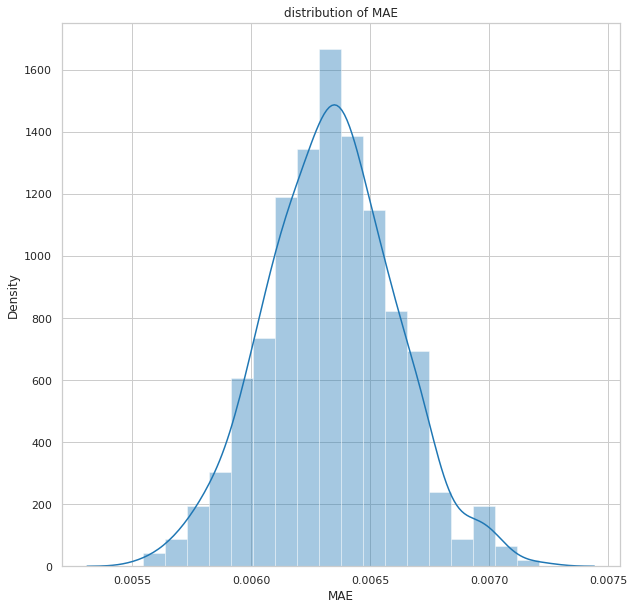

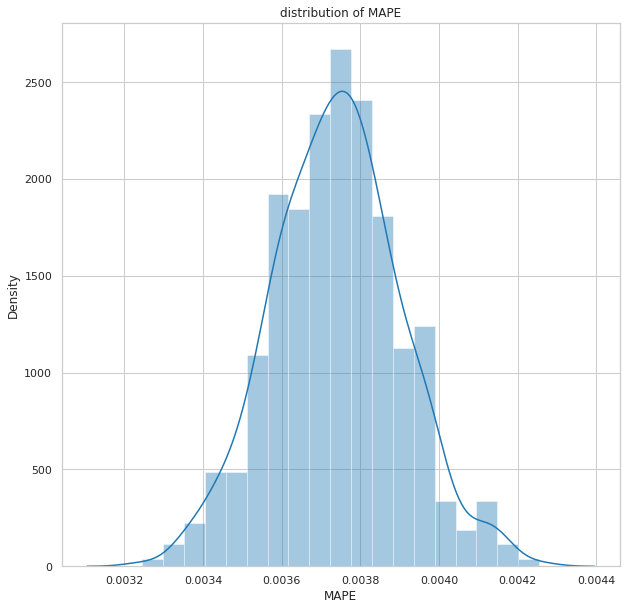

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(mae)
plt.title('distribution of MAE')
plt.xlabel('MAE')
plt.show()

plt.figure(figsize=(10,10))
sns.distplot(mape)
plt.title('distribution of MAPE')
plt.xlabel('MAPE')
plt.show()

In [ ]:
print('Mean of MAE : ', np.mean(mae),'Ahr', '\nMean of MAPE : ', np.mean(mape)*100,'%')
mae_2 = np.mean(mae)
mape_2 = np.mean(mape)

Mean of MAE :  0.006334682488415618 Ahr 
Mean of MAPE :  0.3739933962410828 %


* The randomized model seems to be slightly better than the fixed hyperparameter model as the MAE and MAPE are slightely lower for randomized model

### Flexible Base model

In [397]:
class Custom_model:
  def __init__(self, sample_k, sample_size, base_models = None):
    """
    Parameters:
      sample_k- No of base models 
      sample_size- No of data samples per base model
      base_models- List of base models to choose
    """
    self.k = sample_k
    self.sample_size = sample_size
    self.model_list = base_models

  def sample(self, X, sample_size):
    """
    Parameters:
      X- data
      sample_size- size of samples from X
    Returns:
      data after sampling from X
    """
    return np.random.choice(X, size=sample_size, replace=True)

  def get_model(self, mdl=None):
    """
    Parameters: 
      mdl: model to train
    Returns:
      Initializes and returns a sklearn model object
    """
    if mdl == None:
      m_id = np.random.randint(0,5)
      if m_id == 0:
        return lgb.LGBMRegressor(feature_fraction = 1,max_depth=2,random_state=np.random.randint(0,1000))
      elif m_id == 1:
        return RandomForestRegressor(n_estimators=40, max_depth=5,random_state=np.random.randint(0,1000))
      elif m_id == 2: 
        return AdaBoostRegressor(n_estimators=60,random_state=np.random.randint(0,1000))
      elif m_id == 3:
        return DecisionTreeRegressor(max_depth=5,random_state=np.random.randint(0,1000))
      else:
        return SGDRegressor(loss='squared_error', penalty='l2', alpha=0.1,random_state=np.random.randint(0,1000))
    else:
      if mdl == 'LGBM':
        return lgb.LGBMRegressor(feature_fraction = 1,max_depth=2,random_state=np.random.randint(0,1000))
      elif mdl == 'RF':
        return RandomForestRegressor(n_estimators=40, max_depth=5,random_state=np.random.randint(0,1000))
      elif mdl == 'ADB': 
        return AdaBoostRegressor(n_estimators=60,random_state=np.random.randint(0,1000))
      elif mdl == 'DT':
        return DecisionTreeRegressor(max_depth=5,random_state=np.random.randint(0,1000))
      elif mdl == 'LR':
        return SGDRegressor(loss='squared_error', penalty='l2', alpha=0.01,random_state=np.random.randint(0,1000))
      else:
        raise Exception("Enter valid Model ID")


  def fit(self, D1_x,D2_x, D1_y, D2_y):
    """
    Parameters:
      D1_x, D1_y : D1 part of the data to train base models
      D2_x, D2_y : D2 part of the data to train meta model
    """
    # Sampling base models and data indices
    self.K_IDs = [self.sample(D1_x.index.tolist(), self.sample_size) for _ in  range(self.k)]
    if self.model_list == None:
      self.base_models = [self.get_model() for _ in range(self.k)]
    else:
      self.base_models = [self.get_model(np.random.choice(self.model_list)) for _ in range(self.k)]
    
    print('Training Base models')
    for i in (range(self.k)):
      D1_x_i = D1_x.loc[self.K_IDs[i]]
      D1_y_i = D1_y.loc[self.K_IDs[i]]
      self.base_models[i].fit(D1_x_i, D1_y_i)

    # Input for meta model
    self.meta_data_x = pd.DataFrame()
    for i in range(self.k):
      preds = pd.DataFrame(self.base_models[i].predict(D2_x),columns=['input_'+str(i)])
      self.meta_data_x = pd.concat([self.meta_data_x,preds], axis=1, ignore_index = True)
    self.meta_data_y = D2_y

    print('Training Meta model')
    self.meta_model = RandomForestRegressor(n_estimators=40, max_depth=None)
    self.meta_model.fit(self.meta_data_x, self.meta_data_y)
    print('Done')

  def predict(self, data):
    """
    Parameters:
      data: Test data to predit
    Returns:
      predicted data
    """
    meta_data_input = pd.DataFrame()
    for i in range(self.k):
      preds = pd.DataFrame(self.base_models[i].predict(data),columns=['input'])
      meta_data_input = pd.concat([meta_data_input,preds], axis=1, ignore_index = True)
    meta_pred = self.meta_model.predict(meta_data_input)
    return meta_pred

model = Custom_model(16, 256, base_models = ['RF','DT','LGBM'])
model.fit(X_train_1, X_train_2, y_train_1, y_train_2)
y_test_pred = model.predict(X_test)
mean_absolute_error(y_test,y_test_pred)

Training Base models
Training Meta model
Done


0.005783281189996837

In [404]:
mae = []
mape = []
for _ in tqdm(range(500)):
  model = Custom_model(16, 256, base_models = ['RF','LGBM'])
  model.fit(X_train_1, X_train_2, y_train_1, y_train_2)
  y_test_pred = model.predict(X_test)
  mae.append(mean_absolute_error(y_test,y_test_pred))
  mape.append(mean_absolute_percentage_error(y_test,y_test_pred))

  0%|          | 0/500 [00:00<?, ?it/s]

Training Base models
Training Meta model
Done


  0%|          | 1/500 [00:01<09:23,  1.13s/it]

Training Base models
Training Meta model
Done


  0%|          | 2/500 [00:02<10:29,  1.26s/it]

Training Base models
Training Meta model
Done


  1%|          | 3/500 [00:03<10:31,  1.27s/it]

Training Base models
Training Meta model
Done


  1%|          | 4/500 [00:05<11:04,  1.34s/it]

Training Base models
Training Meta model
Done


  1%|          | 5/500 [00:06<11:13,  1.36s/it]

Training Base models
Training Meta model
Done


  1%|          | 6/500 [00:07<10:18,  1.25s/it]

Training Base models
Training Meta model
Done


  1%|▏         | 7/500 [00:09<10:40,  1.30s/it]

Training Base models
Training Meta model
Done


  2%|▏         | 8/500 [00:10<10:52,  1.33s/it]

Training Base models
Training Meta model
Done


  2%|▏         | 9/500 [00:11<10:40,  1.30s/it]

Training Base models
Training Meta model
Done


  2%|▏         | 10/500 [00:13<11:16,  1.38s/it]

Training Base models
Training Meta model
Done


  2%|▏         | 11/500 [00:14<10:59,  1.35s/it]

Training Base models
Training Meta model
Done


  2%|▏         | 12/500 [00:15<10:01,  1.23s/it]

Training Base models
Training Meta model
Done


  3%|▎         | 13/500 [00:16<10:08,  1.25s/it]

Training Base models
Training Meta model
Done


  3%|▎         | 14/500 [00:17<09:55,  1.23s/it]

Training Base models
Training Meta model
Done


  3%|▎         | 15/500 [00:19<10:44,  1.33s/it]

Training Base models
Training Meta model
Done


  3%|▎         | 16/500 [00:20<10:29,  1.30s/it]

Training Base models
Training Meta model
Done


  3%|▎         | 17/500 [00:21<10:11,  1.27s/it]

Training Base models
Training Meta model
Done


  4%|▎         | 18/500 [00:23<10:23,  1.29s/it]

Training Base models
Training Meta model
Done


  4%|▍         | 19/500 [00:24<10:16,  1.28s/it]

Training Base models
Training Meta model
Done


  4%|▍         | 20/500 [00:25<09:37,  1.20s/it]

Training Base models
Training Meta model
Done


  4%|▍         | 21/500 [00:26<09:45,  1.22s/it]

Training Base models
Training Meta model
Done


  4%|▍         | 22/500 [00:28<09:59,  1.25s/it]

Training Base models
Training Meta model
Done


  5%|▍         | 23/500 [00:29<09:39,  1.21s/it]

Training Base models
Training Meta model
Done


  5%|▍         | 24/500 [00:30<09:55,  1.25s/it]

Training Base models
Training Meta model
Done


  5%|▌         | 25/500 [00:31<09:54,  1.25s/it]

Training Base models
Training Meta model
Done


  5%|▌         | 26/500 [00:33<10:16,  1.30s/it]

Training Base models
Training Meta model
Done


  5%|▌         | 27/500 [00:34<10:51,  1.38s/it]

Training Base models
Training Meta model
Done


  6%|▌         | 28/500 [00:35<10:05,  1.28s/it]

Training Base models
Training Meta model
Done


  6%|▌         | 29/500 [00:37<10:05,  1.29s/it]

Training Base models
Training Meta model
Done


  6%|▌         | 30/500 [00:38<09:45,  1.25s/it]

Training Base models
Training Meta model
Done


  6%|▌         | 31/500 [00:39<10:39,  1.36s/it]

Training Base models
Training Meta model
Done


  6%|▋         | 32/500 [00:41<10:09,  1.30s/it]

Training Base models
Training Meta model
Done


  7%|▋         | 33/500 [00:42<10:20,  1.33s/it]

Training Base models
Training Meta model
Done


  7%|▋         | 34/500 [00:43<10:07,  1.30s/it]

Training Base models
Training Meta model
Done


  7%|▋         | 35/500 [00:45<10:14,  1.32s/it]

Training Base models
Training Meta model
Done


  7%|▋         | 36/500 [00:46<09:44,  1.26s/it]

Training Base models
Training Meta model
Done


  7%|▋         | 37/500 [00:47<09:44,  1.26s/it]

Training Base models
Training Meta model
Done


  8%|▊         | 38/500 [00:49<10:25,  1.35s/it]

Training Base models
Training Meta model
Done


  8%|▊         | 39/500 [00:49<09:19,  1.21s/it]

Training Base models
Training Meta model
Done


  8%|▊         | 40/500 [00:51<09:51,  1.29s/it]

Training Base models
Training Meta model
Done


  8%|▊         | 41/500 [00:52<10:01,  1.31s/it]

Training Base models
Training Meta model
Done


  8%|▊         | 42/500 [00:54<10:04,  1.32s/it]

Training Base models
Training Meta model
Done


  9%|▊         | 43/500 [00:55<09:59,  1.31s/it]

Training Base models
Training Meta model
Done


  9%|▉         | 44/500 [00:56<10:16,  1.35s/it]

Training Base models
Training Meta model
Done


  9%|▉         | 45/500 [00:58<10:42,  1.41s/it]

Training Base models
Training Meta model
Done


  9%|▉         | 46/500 [00:59<10:00,  1.32s/it]

Training Base models
Training Meta model
Done


  9%|▉         | 47/500 [01:00<09:40,  1.28s/it]

Training Base models
Training Meta model
Done


 10%|▉         | 48/500 [01:02<09:54,  1.31s/it]

Training Base models
Training Meta model
Done


 10%|▉         | 49/500 [01:03<09:37,  1.28s/it]

Training Base models
Training Meta model
Done


 10%|█         | 50/500 [01:04<09:36,  1.28s/it]

Training Base models
Training Meta model
Done


 10%|█         | 51/500 [01:05<09:08,  1.22s/it]

Training Base models
Training Meta model
Done


 10%|█         | 52/500 [01:07<09:26,  1.26s/it]

Training Base models
Training Meta model
Done


 11%|█         | 53/500 [01:08<09:01,  1.21s/it]

Training Base models
Training Meta model
Done


 11%|█         | 54/500 [01:09<09:38,  1.30s/it]

Training Base models
Training Meta model
Done


 11%|█         | 55/500 [01:10<09:43,  1.31s/it]

Training Base models
Training Meta model
Done


 11%|█         | 56/500 [01:12<09:19,  1.26s/it]

Training Base models
Training Meta model
Done


 11%|█▏        | 57/500 [01:13<09:17,  1.26s/it]

Training Base models
Training Meta model
Done


 12%|█▏        | 58/500 [01:14<09:18,  1.26s/it]

Training Base models
Training Meta model
Done


 12%|█▏        | 59/500 [01:15<09:15,  1.26s/it]

Training Base models
Training Meta model
Done


 12%|█▏        | 60/500 [01:16<08:35,  1.17s/it]

Training Base models
Training Meta model
Done


 12%|█▏        | 61/500 [01:18<08:56,  1.22s/it]

Training Base models
Training Meta model
Done


 12%|█▏        | 62/500 [01:19<08:39,  1.19s/it]

Training Base models
Training Meta model
Done


 13%|█▎        | 63/500 [01:20<09:24,  1.29s/it]

Training Base models
Training Meta model
Done


 13%|█▎        | 64/500 [01:22<09:22,  1.29s/it]

Training Base models
Training Meta model
Done


 13%|█▎        | 65/500 [01:23<09:37,  1.33s/it]

Training Base models
Training Meta model
Done


 13%|█▎        | 66/500 [01:25<09:57,  1.38s/it]

Training Base models
Training Meta model
Done


 13%|█▎        | 67/500 [01:26<09:41,  1.34s/it]

Training Base models
Training Meta model
Done


 14%|█▎        | 68/500 [01:27<08:56,  1.24s/it]

Training Base models
Training Meta model
Done


 14%|█▍        | 69/500 [01:28<08:27,  1.18s/it]

Training Base models
Training Meta model
Done


 14%|█▍        | 70/500 [01:29<09:04,  1.27s/it]

Training Base models
Training Meta model
Done


 14%|█▍        | 71/500 [01:30<08:40,  1.21s/it]

Training Base models
Training Meta model
Done


 14%|█▍        | 72/500 [01:32<08:44,  1.22s/it]

Training Base models
Training Meta model
Done


 15%|█▍        | 73/500 [01:33<09:14,  1.30s/it]

Training Base models
Training Meta model
Done


 15%|█▍        | 74/500 [01:34<09:16,  1.31s/it]

Training Base models
Training Meta model
Done


 15%|█▌        | 75/500 [01:36<08:48,  1.24s/it]

Training Base models
Training Meta model
Done


 15%|█▌        | 76/500 [01:37<08:50,  1.25s/it]

Training Base models
Training Meta model
Done


 15%|█▌        | 77/500 [01:38<09:14,  1.31s/it]

Training Base models
Training Meta model
Done


 16%|█▌        | 78/500 [01:40<09:06,  1.30s/it]

Training Base models
Training Meta model
Done


 16%|█▌        | 79/500 [01:41<08:50,  1.26s/it]

Training Base models
Training Meta model
Done


 16%|█▌        | 80/500 [01:42<09:20,  1.33s/it]

Training Base models
Training Meta model
Done


 16%|█▌        | 81/500 [01:43<08:25,  1.21s/it]

Training Base models
Training Meta model
Done


 16%|█▋        | 82/500 [01:44<08:29,  1.22s/it]

Training Base models
Training Meta model
Done


 17%|█▋        | 83/500 [01:46<08:41,  1.25s/it]

Training Base models
Training Meta model
Done


 17%|█▋        | 84/500 [01:47<08:33,  1.23s/it]

Training Base models
Training Meta model
Done


 17%|█▋        | 85/500 [01:48<08:12,  1.19s/it]

Training Base models
Training Meta model
Done


 17%|█▋        | 86/500 [01:49<08:34,  1.24s/it]

Training Base models
Training Meta model
Done


 17%|█▋        | 87/500 [01:51<09:01,  1.31s/it]

Training Base models
Training Meta model
Done


 18%|█▊        | 88/500 [01:52<08:35,  1.25s/it]

Training Base models
Training Meta model
Done


 18%|█▊        | 89/500 [01:53<08:37,  1.26s/it]

Training Base models
Training Meta model
Done


 18%|█▊        | 90/500 [01:55<08:46,  1.28s/it]

Training Base models
Training Meta model
Done


 18%|█▊        | 91/500 [01:56<08:57,  1.31s/it]

Training Base models
Training Meta model
Done


 18%|█▊        | 92/500 [01:57<09:16,  1.37s/it]

Training Base models
Training Meta model
Done


 19%|█▊        | 93/500 [01:59<09:08,  1.35s/it]

Training Base models
Training Meta model
Done


 19%|█▉        | 94/500 [02:00<08:23,  1.24s/it]

Training Base models
Training Meta model
Done


 19%|█▉        | 95/500 [02:01<08:13,  1.22s/it]

Training Base models
Training Meta model
Done


 19%|█▉        | 96/500 [02:02<08:12,  1.22s/it]

Training Base models
Training Meta model
Done


 19%|█▉        | 97/500 [02:04<08:54,  1.33s/it]

Training Base models
Training Meta model
Done


 20%|█▉        | 98/500 [02:05<08:41,  1.30s/it]

Training Base models
Training Meta model
Done


 20%|█▉        | 99/500 [02:06<09:06,  1.36s/it]

Training Base models
Training Meta model
Done


 20%|██        | 100/500 [02:08<08:53,  1.33s/it]

Training Base models
Training Meta model
Done


 20%|██        | 101/500 [02:09<08:27,  1.27s/it]

Training Base models
Training Meta model
Done


 20%|██        | 102/500 [02:10<07:56,  1.20s/it]

Training Base models
Training Meta model
Done


 21%|██        | 103/500 [02:11<08:19,  1.26s/it]

Training Base models
Training Meta model
Done


 21%|██        | 104/500 [02:13<08:24,  1.27s/it]

Training Base models
Training Meta model
Done


 21%|██        | 105/500 [02:13<07:45,  1.18s/it]

Training Base models
Training Meta model
Done


 21%|██        | 106/500 [02:15<08:17,  1.26s/it]

Training Base models
Training Meta model
Done


 21%|██▏       | 107/500 [02:16<08:27,  1.29s/it]

Training Base models
Training Meta model
Done


 22%|██▏       | 108/500 [02:18<08:29,  1.30s/it]

Training Base models
Training Meta model
Done


 22%|██▏       | 109/500 [02:19<08:16,  1.27s/it]

Training Base models
Training Meta model
Done


 22%|██▏       | 110/500 [02:20<08:25,  1.30s/it]

Training Base models
Training Meta model
Done


 22%|██▏       | 111/500 [02:22<08:30,  1.31s/it]

Training Base models
Training Meta model
Done


 22%|██▏       | 112/500 [02:23<08:08,  1.26s/it]

Training Base models
Training Meta model
Done


 23%|██▎       | 113/500 [02:24<08:14,  1.28s/it]

Training Base models
Training Meta model
Done


 23%|██▎       | 114/500 [02:25<08:15,  1.28s/it]

Training Base models
Training Meta model
Done


 23%|██▎       | 115/500 [02:26<08:01,  1.25s/it]

Training Base models
Training Meta model
Done


 23%|██▎       | 116/500 [02:28<07:51,  1.23s/it]

Training Base models
Training Meta model
Done


 23%|██▎       | 117/500 [02:29<07:58,  1.25s/it]

Training Base models
Training Meta model
Done


 24%|██▎       | 118/500 [02:30<08:16,  1.30s/it]

Training Base models
Training Meta model
Done


 24%|██▍       | 119/500 [02:32<08:12,  1.29s/it]

Training Base models
Training Meta model
Done


 24%|██▍       | 120/500 [02:33<08:11,  1.29s/it]

Training Base models
Training Meta model
Done


 24%|██▍       | 121/500 [02:34<08:08,  1.29s/it]

Training Base models
Training Meta model
Done


 24%|██▍       | 122/500 [02:35<07:50,  1.24s/it]

Training Base models
Training Meta model
Done


 25%|██▍       | 123/500 [02:37<08:14,  1.31s/it]

Training Base models
Training Meta model
Done


 25%|██▍       | 124/500 [02:38<07:51,  1.26s/it]

Training Base models
Training Meta model
Done


 25%|██▌       | 125/500 [02:39<07:54,  1.27s/it]

Training Base models
Training Meta model
Done


 25%|██▌       | 126/500 [02:40<07:42,  1.24s/it]

Training Base models
Training Meta model
Done


 25%|██▌       | 127/500 [02:42<08:10,  1.31s/it]

Training Base models
Training Meta model
Done


 26%|██▌       | 128/500 [02:43<07:47,  1.26s/it]

Training Base models
Training Meta model
Done


 26%|██▌       | 129/500 [02:44<06:56,  1.12s/it]

Training Base models
Training Meta model
Done


 26%|██▌       | 130/500 [02:45<07:11,  1.17s/it]

Training Base models
Training Meta model
Done


 26%|██▌       | 131/500 [02:46<07:17,  1.18s/it]

Training Base models
Training Meta model
Done


 26%|██▋       | 132/500 [02:47<07:11,  1.17s/it]

Training Base models
Training Meta model
Done


 27%|██▋       | 133/500 [02:49<07:54,  1.29s/it]

Training Base models
Training Meta model
Done


 27%|██▋       | 134/500 [02:51<08:17,  1.36s/it]

Training Base models
Training Meta model
Done


 27%|██▋       | 135/500 [02:51<07:24,  1.22s/it]

Training Base models
Training Meta model
Done


 27%|██▋       | 136/500 [02:53<07:45,  1.28s/it]

Training Base models
Training Meta model
Done


 27%|██▋       | 137/500 [02:54<07:47,  1.29s/it]

Training Base models
Training Meta model
Done


 28%|██▊       | 138/500 [02:55<07:34,  1.25s/it]

Training Base models
Training Meta model
Done


 28%|██▊       | 139/500 [02:56<07:20,  1.22s/it]

Training Base models
Training Meta model
Done


 28%|██▊       | 140/500 [02:58<07:05,  1.18s/it]

Training Base models
Training Meta model
Done


 28%|██▊       | 141/500 [02:59<07:02,  1.18s/it]

Training Base models
Training Meta model
Done


 28%|██▊       | 142/500 [03:00<07:10,  1.20s/it]

Training Base models
Training Meta model
Done


 29%|██▊       | 143/500 [03:01<07:16,  1.22s/it]

Training Base models
Training Meta model
Done


 29%|██▉       | 144/500 [03:03<07:17,  1.23s/it]

Training Base models
Training Meta model
Done


 29%|██▉       | 145/500 [03:04<07:37,  1.29s/it]

Training Base models
Training Meta model
Done


 29%|██▉       | 146/500 [03:05<07:23,  1.25s/it]

Training Base models
Training Meta model
Done


 29%|██▉       | 147/500 [03:06<07:17,  1.24s/it]

Training Base models
Training Meta model
Done


 30%|██▉       | 148/500 [03:08<07:19,  1.25s/it]

Training Base models
Training Meta model
Done


 30%|██▉       | 149/500 [03:09<07:28,  1.28s/it]

Training Base models
Training Meta model
Done


 30%|███       | 150/500 [03:10<07:37,  1.31s/it]

Training Base models
Training Meta model
Done


 30%|███       | 151/500 [03:12<07:32,  1.30s/it]

Training Base models
Training Meta model
Done


 30%|███       | 152/500 [03:13<07:25,  1.28s/it]

Training Base models
Training Meta model
Done


 31%|███       | 153/500 [03:14<06:58,  1.20s/it]

Training Base models
Training Meta model
Done


 31%|███       | 154/500 [03:15<07:10,  1.25s/it]

Training Base models
Training Meta model
Done


 31%|███       | 155/500 [03:17<07:18,  1.27s/it]

Training Base models
Training Meta model
Done


 31%|███       | 156/500 [03:18<07:23,  1.29s/it]

Training Base models
Training Meta model
Done


 31%|███▏      | 157/500 [03:19<07:46,  1.36s/it]

Training Base models
Training Meta model
Done


 32%|███▏      | 158/500 [03:21<07:40,  1.35s/it]

Training Base models
Training Meta model
Done


 32%|███▏      | 159/500 [03:22<07:15,  1.28s/it]

Training Base models
Training Meta model
Done


 32%|███▏      | 160/500 [03:23<07:12,  1.27s/it]

Training Base models
Training Meta model
Done


 32%|███▏      | 161/500 [03:24<07:13,  1.28s/it]

Training Base models
Training Meta model
Done


 32%|███▏      | 162/500 [03:25<06:48,  1.21s/it]

Training Base models
Training Meta model
Done


 33%|███▎      | 163/500 [03:27<07:20,  1.31s/it]

Training Base models
Training Meta model
Done


 33%|███▎      | 164/500 [03:28<07:30,  1.34s/it]

Training Base models
Training Meta model
Done


 33%|███▎      | 165/500 [03:29<07:02,  1.26s/it]

Training Base models
Training Meta model
Done


 33%|███▎      | 166/500 [03:31<06:58,  1.25s/it]

Training Base models
Training Meta model
Done


 33%|███▎      | 167/500 [03:32<06:33,  1.18s/it]

Training Base models
Training Meta model
Done


 34%|███▎      | 168/500 [03:33<07:00,  1.27s/it]

Training Base models
Training Meta model
Done


 34%|███▍      | 169/500 [03:34<06:28,  1.17s/it]

Training Base models
Training Meta model
Done


 34%|███▍      | 170/500 [03:36<06:48,  1.24s/it]

Training Base models
Training Meta model
Done


 34%|███▍      | 171/500 [03:37<06:57,  1.27s/it]

Training Base models
Training Meta model
Done


 34%|███▍      | 172/500 [03:38<06:57,  1.27s/it]

Training Base models
Training Meta model
Done


 35%|███▍      | 173/500 [03:39<06:55,  1.27s/it]

Training Base models
Training Meta model
Done


 35%|███▍      | 174/500 [03:41<07:00,  1.29s/it]

Training Base models
Training Meta model
Done


 35%|███▌      | 175/500 [03:42<07:03,  1.30s/it]

Training Base models
Training Meta model
Done


 35%|███▌      | 176/500 [03:43<07:12,  1.33s/it]

Training Base models
Training Meta model
Done


 35%|███▌      | 177/500 [03:45<07:01,  1.30s/it]

Training Base models
Training Meta model
Done


 36%|███▌      | 178/500 [03:46<07:06,  1.33s/it]

Training Base models
Training Meta model
Done


 36%|███▌      | 179/500 [03:47<07:06,  1.33s/it]

Training Base models
Training Meta model
Done


 36%|███▌      | 180/500 [03:49<07:11,  1.35s/it]

Training Base models
Training Meta model
Done


 36%|███▌      | 181/500 [03:50<06:52,  1.29s/it]

Training Base models
Training Meta model
Done


 36%|███▋      | 182/500 [03:51<06:48,  1.28s/it]

Training Base models
Training Meta model
Done


 37%|███▋      | 183/500 [03:52<06:44,  1.28s/it]

Training Base models
Training Meta model
Done


 37%|███▋      | 184/500 [03:54<06:35,  1.25s/it]

Training Base models
Training Meta model
Done


 37%|███▋      | 185/500 [03:55<06:26,  1.23s/it]

Training Base models
Training Meta model
Done


 37%|███▋      | 186/500 [03:56<06:34,  1.26s/it]

Training Base models
Training Meta model
Done


 37%|███▋      | 187/500 [03:58<06:46,  1.30s/it]

Training Base models
Training Meta model
Done


 38%|███▊      | 188/500 [03:59<06:54,  1.33s/it]

Training Base models
Training Meta model
Done


 38%|███▊      | 189/500 [04:00<06:30,  1.26s/it]

Training Base models
Training Meta model
Done


 38%|███▊      | 190/500 [04:02<06:57,  1.35s/it]

Training Base models
Training Meta model
Done


 38%|███▊      | 191/500 [04:03<07:08,  1.39s/it]

Training Base models
Training Meta model
Done


 38%|███▊      | 192/500 [04:04<06:25,  1.25s/it]

Training Base models
Training Meta model
Done


 39%|███▊      | 193/500 [04:05<06:27,  1.26s/it]

Training Base models
Training Meta model
Done


 39%|███▉      | 194/500 [04:07<06:26,  1.26s/it]

Training Base models
Training Meta model
Done


 39%|███▉      | 195/500 [04:08<06:17,  1.24s/it]

Training Base models
Training Meta model
Done


 39%|███▉      | 196/500 [04:09<06:38,  1.31s/it]

Training Base models
Training Meta model
Done


 39%|███▉      | 197/500 [04:11<06:39,  1.32s/it]

Training Base models


 40%|███▉      | 198/500 [04:11<05:47,  1.15s/it]

Training Meta model
Done
Training Base models
Training Meta model
Done


 40%|███▉      | 199/500 [04:13<05:49,  1.16s/it]

Training Base models
Training Meta model
Done


 40%|████      | 200/500 [04:13<05:28,  1.10s/it]

Training Base models
Training Meta model
Done


 40%|████      | 201/500 [04:15<05:43,  1.15s/it]

Training Base models
Training Meta model
Done


 40%|████      | 202/500 [04:16<05:17,  1.07s/it]

Training Base models
Training Meta model
Done


 41%|████      | 203/500 [04:17<05:21,  1.08s/it]

Training Base models
Training Meta model
Done


 41%|████      | 204/500 [04:18<05:54,  1.20s/it]

Training Base models
Training Meta model
Done


 41%|████      | 205/500 [04:19<06:00,  1.22s/it]

Training Base models
Training Meta model
Done


 41%|████      | 206/500 [04:21<06:03,  1.24s/it]

Training Base models
Training Meta model
Done


 41%|████▏     | 207/500 [04:22<05:57,  1.22s/it]

Training Base models
Training Meta model
Done


 42%|████▏     | 208/500 [04:23<05:57,  1.23s/it]

Training Base models
Training Meta model
Done


 42%|████▏     | 209/500 [04:24<05:44,  1.18s/it]

Training Base models
Training Meta model
Done


 42%|████▏     | 210/500 [04:25<05:29,  1.14s/it]

Training Base models
Training Meta model
Done


 42%|████▏     | 211/500 [04:27<05:52,  1.22s/it]

Training Base models
Training Meta model
Done


 42%|████▏     | 212/500 [04:28<06:00,  1.25s/it]

Training Base models
Training Meta model
Done


 43%|████▎     | 213/500 [04:29<06:08,  1.28s/it]

Training Base models
Training Meta model
Done


 43%|████▎     | 214/500 [04:31<06:15,  1.31s/it]

Training Base models
Training Meta model
Done


 43%|████▎     | 215/500 [04:32<06:11,  1.30s/it]

Training Base models
Training Meta model
Done


 43%|████▎     | 216/500 [04:33<06:15,  1.32s/it]

Training Base models
Training Meta model
Done


 43%|████▎     | 217/500 [04:35<06:14,  1.32s/it]

Training Base models
Training Meta model
Done


 44%|████▎     | 218/500 [04:36<06:15,  1.33s/it]

Training Base models
Training Meta model
Done


 44%|████▍     | 219/500 [04:37<05:51,  1.25s/it]

Training Base models
Training Meta model
Done


 44%|████▍     | 220/500 [04:38<05:44,  1.23s/it]

Training Base models
Training Meta model
Done


 44%|████▍     | 221/500 [04:40<05:59,  1.29s/it]

Training Base models
Training Meta model
Done


 44%|████▍     | 222/500 [04:41<06:15,  1.35s/it]

Training Base models
Training Meta model
Done


 45%|████▍     | 223/500 [04:43<06:25,  1.39s/it]

Training Base models
Training Meta model
Done


 45%|████▍     | 224/500 [04:44<06:06,  1.33s/it]

Training Base models
Training Meta model
Done


 45%|████▌     | 225/500 [04:45<06:10,  1.35s/it]

Training Base models
Training Meta model
Done


 45%|████▌     | 226/500 [04:46<05:56,  1.30s/it]

Training Base models
Training Meta model
Done


 45%|████▌     | 227/500 [04:48<05:40,  1.25s/it]

Training Base models
Training Meta model
Done


 46%|████▌     | 228/500 [04:49<05:23,  1.19s/it]

Training Base models
Training Meta model
Done


 46%|████▌     | 229/500 [04:50<05:32,  1.23s/it]

Training Base models
Training Meta model
Done


 46%|████▌     | 230/500 [04:51<05:43,  1.27s/it]

Training Base models
Training Meta model
Done


 46%|████▌     | 231/500 [04:53<05:48,  1.30s/it]

Training Base models
Training Meta model
Done


 46%|████▋     | 232/500 [04:54<06:02,  1.35s/it]

Training Base models
Training Meta model
Done


 47%|████▋     | 233/500 [04:56<06:06,  1.37s/it]

Training Base models
Training Meta model
Done


 47%|████▋     | 234/500 [04:57<05:59,  1.35s/it]

Training Base models
Training Meta model
Done


 47%|████▋     | 235/500 [04:58<05:25,  1.23s/it]

Training Base models
Training Meta model
Done


 47%|████▋     | 236/500 [04:59<05:31,  1.26s/it]

Training Base models
Training Meta model
Done


 47%|████▋     | 237/500 [05:01<05:43,  1.31s/it]

Training Base models
Training Meta model
Done


 48%|████▊     | 238/500 [05:02<05:49,  1.33s/it]

Training Base models
Training Meta model
Done


 48%|████▊     | 239/500 [05:04<06:07,  1.41s/it]

Training Base models
Training Meta model
Done


 48%|████▊     | 240/500 [05:05<05:47,  1.34s/it]

Training Base models
Training Meta model
Done


 48%|████▊     | 241/500 [05:06<05:27,  1.26s/it]

Training Base models
Training Meta model
Done


 48%|████▊     | 242/500 [05:07<05:26,  1.27s/it]

Training Base models
Training Meta model
Done


 49%|████▊     | 243/500 [05:08<05:05,  1.19s/it]

Training Base models
Training Meta model
Done


 49%|████▉     | 244/500 [05:10<05:30,  1.29s/it]

Training Base models
Training Meta model
Done


 49%|████▉     | 245/500 [05:11<05:21,  1.26s/it]

Training Base models
Training Meta model
Done


 49%|████▉     | 246/500 [05:12<05:13,  1.23s/it]

Training Base models
Training Meta model
Done


 49%|████▉     | 247/500 [05:13<05:14,  1.24s/it]

Training Base models
Training Meta model
Done


 50%|████▉     | 248/500 [05:15<05:37,  1.34s/it]

Training Base models
Training Meta model
Done


 50%|████▉     | 249/500 [05:16<05:17,  1.26s/it]

Training Base models
Training Meta model
Done


 50%|█████     | 250/500 [05:17<05:25,  1.30s/it]

Training Base models
Training Meta model
Done


 50%|█████     | 251/500 [05:18<05:02,  1.22s/it]

Training Base models
Training Meta model
Done


 50%|█████     | 252/500 [05:20<05:16,  1.28s/it]

Training Base models
Training Meta model
Done


 51%|█████     | 253/500 [05:21<05:18,  1.29s/it]

Training Base models
Training Meta model
Done


 51%|█████     | 254/500 [05:22<05:22,  1.31s/it]

Training Base models
Training Meta model
Done


 51%|█████     | 255/500 [05:24<05:05,  1.25s/it]

Training Base models
Training Meta model
Done


 51%|█████     | 256/500 [05:25<05:03,  1.24s/it]

Training Base models
Training Meta model
Done


 51%|█████▏    | 257/500 [05:26<04:53,  1.21s/it]

Training Base models
Training Meta model
Done


 52%|█████▏    | 258/500 [05:27<04:57,  1.23s/it]

Training Base models
Training Meta model
Done


 52%|█████▏    | 259/500 [05:28<04:43,  1.18s/it]

Training Base models
Training Meta model
Done


 52%|█████▏    | 260/500 [05:29<04:46,  1.19s/it]

Training Base models
Training Meta model
Done


 52%|█████▏    | 261/500 [05:31<04:44,  1.19s/it]

Training Base models
Training Meta model
Done


 52%|█████▏    | 262/500 [05:32<04:52,  1.23s/it]

Training Base models
Training Meta model
Done


 53%|█████▎    | 263/500 [05:33<05:07,  1.30s/it]

Training Base models
Training Meta model
Done


 53%|█████▎    | 264/500 [05:35<04:53,  1.25s/it]

Training Base models
Training Meta model
Done


 53%|█████▎    | 265/500 [05:36<04:42,  1.20s/it]

Training Base models
Training Meta model
Done


 53%|█████▎    | 266/500 [05:37<04:49,  1.24s/it]

Training Base models
Training Meta model
Done


 53%|█████▎    | 267/500 [05:38<04:45,  1.22s/it]

Training Base models
Training Meta model
Done


 54%|█████▎    | 268/500 [05:40<05:00,  1.30s/it]

Training Base models
Training Meta model
Done


 54%|█████▍    | 269/500 [05:41<04:58,  1.29s/it]

Training Base models
Training Meta model
Done


 54%|█████▍    | 270/500 [05:42<04:38,  1.21s/it]

Training Base models
Training Meta model
Done


 54%|█████▍    | 271/500 [05:43<04:30,  1.18s/it]

Training Base models
Training Meta model
Done


 54%|█████▍    | 272/500 [05:45<04:48,  1.26s/it]

Training Base models
Training Meta model
Done


 55%|█████▍    | 273/500 [05:46<04:51,  1.29s/it]

Training Base models
Training Meta model
Done


 55%|█████▍    | 274/500 [05:47<04:34,  1.21s/it]

Training Base models
Training Meta model
Done


 55%|█████▌    | 275/500 [05:48<04:43,  1.26s/it]

Training Base models
Training Meta model
Done


 55%|█████▌    | 276/500 [05:50<04:47,  1.28s/it]

Training Base models
Training Meta model
Done


 55%|█████▌    | 277/500 [05:51<04:29,  1.21s/it]

Training Base models
Training Meta model
Done


 56%|█████▌    | 278/500 [05:52<04:33,  1.23s/it]

Training Base models
Training Meta model
Done


 56%|█████▌    | 279/500 [05:53<04:36,  1.25s/it]

Training Base models
Training Meta model
Done


 56%|█████▌    | 280/500 [05:55<04:43,  1.29s/it]

Training Base models
Training Meta model
Done


 56%|█████▌    | 281/500 [05:56<04:35,  1.26s/it]

Training Base models
Training Meta model
Done


 56%|█████▋    | 282/500 [05:57<04:43,  1.30s/it]

Training Base models
Training Meta model
Done


 57%|█████▋    | 283/500 [05:58<04:39,  1.29s/it]

Training Base models
Training Meta model
Done


 57%|█████▋    | 284/500 [06:00<04:42,  1.31s/it]

Training Base models
Training Meta model
Done


 57%|█████▋    | 285/500 [06:01<04:45,  1.33s/it]

Training Base models
Training Meta model
Done


 57%|█████▋    | 286/500 [06:03<04:45,  1.33s/it]

Training Base models
Training Meta model
Done


 57%|█████▋    | 287/500 [06:04<04:30,  1.27s/it]

Training Base models
Training Meta model
Done


 58%|█████▊    | 288/500 [06:05<04:35,  1.30s/it]

Training Base models
Training Meta model
Done


 58%|█████▊    | 289/500 [06:06<04:41,  1.34s/it]

Training Base models
Training Meta model
Done


 58%|█████▊    | 290/500 [06:08<04:43,  1.35s/it]

Training Base models
Training Meta model
Done


 58%|█████▊    | 291/500 [06:09<04:48,  1.38s/it]

Training Base models
Training Meta model
Done


 58%|█████▊    | 292/500 [06:11<05:14,  1.51s/it]

Training Base models
Training Meta model
Done


 59%|█████▊    | 293/500 [06:12<04:46,  1.38s/it]

Training Base models
Training Meta model
Done


 59%|█████▉    | 294/500 [06:13<04:39,  1.36s/it]

Training Base models
Training Meta model
Done


 59%|█████▉    | 295/500 [06:15<04:37,  1.35s/it]

Training Base models
Training Meta model
Done


 59%|█████▉    | 296/500 [06:16<04:37,  1.36s/it]

Training Base models
Training Meta model
Done


 59%|█████▉    | 297/500 [06:17<04:34,  1.35s/it]

Training Base models
Training Meta model
Done


 60%|█████▉    | 298/500 [06:19<04:25,  1.31s/it]

Training Base models
Training Meta model
Done


 60%|█████▉    | 299/500 [06:20<04:32,  1.36s/it]

Training Base models
Training Meta model
Done


 60%|██████    | 300/500 [06:21<04:26,  1.33s/it]

Training Base models
Training Meta model
Done


 60%|██████    | 301/500 [06:23<04:21,  1.31s/it]

Training Base models
Training Meta model
Done


 60%|██████    | 302/500 [06:24<04:07,  1.25s/it]

Training Base models
Training Meta model
Done


 61%|██████    | 303/500 [06:25<04:00,  1.22s/it]

Training Base models
Training Meta model
Done


 61%|██████    | 304/500 [06:26<04:06,  1.26s/it]

Training Base models
Training Meta model
Done


 61%|██████    | 305/500 [06:28<04:01,  1.24s/it]

Training Base models
Training Meta model
Done


 61%|██████    | 306/500 [06:29<04:03,  1.26s/it]

Training Base models
Training Meta model
Done


 61%|██████▏   | 307/500 [06:30<04:07,  1.28s/it]

Training Base models
Training Meta model
Done


 62%|██████▏   | 308/500 [06:32<04:22,  1.36s/it]

Training Base models
Training Meta model
Done


 62%|██████▏   | 309/500 [06:33<04:00,  1.26s/it]

Training Base models
Training Meta model
Done


 62%|██████▏   | 310/500 [06:34<03:52,  1.22s/it]

Training Base models
Training Meta model
Done


 62%|██████▏   | 311/500 [06:35<03:44,  1.19s/it]

Training Base models
Training Meta model
Done


 62%|██████▏   | 312/500 [06:36<03:52,  1.23s/it]

Training Base models
Training Meta model
Done


 63%|██████▎   | 313/500 [06:38<03:53,  1.25s/it]

Training Base models
Training Meta model
Done


 63%|██████▎   | 314/500 [06:39<03:57,  1.28s/it]

Training Base models
Training Meta model
Done


 63%|██████▎   | 315/500 [06:40<04:04,  1.32s/it]

Training Base models
Training Meta model
Done


 63%|██████▎   | 316/500 [06:42<04:10,  1.36s/it]

Training Base models
Training Meta model
Done


 63%|██████▎   | 317/500 [06:43<03:53,  1.28s/it]

Training Base models
Training Meta model
Done


 64%|██████▎   | 318/500 [06:44<03:53,  1.28s/it]

Training Base models
Training Meta model
Done


 64%|██████▍   | 319/500 [06:45<03:46,  1.25s/it]

Training Base models
Training Meta model
Done


 64%|██████▍   | 320/500 [06:47<03:45,  1.25s/it]

Training Base models
Training Meta model
Done


 64%|██████▍   | 321/500 [06:48<03:44,  1.25s/it]

Training Base models
Training Meta model
Done


 64%|██████▍   | 322/500 [06:49<04:01,  1.36s/it]

Training Base models
Training Meta model
Done


 65%|██████▍   | 323/500 [06:51<03:56,  1.33s/it]

Training Base models
Training Meta model
Done


 65%|██████▍   | 324/500 [06:52<04:06,  1.40s/it]

Training Base models
Training Meta model
Done


 65%|██████▌   | 325/500 [06:54<03:59,  1.37s/it]

Training Base models
Training Meta model
Done


 65%|██████▌   | 326/500 [06:55<03:59,  1.38s/it]

Training Base models
Training Meta model
Done


 65%|██████▌   | 327/500 [06:56<04:02,  1.40s/it]

Training Base models
Training Meta model
Done


 66%|██████▌   | 328/500 [06:57<03:41,  1.29s/it]

Training Base models
Training Meta model
Done


 66%|██████▌   | 329/500 [06:59<03:26,  1.21s/it]

Training Base models
Training Meta model
Done


 66%|██████▌   | 330/500 [07:00<03:19,  1.17s/it]

Training Base models
Training Meta model
Done


 66%|██████▌   | 331/500 [07:01<03:32,  1.26s/it]

Training Base models
Training Meta model
Done


 66%|██████▋   | 332/500 [07:02<03:19,  1.19s/it]

Training Base models
Training Meta model
Done


 67%|██████▋   | 333/500 [07:03<03:18,  1.19s/it]

Training Base models
Training Meta model
Done


 67%|██████▋   | 334/500 [07:05<03:28,  1.26s/it]

Training Base models
Training Meta model
Done


 67%|██████▋   | 335/500 [07:06<03:38,  1.32s/it]

Training Base models
Training Meta model
Done


 67%|██████▋   | 336/500 [07:07<03:36,  1.32s/it]

Training Base models
Training Meta model
Done


 67%|██████▋   | 337/500 [07:09<03:32,  1.30s/it]

Training Base models
Training Meta model
Done


 68%|██████▊   | 338/500 [07:10<03:35,  1.33s/it]

Training Base models
Training Meta model
Done


 68%|██████▊   | 339/500 [07:11<03:25,  1.28s/it]

Training Base models
Training Meta model
Done


 68%|██████▊   | 340/500 [07:12<03:12,  1.20s/it]

Training Base models
Training Meta model
Done


 68%|██████▊   | 341/500 [07:13<03:07,  1.18s/it]

Training Base models
Training Meta model
Done


 68%|██████▊   | 342/500 [07:15<03:04,  1.17s/it]

Training Base models
Training Meta model
Done


 69%|██████▊   | 343/500 [07:16<03:08,  1.20s/it]

Training Base models
Training Meta model
Done


 69%|██████▉   | 344/500 [07:17<03:07,  1.20s/it]

Training Base models
Training Meta model
Done


 69%|██████▉   | 345/500 [07:18<03:09,  1.22s/it]

Training Base models
Training Meta model
Done


 69%|██████▉   | 346/500 [07:20<03:05,  1.21s/it]

Training Base models
Training Meta model
Done


 69%|██████▉   | 347/500 [07:21<03:06,  1.22s/it]

Training Base models
Training Meta model
Done


 70%|██████▉   | 348/500 [07:22<03:06,  1.23s/it]

Training Base models
Training Meta model
Done


 70%|██████▉   | 349/500 [07:23<03:07,  1.24s/it]

Training Base models
Training Meta model
Done


 70%|███████   | 350/500 [07:24<03:04,  1.23s/it]

Training Base models
Training Meta model
Done


 70%|███████   | 351/500 [07:26<03:07,  1.26s/it]

Training Base models
Training Meta model
Done


 70%|███████   | 352/500 [07:27<03:06,  1.26s/it]

Training Base models
Training Meta model
Done


 71%|███████   | 353/500 [07:28<03:04,  1.26s/it]

Training Base models
Training Meta model
Done


 71%|███████   | 354/500 [07:30<03:00,  1.24s/it]

Training Base models
Training Meta model
Done


 71%|███████   | 355/500 [07:31<02:56,  1.22s/it]

Training Base models
Training Meta model
Done


 71%|███████   | 356/500 [07:32<03:00,  1.25s/it]

Training Base models
Training Meta model
Done


 71%|███████▏  | 357/500 [07:33<02:57,  1.24s/it]

Training Base models
Training Meta model
Done


 72%|███████▏  | 358/500 [07:35<03:03,  1.29s/it]

Training Base models
Training Meta model
Done


 72%|███████▏  | 359/500 [07:36<03:07,  1.33s/it]

Training Base models
Training Meta model
Done


 72%|███████▏  | 360/500 [07:37<03:01,  1.29s/it]

Training Base models
Training Meta model
Done


 72%|███████▏  | 361/500 [07:39<03:01,  1.30s/it]

Training Base models
Training Meta model
Done


 72%|███████▏  | 362/500 [07:40<02:52,  1.25s/it]

Training Base models
Training Meta model
Done


 73%|███████▎  | 363/500 [07:41<02:58,  1.30s/it]

Training Base models
Training Meta model
Done


 73%|███████▎  | 364/500 [07:42<02:53,  1.28s/it]

Training Base models
Training Meta model
Done


 73%|███████▎  | 365/500 [07:44<03:02,  1.35s/it]

Training Base models
Training Meta model
Done


 73%|███████▎  | 366/500 [07:45<02:47,  1.25s/it]

Training Base models
Training Meta model
Done


 73%|███████▎  | 367/500 [07:46<02:49,  1.28s/it]

Training Base models
Training Meta model
Done


 74%|███████▎  | 368/500 [07:48<02:51,  1.30s/it]

Training Base models
Training Meta model
Done


 74%|███████▍  | 369/500 [07:49<02:53,  1.32s/it]

Training Base models
Training Meta model
Done


 74%|███████▍  | 370/500 [07:50<02:56,  1.35s/it]

Training Base models
Training Meta model
Done


 74%|███████▍  | 371/500 [07:52<02:53,  1.35s/it]

Training Base models
Training Meta model
Done


 74%|███████▍  | 372/500 [07:53<02:37,  1.23s/it]

Training Base models
Training Meta model
Done


 75%|███████▍  | 373/500 [07:54<02:49,  1.34s/it]

Training Base models
Training Meta model
Done


 75%|███████▍  | 374/500 [07:55<02:42,  1.29s/it]

Training Base models
Training Meta model
Done


 75%|███████▌  | 375/500 [07:57<02:43,  1.31s/it]

Training Base models
Training Meta model
Done


 75%|███████▌  | 376/500 [07:58<02:50,  1.38s/it]

Training Base models
Training Meta model
Done


 75%|███████▌  | 377/500 [08:00<02:46,  1.35s/it]

Training Base models
Training Meta model
Done


 76%|███████▌  | 378/500 [08:01<02:35,  1.28s/it]

Training Base models
Training Meta model
Done


 76%|███████▌  | 379/500 [08:02<02:30,  1.25s/it]

Training Base models
Training Meta model
Done


 76%|███████▌  | 380/500 [08:03<02:24,  1.21s/it]

Training Base models
Training Meta model
Done


 76%|███████▌  | 381/500 [08:04<02:26,  1.23s/it]

Training Base models
Training Meta model
Done


 76%|███████▋  | 382/500 [08:05<02:21,  1.20s/it]

Training Base models
Training Meta model
Done


 77%|███████▋  | 383/500 [08:07<02:27,  1.26s/it]

Training Base models
Training Meta model
Done


 77%|███████▋  | 384/500 [08:08<02:26,  1.27s/it]

Training Base models
Training Meta model
Done


 77%|███████▋  | 385/500 [08:09<02:22,  1.24s/it]

Training Base models
Training Meta model
Done


 77%|███████▋  | 386/500 [08:10<02:11,  1.15s/it]

Training Base models
Training Meta model
Done


 77%|███████▋  | 387/500 [08:11<02:08,  1.14s/it]

Training Base models
Training Meta model
Done


 78%|███████▊  | 388/500 [08:13<02:12,  1.18s/it]

Training Base models
Training Meta model
Done


 78%|███████▊  | 389/500 [08:14<02:15,  1.22s/it]

Training Base models
Training Meta model
Done


 78%|███████▊  | 390/500 [08:15<02:10,  1.19s/it]

Training Base models
Training Meta model
Done


 78%|███████▊  | 391/500 [08:16<02:11,  1.21s/it]

Training Base models
Training Meta model
Done


 78%|███████▊  | 392/500 [08:18<02:12,  1.23s/it]

Training Base models
Training Meta model
Done


 79%|███████▊  | 393/500 [08:19<02:10,  1.22s/it]

Training Base models
Training Meta model
Done


 79%|███████▉  | 394/500 [08:20<02:11,  1.24s/it]

Training Base models
Training Meta model
Done


 79%|███████▉  | 395/500 [08:21<02:04,  1.19s/it]

Training Base models
Training Meta model
Done


 79%|███████▉  | 396/500 [08:22<02:04,  1.20s/it]

Training Base models
Training Meta model
Done


 79%|███████▉  | 397/500 [08:23<01:58,  1.15s/it]

Training Base models
Training Meta model
Done


 80%|███████▉  | 398/500 [08:25<02:05,  1.23s/it]

Training Base models
Training Meta model
Done


 80%|███████▉  | 399/500 [08:26<02:11,  1.30s/it]

Training Base models
Training Meta model
Done


 80%|████████  | 400/500 [08:27<02:06,  1.27s/it]

Training Base models
Training Meta model
Done


 80%|████████  | 401/500 [08:29<02:11,  1.33s/it]

Training Base models
Training Meta model
Done


 80%|████████  | 402/500 [08:30<02:12,  1.35s/it]

Training Base models
Training Meta model
Done


 81%|████████  | 403/500 [08:31<02:04,  1.28s/it]

Training Base models
Training Meta model
Done


 81%|████████  | 404/500 [08:33<01:59,  1.25s/it]

Training Base models
Training Meta model
Done


 81%|████████  | 405/500 [08:34<01:57,  1.24s/it]

Training Base models
Training Meta model
Done


 81%|████████  | 406/500 [08:35<02:03,  1.32s/it]

Training Base models
Training Meta model
Done


 81%|████████▏ | 407/500 [08:37<01:59,  1.28s/it]

Training Base models
Training Meta model
Done


 82%|████████▏ | 408/500 [08:38<01:59,  1.30s/it]

Training Base models
Training Meta model
Done


 82%|████████▏ | 409/500 [08:39<02:01,  1.33s/it]

Training Base models
Training Meta model
Done


 82%|████████▏ | 410/500 [08:41<02:02,  1.36s/it]

Training Base models
Training Meta model
Done


 82%|████████▏ | 411/500 [08:42<01:52,  1.27s/it]

Training Base models
Training Meta model
Done


 82%|████████▏ | 412/500 [08:43<01:48,  1.23s/it]

Training Base models
Training Meta model
Done


 83%|████████▎ | 413/500 [08:44<01:48,  1.24s/it]

Training Base models
Training Meta model
Done


 83%|████████▎ | 414/500 [08:46<01:52,  1.31s/it]

Training Base models
Training Meta model
Done


 83%|████████▎ | 415/500 [08:47<01:55,  1.36s/it]

Training Base models
Training Meta model
Done


 83%|████████▎ | 416/500 [08:49<02:02,  1.46s/it]

Training Base models
Training Meta model
Done


 83%|████████▎ | 417/500 [08:50<01:51,  1.34s/it]

Training Base models
Training Meta model
Done


 84%|████████▎ | 418/500 [08:51<01:50,  1.35s/it]

Training Base models
Training Meta model
Done


 84%|████████▍ | 419/500 [08:53<01:48,  1.33s/it]

Training Base models
Training Meta model
Done


 84%|████████▍ | 420/500 [08:54<01:47,  1.35s/it]

Training Base models
Training Meta model
Done


 84%|████████▍ | 421/500 [08:55<01:44,  1.32s/it]

Training Base models
Training Meta model
Done


 84%|████████▍ | 422/500 [08:56<01:38,  1.26s/it]

Training Base models
Training Meta model
Done


 85%|████████▍ | 423/500 [08:58<01:42,  1.33s/it]

Training Base models
Training Meta model
Done


 85%|████████▍ | 424/500 [08:59<01:35,  1.26s/it]

Training Base models
Training Meta model
Done


 85%|████████▌ | 425/500 [09:00<01:34,  1.26s/it]

Training Base models
Training Meta model
Done


 85%|████████▌ | 426/500 [09:01<01:31,  1.24s/it]

Training Base models
Training Meta model
Done


 85%|████████▌ | 427/500 [09:03<01:28,  1.22s/it]

Training Base models
Training Meta model
Done


 86%|████████▌ | 428/500 [09:04<01:33,  1.31s/it]

Training Base models
Training Meta model
Done


 86%|████████▌ | 429/500 [09:05<01:31,  1.29s/it]

Training Base models
Training Meta model
Done


 86%|████████▌ | 430/500 [09:07<01:34,  1.35s/it]

Training Base models
Training Meta model
Done


 86%|████████▌ | 431/500 [09:08<01:27,  1.27s/it]

Training Base models
Training Meta model
Done


 86%|████████▋ | 432/500 [09:09<01:27,  1.29s/it]

Training Base models
Training Meta model
Done


 87%|████████▋ | 433/500 [09:10<01:23,  1.24s/it]

Training Base models
Training Meta model
Done


 87%|████████▋ | 434/500 [09:11<01:17,  1.17s/it]

Training Base models
Training Meta model
Done


 87%|████████▋ | 435/500 [09:12<01:14,  1.15s/it]

Training Base models
Training Meta model
Done


 87%|████████▋ | 436/500 [09:14<01:12,  1.14s/it]

Training Base models
Training Meta model
Done


 87%|████████▋ | 437/500 [09:15<01:12,  1.15s/it]

Training Base models
Training Meta model
Done


 88%|████████▊ | 438/500 [09:16<01:14,  1.19s/it]

Training Base models
Training Meta model
Done


 88%|████████▊ | 439/500 [09:17<01:12,  1.19s/it]

Training Base models
Training Meta model
Done


 88%|████████▊ | 440/500 [09:19<01:13,  1.23s/it]

Training Base models
Training Meta model
Done


 88%|████████▊ | 441/500 [09:20<01:14,  1.26s/it]

Training Base models
Training Meta model
Done


 88%|████████▊ | 442/500 [09:21<01:13,  1.27s/it]

Training Base models
Training Meta model
Done


 89%|████████▊ | 443/500 [09:23<01:14,  1.32s/it]

Training Base models
Training Meta model
Done


 89%|████████▉ | 444/500 [09:24<01:17,  1.38s/it]

Training Base models
Training Meta model
Done


 89%|████████▉ | 445/500 [09:25<01:10,  1.28s/it]

Training Base models
Training Meta model
Done


 89%|████████▉ | 446/500 [09:27<01:11,  1.33s/it]

Training Base models
Training Meta model
Done


 89%|████████▉ | 447/500 [09:28<01:07,  1.27s/it]

Training Base models
Training Meta model
Done


 90%|████████▉ | 448/500 [09:29<01:03,  1.22s/it]

Training Base models
Training Meta model
Done


 90%|████████▉ | 449/500 [09:30<00:59,  1.17s/it]

Training Base models
Training Meta model
Done


 90%|█████████ | 450/500 [09:31<01:02,  1.24s/it]

Training Base models
Training Meta model
Done


 90%|█████████ | 451/500 [09:33<01:03,  1.29s/it]

Training Base models
Training Meta model
Done


 90%|█████████ | 452/500 [09:34<01:01,  1.29s/it]

Training Base models
Training Meta model
Done


 91%|█████████ | 453/500 [09:35<01:02,  1.32s/it]

Training Base models
Training Meta model
Done


 91%|█████████ | 454/500 [09:37<00:59,  1.28s/it]

Training Base models
Training Meta model
Done


 91%|█████████ | 455/500 [09:38<00:57,  1.28s/it]

Training Base models
Training Meta model
Done


 91%|█████████ | 456/500 [09:39<00:56,  1.28s/it]

Training Base models
Training Meta model
Done


 91%|█████████▏| 457/500 [09:40<00:53,  1.25s/it]

Training Base models
Training Meta model
Done


 92%|█████████▏| 458/500 [09:42<00:53,  1.28s/it]

Training Base models
Training Meta model
Done


 92%|█████████▏| 459/500 [09:43<00:55,  1.35s/it]

Training Base models
Training Meta model
Done


 92%|█████████▏| 460/500 [09:44<00:52,  1.32s/it]

Training Base models
Training Meta model
Done


 92%|█████████▏| 461/500 [09:46<00:50,  1.30s/it]

Training Base models
Training Meta model
Done


 92%|█████████▏| 462/500 [09:47<00:50,  1.32s/it]

Training Base models
Training Meta model
Done


 93%|█████████▎| 463/500 [09:48<00:47,  1.27s/it]

Training Base models
Training Meta model
Done


 93%|█████████▎| 464/500 [09:49<00:45,  1.27s/it]

Training Base models
Training Meta model
Done


 93%|█████████▎| 465/500 [09:51<00:42,  1.22s/it]

Training Base models
Training Meta model
Done


 93%|█████████▎| 466/500 [09:52<00:43,  1.29s/it]

Training Base models
Training Meta model
Done


 93%|█████████▎| 467/500 [09:53<00:43,  1.33s/it]

Training Base models
Training Meta model
Done


 94%|█████████▎| 468/500 [09:55<00:41,  1.31s/it]

Training Base models
Training Meta model
Done


 94%|█████████▍| 469/500 [09:56<00:38,  1.25s/it]

Training Base models
Training Meta model
Done


 94%|█████████▍| 470/500 [09:57<00:36,  1.21s/it]

Training Base models
Training Meta model
Done


 94%|█████████▍| 471/500 [09:58<00:37,  1.29s/it]

Training Base models
Training Meta model
Done


 94%|█████████▍| 472/500 [09:59<00:33,  1.21s/it]

Training Base models
Training Meta model
Done


 95%|█████████▍| 473/500 [10:01<00:31,  1.18s/it]

Training Base models
Training Meta model
Done


 95%|█████████▍| 474/500 [10:01<00:28,  1.10s/it]

Training Base models
Training Meta model
Done


 95%|█████████▌| 475/500 [10:03<00:28,  1.13s/it]

Training Base models
Training Meta model
Done


 95%|█████████▌| 476/500 [10:04<00:26,  1.12s/it]

Training Base models
Training Meta model
Done


 95%|█████████▌| 477/500 [10:05<00:26,  1.14s/it]

Training Base models
Training Meta model
Done


 96%|█████████▌| 478/500 [10:06<00:25,  1.18s/it]

Training Base models
Training Meta model
Done


 96%|█████████▌| 479/500 [10:07<00:24,  1.18s/it]

Training Base models
Training Meta model
Done


 96%|█████████▌| 480/500 [10:09<00:23,  1.19s/it]

Training Base models
Training Meta model
Done


 96%|█████████▌| 481/500 [10:10<00:22,  1.16s/it]

Training Base models
Training Meta model
Done


 96%|█████████▋| 482/500 [10:11<00:22,  1.26s/it]

Training Base models
Training Meta model
Done


 97%|█████████▋| 483/500 [10:13<00:22,  1.30s/it]

Training Base models
Training Meta model
Done


 97%|█████████▋| 484/500 [10:14<00:20,  1.30s/it]

Training Base models
Training Meta model
Done


 97%|█████████▋| 485/500 [10:15<00:19,  1.31s/it]

Training Base models
Training Meta model
Done


 97%|█████████▋| 486/500 [10:16<00:17,  1.25s/it]

Training Base models
Training Meta model
Done


 97%|█████████▋| 487/500 [10:18<00:16,  1.25s/it]

Training Base models
Training Meta model
Done


 98%|█████████▊| 488/500 [10:19<00:14,  1.20s/it]

Training Base models
Training Meta model
Done


 98%|█████████▊| 489/500 [10:20<00:13,  1.21s/it]

Training Base models
Training Meta model
Done


 98%|█████████▊| 490/500 [10:21<00:12,  1.21s/it]

Training Base models
Training Meta model
Done


 98%|█████████▊| 491/500 [10:22<00:11,  1.23s/it]

Training Base models
Training Meta model
Done


 98%|█████████▊| 492/500 [10:24<00:10,  1.29s/it]

Training Base models
Training Meta model
Done


 99%|█████████▊| 493/500 [10:25<00:08,  1.22s/it]

Training Base models
Training Meta model
Done


 99%|█████████▉| 494/500 [10:26<00:07,  1.23s/it]

Training Base models
Training Meta model
Done


 99%|█████████▉| 495/500 [10:27<00:06,  1.22s/it]

Training Base models
Training Meta model
Done


 99%|█████████▉| 496/500 [10:29<00:04,  1.22s/it]

Training Base models
Training Meta model
Done


 99%|█████████▉| 497/500 [10:30<00:03,  1.21s/it]

Training Base models
Training Meta model
Done


100%|█████████▉| 498/500 [10:31<00:02,  1.27s/it]

Training Base models
Training Meta model
Done


100%|█████████▉| 499/500 [10:33<00:01,  1.31s/it]

Training Base models
Training Meta model
Done


100%|██████████| 500/500 [10:34<00:00,  1.27s/it]


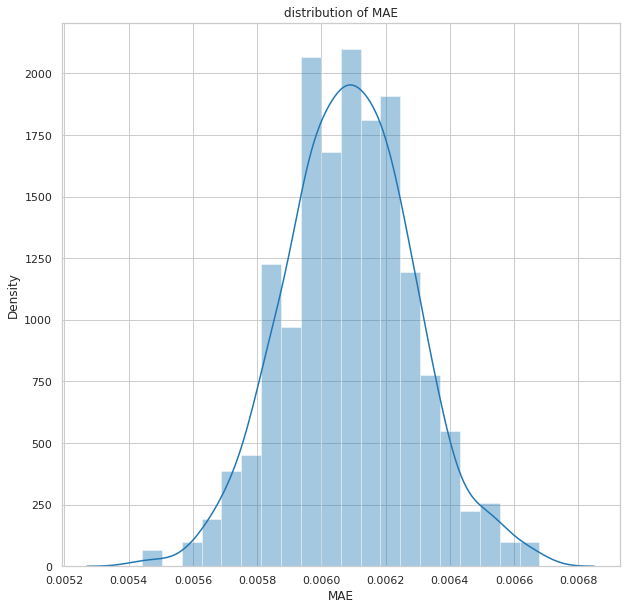

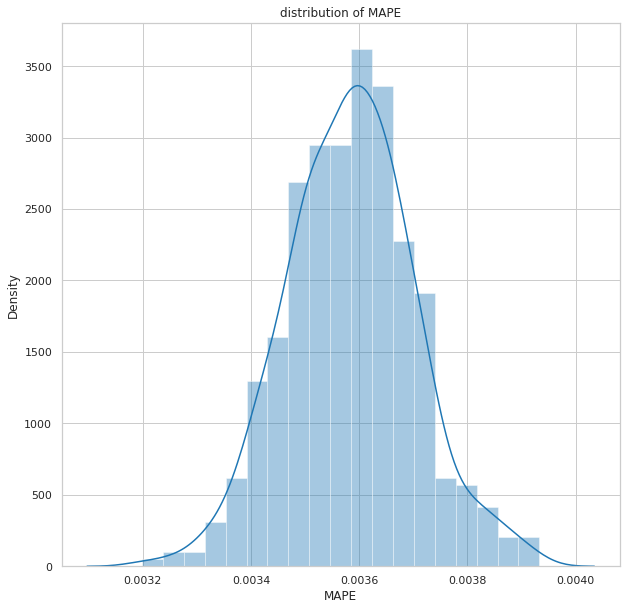

In [406]:
plt.figure(figsize=(10,10))
sns.distplot(mae)
plt.title('distribution of MAE')
plt.xlabel('MAE')
plt.show()

plt.figure(figsize=(10,10))
sns.distplot(mape)
plt.title('distribution of MAPE')
plt.xlabel('MAPE')
plt.show()

In [407]:
print('Mean of MAE : ', np.mean(mae),'Ahr', '\nMean of MAPE : ', np.mean(mape)*100,'%')
mae_3 = np.mean(mae)
mape_3 = np.mean(mape)

Mean of MAE :  0.0060880983379731895 Ahr 
Mean of MAPE :  0.3584174478650758 %


# Overall results

In [408]:
model_results = PrettyTable(["Best Model","Data status", "MAE", "MAPE"])

In [409]:
# best model from each case
val = model_no_interp.rows[-2]
model_results.add_row([val[1], 'no interpolation', val[3], val[5]])

val = model_interp.rows[-1]
model_results.add_row([val[1], 'interpolation', val[3], val[5]])

model_results.add_row(['Custom model - Fixed hyperparameters', 'interpolation', mae_1, mape_1])

model_results.add_row(['Custom model - Random hyperparameters', 'interpolation', mae_2, mape_2])

model_results.add_row(['Custom model - Flexible base models', 'interpolation', mae_3, mape_3])

print(model_results)

+---------------------------------------+------------------+-----------------------+-----------------------+
|               Best Model              |   Data status    |          MAE          |          MAPE         |
+---------------------------------------+------------------+-----------------------+-----------------------+
|              RF Regressor             | no interpolation |  0.008410592295548115 |  0.005028340051229557 |
|                  LGBM                 |  interpolation   |  0.004820496840610397 | 0.0028924121794289695 |
|  Custom model - Fixed hyperparameters |  interpolation   |  0.006739106218961135 |  0.003979258266257585 |
| Custom model - Random hyperparameters |  interpolation   |  0.006334682488415618 |  0.003739933962410828 |
|  Custom model - Flexible base models  |  interpolation   | 0.0060880983379731895 |  0.003584174478650758 |
+---------------------------------------+------------------+-----------------------+-----------------------+


# Training and saving model

In [ ]:
model = Custom_model(64, 128)
model.fit(X_train_1, X_train_2, y_train_1, y_train_2)

Training Base models
Training Meta model
Done


In [ ]:
# Pickling model
model_file = open('best_model.pkl', 'wb')
pickle.dump(model, model_file)
model_file.close()